In [1]:
import os

# Limit BLAS thread pools BEFORE importing numpy / implicit
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import pandas as pd

from pathlib import Path
from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares

from sklearn.model_selection import train_test_split

PROJECT_ROOT = Path("..").resolve()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

INTERACTIONS_PATH = DATA_PROCESSED / "interactions.parquet"
TRACK_META_PATH   = DATA_PROCESSED / "track_metadata.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("INTERACTIONS_PATH:", INTERACTIONS_PATH)
print("TRACK_META_PATH:", TRACK_META_PATH)



c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PROJECT_ROOT: C:\Users\Kiera\Music_Recommender
INTERACTIONS_PATH: C:\Users\Kiera\Music_Recommender\data\processed\interactions.parquet
TRACK_META_PATH: C:\Users\Kiera\Music_Recommender\data\processed\track_metadata.csv


In [3]:
interactions = pd.read_parquet(INTERACTIONS_PATH)

print("Raw interactions shape:", interactions.shape)
display(interactions.head())

# Optional: sample playlists to keep ALS light
# (adjust N_PLAYLISTS_UPPER if you want more)
N_PLAYLISTS_UPPER = 50000

unique_pids = interactions["pid"].unique()
print("Total unique playlists:", len(unique_pids))

if len(unique_pids) > N_PLAYLISTS_UPPER:
    sampled_pids = np.random.choice(unique_pids, size=N_PLAYLISTS_UPPER, replace=False)
    interactions = interactions[interactions["pid"].isin(sampled_pids)].copy()
    print("Subsampled interactions shape:", interactions.shape)
else:
    print("No subsampling applied.")


Raw interactions shape: (6685101, 4)


pid                track_id  pos  duration_ms
0    0  0UaMYEvWZi0ZqiDOoHU3YI    0       226863
1    0  6I9VzXrHxO9rA9A5euc8Ak    1       198800
2    0  0WqIKmW4BTrj3eJFmnCKMv    2       235933
3    0  1AWQoqb9bSvzTjaLralEkT    3       267266
4    0  1lzr43nnXAijIGYnCT8M8H    4       227600

Total unique playlists: 100000
Subsampled interactions shape: (3342921, 4)


In [4]:
train_pids, test_pids = train_test_split(
    interactions["pid"].unique(),
    test_size=0.2,
    random_state=42,
)

train_df = interactions[interactions["pid"].isin(train_pids)].copy()
test_df  = interactions[interactions["pid"].isin(test_pids)].copy()

print("Train interactions:", train_df.shape)
print("Test interactions:", test_df.shape)


Train interactions: (2671061, 4)
Test interactions: (671860, 4)


In [5]:
# Use only tracks that appear in TRAIN (this keeps the item set tight)
unique_train_tids = np.sort(train_df["track_id"].unique())
unique_train_pids = np.sort(train_df["pid"].unique())

tid_to_idx = {tid: i for i, tid in enumerate(unique_train_tids)}
idx_to_tid = np.array(unique_train_tids)

pid_to_idx = {pid: i for i, pid in enumerate(unique_train_pids)}
idx_to_pid = np.array(unique_train_pids)

print("Num playlists (train):", len(unique_train_pids))
print("Num tracks (train):   ", len(unique_train_tids))

# rows = playlists, cols = tracks
rows = train_df["pid"].map(pid_to_idx).values
cols = train_df["track_id"].map(tid_to_idx).values
data = np.ones_like(rows, dtype=np.float32)

user_item = csr_matrix(
    (data, (rows, cols)),
    shape=(len(unique_train_pids), len(unique_train_tids)),
)

print("user_item shape:", user_item.shape)
print("user_item nnz:", user_item.nnz)


Num playlists (train): 40000
Num tracks (train):    401373
user_item shape: (40000, 401373)
user_item nnz: 2636166


In [6]:
# implicit expects item-user matrix for training
item_user = user_item.T.tocsr()

factors = 64
regularization = 0.01
iterations = 10  # keep this modest to avoid long runs

als_model = AlternatingLeastSquares(
    factors=factors,
    regularization=regularization,
    iterations=iterations,
    random_state=42,
    use_gpu=False,      # make sure we stay on CPU
    num_threads=4,      # adjust if you want
)

print("Fitting ALS...")
als_model.fit(item_user)
print("Done.")


Fitting ALS...


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

Done.


In [7]:
print("user_item shape:", user_item.shape)
print("als_model.user_factors:", als_model.user_factors.shape)
print("als_model.item_factors:", als_model.item_factors.shape)
print("len(idx_to_tid):", len(idx_to_tid))

user_item shape: (40000, 401373)
als_model.user_factors: (401373, 64)
als_model.item_factors: (40000, 64)
len(idx_to_tid): 401373


In [8]:
track_meta = pd.read_csv(TRACK_META_PATH)

print("track_metadata.csv shape:", track_meta.shape)
display(track_meta.head())

# Metadata helper
meta_simple = track_meta[["track_id", "track_name", "artist_name", "album_name"]].drop_duplicates()
meta_simple = meta_simple.set_index("track_id")

def describe_tracks(track_ids, top_n=10):
    df = meta_simple.loc[meta_simple.index.intersection(track_ids)].copy()
    df = df.reset_index().rename(columns={"track_id": "track_id"})
    if top_n is not None:
        df = df.head(top_n)
    return df


track_metadata.csv shape: (679889, 7)


track_id                               track_name  \
0  0000uJA4xCdxThagdLkkLR                   Heart As Cold As Stone   
1  00039MgrmLoIzSpuYKurn9                           Thas What I Do   
2  0005w1bMJ7QAMl6DY98oxa  Sonata in G Major, BuxWV 271: Allegro -   
3  0007AYhg2UQbEm88mxu7js                  Mandarin Oranges Part 2   
4  000CTwOSsvRs0bgXlwB64e                              Shady World   

          artist_name                                         album_name  \
0        Cherryholmes                                       Cherryholmes   
1         Zach Farlow                                 The Great Escape 2   
2  Dietrich Buxtehude  Chamber Music: London Baroque - Rosenmuller, J...   
3         Little Simz                                            E.D.G.E   
4           Celly Cel                                     The Lost Tapes   

                              artist_uri  \
0  spotify:artist:5kEVfWQGTw0rIDO2Jqq1ww   
1  spotify:artist:2jTojc4rAsOMx6200a8Ah1   
2  spotify:artist:2YfFYZnshSzgfLsKZMM4VL   
3  spotify:artist:6eXZu6O7nAUA5z6vLV8NKI   
4  spotify:artist:6k7TX5dxiKZiwMWTn8ZKbl   

                              album_uri  duration_ms  
0  spotify:album:3SPMBGMEvPw21lmT5b1ApW       161186  
1  spotify:album:0UHfgx3ITlxePDXLaN5Y6x       222727  
2  spotify:album:6oRWciCAwKegipcCc5FlWe       111573  
3  spotify:album:32RJzqlapfiU0fr2l4SSW9       198000  
4  spotify:album:6LOmO9x8uPwlc3gSXZqqi8       155238

In [9]:
def recommend_for_playlist_manual(
    pid: int,
    model,
    user_item_csr,
    pid_to_idx: dict,
    idx_to_tid: np.ndarray,
    N: int = 10,
    filter_seen: bool = True,
):
    """
    Recommend tracks for a single playlist using ALS factors directly.

    IMPORTANT: In the current training setup, ALS was fit on a matrix where:
      - rows = playlists (as "items" in ALS)
      - cols = tracks    (as "users" in ALS)

    Therefore:
      - model.item_factors  -> playlist factors, shape (n_playlists, k)
      - model.user_factors  -> track factors,    shape (n_tracks, k)
    """

    if pid not in pid_to_idx:
        raise ValueError(f"Playlist {pid} not in pid_to_idx mapping")

    # Row index of this playlist in user_item_csr
    pl_idx = pid_to_idx[pid]

    n_playlists, n_tracks = user_item_csr.shape

    # ALS factors given how the model was trained
    track_factors = model.user_factors      # shape (n_tracks, k)
    playlist_factors = model.item_factors   # shape (n_playlists, k)

    # Sanity checks
    assert playlist_factors.shape[0] == n_playlists, \
        f"playlist_factors mismatch: {playlist_factors.shape[0]} vs {n_playlists}"
    assert track_factors.shape[0] == n_tracks, \
        f"track_factors mismatch: {track_factors.shape[0]} vs {n_tracks}"
    assert len(idx_to_tid) == n_tracks, \
        f"idx_to_tid length mismatch: {len(idx_to_tid)} vs {n_tracks}"

    # 1) Get latent vector for this playlist
    pl_vec = playlist_factors[pl_idx]  # (k,)

    # 2) Score all tracks: dot(track_factors, pl_vec)
    scores = track_factors @ pl_vec    # (n_tracks,)

    # 3) Optionally filter out tracks already in the playlist
    if filter_seen:
        row = user_item_csr[pl_idx]           # 1×n_tracks sparse row
        seen_track_idxs = row.indices         # column indices for tracks in this playlist
        scores[seen_track_idxs] = -np.inf     # never recommend already-seen ones

    # 4) Take top-N by score
    if N >= len(scores):
        topN_idx = np.argsort(-scores)
    else:
        topN_idx = np.argpartition(-scores, N)[:N]
        topN_idx = topN_idx[np.argsort(-scores[topN_idx])]

    top_scores = scores[topN_idx]
    rec_track_ids = idx_to_tid[topN_idx]

    # 5) Attach metadata
    rec_df = describe_tracks(rec_track_ids, top_n=None).copy()
    score_map = dict(zip(rec_track_ids, top_scores))
    rec_df["score"] = rec_df["track_id"].map(score_map)

    return rec_df

In [10]:
RANDOM_STATE = 42

some_pid = int(train_df["pid"].sample(1, random_state=RANDOM_STATE).iloc[0])
print("Example playlist ID:", some_pid)

true_tracks = train_df[train_df["pid"] == some_pid]["track_id"].unique()
print(f"Playlist has {len(true_tracks)} tracks in train set.\n")

print("Some existing tracks in this playlist:")
display(describe_tracks(true_tracks[:10]))

print("\nALS recommendations (manual scoring):")
recs = recommend_for_playlist_manual(
    some_pid,
    als_model,
    user_item,   # shape (n_playlists, n_tracks)
    pid_to_idx,
    idx_to_tid,
    N=15,
)
display(recs)


Example playlist ID: 168186
Playlist has 104 tracks in train set.

Some existing tracks in this playlist:


track_id     track_name              artist_name  \
0  0hxy93CbIX7Hd5WXaVjx5R   Street Fight               Smallpools   
1  0qnOjNW04qpcgXqD9dwru2  Killer Whales               Smallpools   
2  0rcB5TG1EeMRkZFJDkDtGF       Lovetap!               Smallpools   
3  1GCljGxAPoOyPW0Q7xbiny     I'm A Ruin  Marina and the Diamonds   
4  1lAcGnyioL0gEOy2xZvPWz       Sex Yeah  Marina and the Diamonds   
5  26Qg5sCCH8XHjYaqhWGn85           Blue  Marina and the Diamonds   
6  3iOdP2j5OH6Gjrvn16NZp6      Teen Idle  Marina and the Diamonds   
7  4sNwdacKyi2S26WrRtNama         Oh No!  Marina and the Diamonds   
8  5UBeEw8u5VurDhPo1klAPY          Froot  Marina and the Diamonds   
9  76LUyAG1MTqr8i72xgPNPf         Forget  Marina and the Diamonds   

          album_name  
0           LOVETAP!  
1           LOVETAP!  
2           LOVETAP!  
3              FROOT  
4      Electra Heart  
5              FROOT  
6      Electra Heart  
7  The Family Jewels  
8              FROOT  
9              FROOT


ALS recommendations (manual scoring):


track_id                                         track_name  \
0   07HPV6hzecJmMJwsIX8YVU                                He Could Be the One   
1   11dxtPJKR4E0wlSr0A0t47                             Potential Breakup Song   
2   1GBknQ67DCfKTPms1dw9EW                                   Nobody's Perfect   
3   1HwpWwa6bnqqRhK8agG4RS                                     Beautiful Soul   
4   1QkBx7D64jHSalJEQLanwT                                Gotta Go My Own Way   
5   3AWSwChgStOColFkXbwRnP                                      Breaking Free   
6   3KtzpxgZZzTPgNfkObCndB                             Start Of Something New   
7   3Q0Ngf7Llu1KIteVHRfiXw                                            Lovebug   
8   5Q0Nhxo0l2bP3pNjpGJwV1                                Party In The U.S.A.   
9   5c1sfI6wIQEsSUw0xrkFdl                                         This Is Me   
10  5ecZWU5uQOiCVSnPxBZNmT                                           7 Things   
11  6TRp2628QKH3kY6KrCnjqp  You Are The Music In Me - From "High School Mu...   
12  6YXG34IWbilypPwjBTOrUC                              Can I Have This Dance   
13  6jyXQ8HGI7ikECGA0670uo                                           Fabulous   
14  6p6TjiJHc1kJQt5dXzkdrs                                      I Don't Dance   

                 artist_name                           album_name     score  
0             Hannah Montana                     Hannah Montana 3  0.159638  
1                   Aly & AJ                          Insomniatic  0.118958  
2             Hannah Montana  Hannah Montana 2 / Meet Miley Cyrus  0.149566  
3            Jesse McCartney                       Beautiful Soul  0.147082  
4         Troy And Gabriella                  Gotta Go My Own Way  0.139268  
5   High School Musical Cast                  High School Musical  0.162098  
6   High School Musical Cast                  High School Musical  0.111366  
7             Jonas Brothers                  A Little Bit Longer  0.107835  
8                Miley Cyrus                The Time Of Our Lives  0.109388  
9                Demi Lovato        Camp Rock Original Soundtrack  0.139298  
10               Miley Cyrus                             Breakout  0.115781  
11                      Troy                High School Musical 2  0.113959  
12  High School Musical Cast   High School Musical 3: Senior Year  0.110786  
13             Sharpay Evans                High School Musical 2  0.110325  
14                      CHAD                High School Musical 2  0.107339

Track factors shape: (401373, 64)
Playlist factors shape: (40000, 64)
Track factor norms: mean 0.06260405 std 0.2777105
Playlist factor norms: mean 0.08925392 std 0.07928825


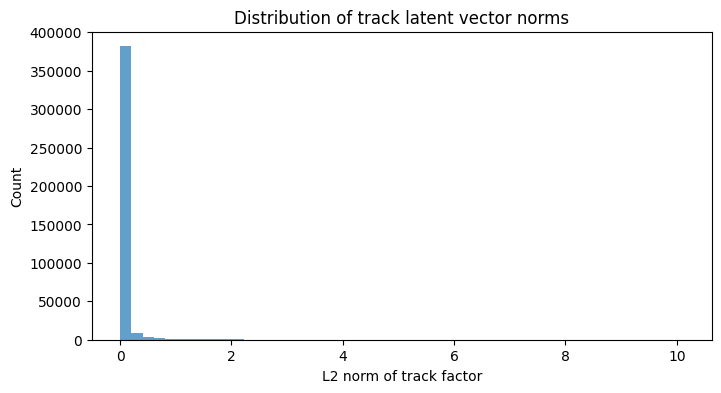

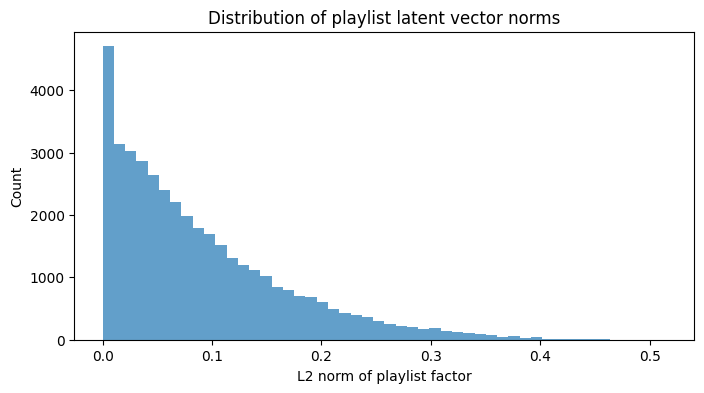

In [11]:
import numpy as np
import matplotlib.pyplot as plt

user_factors = als_model.user_factors      # tracks
item_factors = als_model.item_factors      # playlists

print("Track factors shape:", user_factors.shape)
print("Playlist factors shape:", item_factors.shape)

# Norms
track_norms = np.linalg.norm(user_factors, axis=1)
pl_norms = np.linalg.norm(item_factors, axis=1)

print("Track factor norms: mean", track_norms.mean(), "std", track_norms.std())
print("Playlist factor norms: mean", pl_norms.mean(), "std", pl_norms.std())

plt.figure(figsize=(8,4))
plt.hist(track_norms, bins=50, alpha=0.7)
plt.xlabel("L2 norm of track factor")
plt.ylabel("Count")
plt.title("Distribution of track latent vector norms")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(pl_norms, bins=50, alpha=0.7)
plt.xlabel("L2 norm of playlist factor")
plt.ylabel("Count")
plt.title("Distribution of playlist latent vector norms")
plt.show()


Running t-SNE on 5000 tracks...


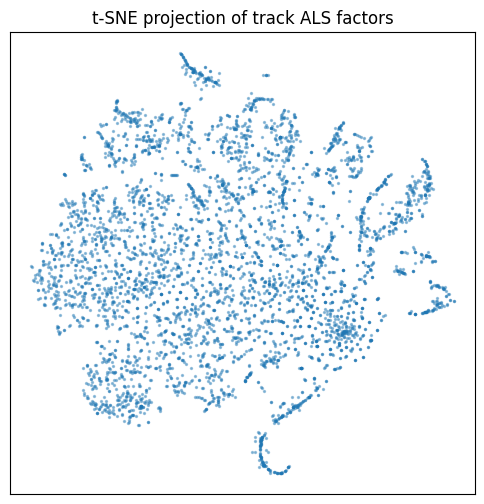

In [12]:
from sklearn.manifold import TSNE

N_TSNE = 5000  # sample some tracks/playlists for plotting

idx_sample = np.random.choice(user_factors.shape[0], size=N_TSNE, replace=False)
X_tsne_input = user_factors[idx_sample]

print("Running t-SNE on", X_tsne_input.shape[0], "tracks...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=500,
    metric="euclidean",
    random_state=42,
    init="random",
)
X_tsne = tsne.fit_transform(X_tsne_input)

plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=2, alpha=0.4)
plt.title("t-SNE projection of track ALS factors")
plt.xticks([]); plt.yticks([])
plt.show()


Running t-SNE on 5000 tracks...
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='random', learning_rate=600,
     n_iter=1000, n_jobs=-1, perplexity=40, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 120 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.62 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.37 seconds
===> Running optimization with exaggeration=12.00, lr=600.00 for 250 iterations...
Iteration   50, KL divergence 4.3127, 50 iterations in 0.7647 sec
Iteration  100, KL divergence 4.2488, 50 iterations in 0.8419 sec
Iteration  150, KL divergence 4.2471, 50 iterations in 0.7480 sec
Iteration  200, KL divergence 4.2468, 50 iterations in 1.0123 sec
Iteration  250, KL divergence 4.2468, 50 iterations in 0.8575 sec
   --> Time elapsed: 4.23 seconds
===> Running o

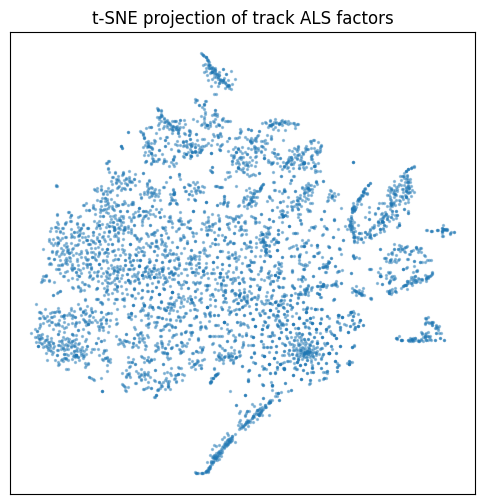

In [13]:
from openTSNE import TSNE
from tqdm import tqdm

print("Running t-SNE on", X_tsne_input.shape[0], "tracks...")

tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=600,
    n_iter=1000,
    metric="euclidean",
    random_state=42,
    initialization="random",
    verbose=True,
    n_jobs=-1,
)

X_tsne = tsne.fit(X_tsne_input)

# That's it! The progress will print automatically
# Then continue with your plotting:
plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=2, alpha=0.4)
plt.title("t-SNE projection of track ALS factors")
plt.xticks([]); plt.yticks([])
plt.show()

In [14]:
import pandas as pd
import numpy as np

# Simple lookup table for names (one row per track_id)
meta_simple = (
    track_meta[["track_id", "track_name", "artist_name", "album_name"]]
    .drop_duplicates(subset=["track_id"])
    .reset_index(drop=True)
)

meta_simple.head()


track_id                               track_name  \
0  0000uJA4xCdxThagdLkkLR                   Heart As Cold As Stone   
1  00039MgrmLoIzSpuYKurn9                           Thas What I Do   
2  0005w1bMJ7QAMl6DY98oxa  Sonata in G Major, BuxWV 271: Allegro -   
3  0007AYhg2UQbEm88mxu7js                  Mandarin Oranges Part 2   
4  000CTwOSsvRs0bgXlwB64e                              Shady World   

          artist_name                                         album_name  
0        Cherryholmes                                       Cherryholmes  
1         Zach Farlow                                 The Great Escape 2  
2  Dietrich Buxtehude  Chamber Music: London Baroque - Rosenmuller, J...  
3         Little Simz                                            E.D.G.E  
4           Celly Cel                                     The Lost Tapes

In [15]:
def find_tracks_by_name(query, n=25):
    """
    Fuzzy search for tracks whose name contains `query` (case-insensitive).
    Returns a small DataFrame of candidates to pick from.
    """
    mask = meta_simple["track_name"].str.contains(query, case=False, na=False)
    candidates = meta_simple[mask].head(n).reset_index(drop=True)
    return candidates


In [16]:
track_factors = als_model.user_factors  # rows correspond to internal track indices

def recommend_similar_tracks_by_id_als(seed_track_id, top_k=15):
    """
    Use ALS *track* factors as an item–item model:
    - take the latent vector for `seed_track_id`
    - score all other tracks by dot product
    - return top_k with metadata
    """
    if seed_track_id not in tid_to_idx:
        raise ValueError(f"track_id {seed_track_id} not in ALS training set")

    seed_idx = tid_to_idx[seed_track_id]
    seed_vec = track_factors[seed_idx]            # (factors,)
    
    # Scores for all tracks: similarity in ALS latent space
    scores = track_factors @ seed_vec            # (n_tracks,)
    
    # Don't recommend the seed itself
    scores[seed_idx] = -np.inf
    
    # Top-K indices
    top_idx = np.argpartition(-scores, top_k)[:top_k]
    top_idx = top_idx[np.argsort(-scores[top_idx])]
    
    top_scores = scores[top_idx]
    top_tids   = idx_to_tid[top_idx]

    rec_df = pd.DataFrame({
        "track_id": top_tids,
        "als_similarity": top_scores,
    })
    rec_df = rec_df.merge(meta_simple, on="track_id", how="left")
    return rec_df


In [17]:
def recommend_by_name_als(query, candidate_index=0, top_k=15):
    """
    1. Search by track name (LIKE '%query%')
    2. Show candidates so you can see what you're choosing
    3. Pick candidate_index (0-based)
    4. Return ALS-based similar tracks (with metadata + similarity score)
    """
    candidates = find_tracks_by_name(query, n=20)
    if candidates.empty:
        print(f"No matches for query: {query}")
        return None
    
    print("Search results:")
    display(candidates)
    
    if candidate_index >= len(candidates):
        raise IndexError(f"candidate_index {candidate_index} out of range (got {len(candidates)} matches)")
    
    seed_row = candidates.iloc[candidate_index]
    seed_tid = seed_row["track_id"]
    
    print("\nChosen seed track:")
    display(seed_row.to_frame().T)
    
    recs = recommend_similar_tracks_by_id_als(seed_tid, top_k=top_k)
    
    print("\nALS similar-track recommendations:")
    display(
        recs[[
            "track_name",
            "artist_name",
            "album_name",
            "als_similarity",
        ]]
    )
    
    return recs


In [18]:
# Example: recommend based on "ocean eyes"
recs = recommend_by_name_als("gold digger", candidate_index=10, top_k=15)


Search results:


track_id                                         track_name  \
0   0KYIiOHyUc4Nas7vJdIC8p                                        Gold Digger   
1   0SkkacQkMZRhfslMkogDTf  Gold Digger - (Karaoke Version) [In The Style ...   
2   14RcvIro4H3ZzLMOVUopij                                        Gold Digger   
3   1M1DkiVCJ7KURGMkSXrZKh                                        Gold Digger   
4   2xXvsn8TS0vChWiOYTjykJ                                        Gold Digger   
5   49iK9E5CzpPPfM2KmPGZOU                  Gold Digger (1962 Single Version)   
6   542PDuGAg1nAFCpdTHEstn                          Gold Digger - Power Remix   
7   59zeA8pvzq0ZHFR9asFR6N                                        Gold Digger   
8   5LfqRu6S4CNEQMhBRydbW2                                        Gold Digger   
9   5M1cPBSlmpztMxaTSv1Cdx                           Gold Digger - Mornay Mix   
10  5XJJdNPkwmbUwE79gv0NxK                                        Gold Digger   
11  5aXmteY8mnW2O5aUpwkqMN                                        Gold Digger   
12  6PgLf0yuB11BOysPAbrxPC                                        Gold Digger   
13  6zH0IWzQkDxT8GIbmprgzd                                        Gold Digger   
14  7mZsatQyGJKezH0Nq8Lgi5                                        Gold Digger   
15  7x1cPQLMzaKknLtdAU59dc                    Gold Digger (Glee Cast Version)   

               artist_name                                         album_name  
0   Vitamin String Quartet  Vitamin String Quartet Performs the Music of K...  
1   Karaoke Jukebox Heroes                  Karaoke: #1 Hits 2000-2009 Vol. 4  
2   Vitamin String Quartet  Vitamin String Quartet Performs the Songs from...  
3                     EPMD                                  Business As Usual  
4            Dash of Honey                                     Material World  
5              Jimmy Cliff                        The Ska Singles 1961 - 1962  
6                   Indy Q                    Best of Shape - Walking Workout  
7           Rockabye Baby!                   Lullaby Renditions of Kanye West  
8                   Lefree                                        Gold Digger  
9          Jackie Chandiru                                        Gold Digger  
10              Kanye West                                  Late Registration  
11                   Juice                                        Gold Digger  
12             Xavier Dunn                                             BIMYOU  
13                 MC Jams                                      Songs of 2015  
14              Jody Booth                                      Heaven & Hell  
15               Glee Cast                          Glee: The Music, Volume 1


Chosen seed track:


track_id   track_name artist_name         album_name
10  5XJJdNPkwmbUwE79gv0NxK  Gold Digger  Kanye West  Late Registration


ALS similar-track recommendations:


track_name                   artist_name  \
0                         Stronger                    Kanye West   
1                  Ni**as In Paris                         JAY Z   
2                            Yeah!                         Usher   
3                       In Da Club                       50 Cent   
4                 Ignition - Remix                      R. Kelly   
5            Drop It Like It's Hot                    Snoop Dogg   
6                            POWER                    Kanye West   
7                 Get Low - Street  Lil Jon & The East Side Boyz   
8                     Hot In Herre                         Nelly   
9                      Promiscuous                 Nelly Furtado   
10               All Of The Lights                    Kanye West   
11                       Heartless                    Kanye West   
12  Hey Ya! - Radio Mix / Club Mix                       OutKast   
13                      Candy Shop                       50 Cent   
14                       Good Life                    Kanye West   

                                 album_name  als_similarity  
0                                Graduation       35.822178  
1                                  Top Five       31.794304  
2                               Confessions       27.223244  
3                    Get Rich Or Die Tryin'       25.206762  
4                         Chocolate Factory       23.678230  
5   R&G (Rhythm & Gangsta): The Masterpiece       23.526394  
6         My Beautiful Dark Twisted Fantasy       22.685593  
7                            Kings Of Crunk       22.162746  
8                                Nellyville       22.012144  
9                                     Loose       19.129093  
10        My Beautiful Dark Twisted Fantasy       19.067749  
11                        808s & Heartbreak       18.566002  
12              Speakerboxxx/The Love Below       18.416370  
13                             The Massacre       18.129446  
14                               Graduation       17.473900

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def visualise_als_neighbourhood(
    query,
    candidate_index=0,
    top_k=30,
    n_background=1500,
    random_state=42,
):
    """
    Visualise where a seed song and its ALS neighbours live in the ALS latent space.
    """
    # 1) Find seed track by name
    candidates = find_tracks_by_name(query, n=20)
    if candidates.empty:
        print(f"No matches for query: {query}")
        return None
    
    print("Search results:")
    display(candidates)
    
    if candidate_index >= len(candidates):
        raise IndexError(
            f"candidate_index {candidate_index} out of range "
            f"(got {len(candidates)} matches)"
        )
    
    seed_row = candidates.iloc[candidate_index]
    seed_tid = seed_row["track_id"]
    
    print("\nChosen seed track:")
    display(seed_row.to_frame().T)
    
    # 2) ALS neighbours for this seed
    recs = recommend_similar_tracks_by_id_als(seed_tid, top_k=top_k)
    
    # 3) Build index sets
    n_tracks, n_factors = track_factors.shape
    rng = np.random.default_rng(random_state)
    
    seed_idx = tid_to_idx[seed_tid]
    neigh_tids = recs["track_id"].values
    neigh_idx = np.array([tid_to_idx[tid] for tid in neigh_tids])
    
    # background = random other tracks not in seed or neighbours
    forbidden = set([seed_idx]) | set(neigh_idx.tolist())
    all_idx = np.arange(n_tracks)
    mask_bg = np.array([i not in forbidden for i in all_idx])
    bg_candidates = all_idx[mask_bg]
    
    n_bg = min(n_background, len(bg_candidates))
    bg_idx = rng.choice(bg_candidates, size=n_bg, replace=False)
    
    # 4) Stack the factors for PCA
    all_plot_idx = np.concatenate([[seed_idx], neigh_idx, bg_idx])
    X = track_factors[all_plot_idx]   # (1 + top_k + n_bg, n_factors)
    
    # PCA to 2D
    pca = PCA(n_components=2, random_state=random_state)
    X_2d = pca.fit_transform(X)
    
    # Split back out
    seed_point     = X_2d[0:1]
    neigh_points   = X_2d[1:1+len(neigh_idx)]
    bg_points      = X_2d[1+len(neigh_idx):]
    
    # 5) Plot
    plt.figure(figsize=(8, 6))
    
    plt.scatter(
        bg_points[:, 0],
        bg_points[:, 1],
        s=5,
        alpha=0.2,
        label="Background tracks",
    )
    
    plt.scatter(
        neigh_points[:, 0],
        neigh_points[:, 1],
        s=30,
        alpha=0.8,
        label="ALS neighbours",
    )
    
    plt.scatter(
        seed_point[:, 0],
        seed_point[:, 1],
        s=120,
        marker="*",
        edgecolor="black",
        linewidth=1.0,
        label="Seed track",
    )
    
    plt.title(f"ALS latent space (PCA 2D) – neighbourhood of '{seed_row['track_name']}'")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        "seed": seed_row,
        "recs": recs,
        "indices": {
            "seed_idx": seed_idx,
            "neigh_idx": neigh_idx,
            "bg_idx": bg_idx,
        },
        "pca": pca,
    }


Search results:


track_id                                       track_name  \
0  0M8AdXqLJKGGXfYgabEX2C  Hotel Room Service - Dj Dizzy Hotel Motel Remix   
1  0OPyDgTRuIdCJ9B4bYSths                               Hotel Room Service   
2  4lxE7lFNmTmL7SVGAzxDnw                         Hotel Room Service Remix   

  artist_name                           album_name  
0    DJ Dizzy  Club Traxxx Summer Slammin', Vol. 3  
1     Pitbull       Pitbull Starring In Rebelution  
2     Pitbull       Pitbull Starring In Rebelution


Chosen seed track:


track_id          track_name artist_name  \
1  0OPyDgTRuIdCJ9B4bYSths  Hotel Room Service     Pitbull   

                       album_name  
1  Pitbull Starring In Rebelution

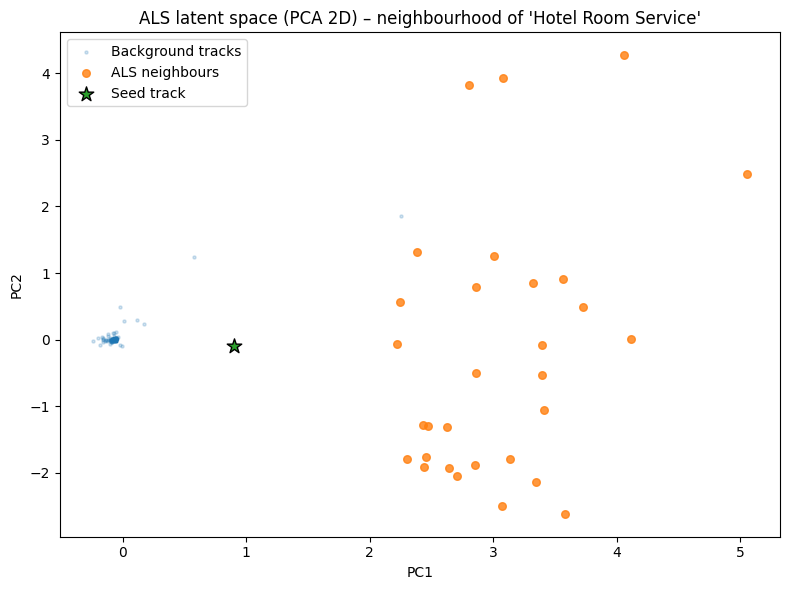

In [20]:
_ = visualise_als_neighbourhood("hotel room service", candidate_index=1, top_k=30)


Search results:


track_id                        track_name  \
0  1JbuC7uZm0P1PyX7N7gDEM      Ocean Eyes - GOLDHOUSE Remix   
1  2olNHiPoHP5SG6w2b84QEd                        Ocean Eyes   
2  3OMh7VdOoWgtKhJimQQywz                        ocean eyes   
3  3bM4b4P6QFDnjdXXI2zufO  Ocean Eyes - Cautious Clay Remix   
4  475HVfoKML70xddRf06X4h                        Ocean Eyes   
5  4BCGi8gpTqqN8RzyykvLoF                        Ocean Eyes   
6  4JuZQeSRYJfLCqBgBIxxrR      Ocean Eyes - Blackbear Remix   
7  6NOq79ynBpBi6BSJMdgReN     Ocean Eyes - Astronomyy Remix   
8  6q2NdteQRnT3FdRMiZm1Pn     Blue Ocean Eyes (feat. Sevar)   

           artist_name                     album_name  
0        Billie Eilish                     Ocean Eyes  
1  The Copper Children                    What We Are  
2        Billie Eilish               dont smile at me  
3        Billie Eilish                     Ocean Eyes  
4           Kool&Klean                       Volume I  
5         Dylan Wright            Ocean Eyes - Single  
6        Billie Eilish                     Ocean Eyes  
7        Billie Eilish                     Ocean Eyes  
8             Vugarixx  Blue Ocean Eyes (feat. Sevar)


Chosen seed track:


track_id  track_name    artist_name        album_name
2  3OMh7VdOoWgtKhJimQQywz  ocean eyes  Billie Eilish  dont smile at me

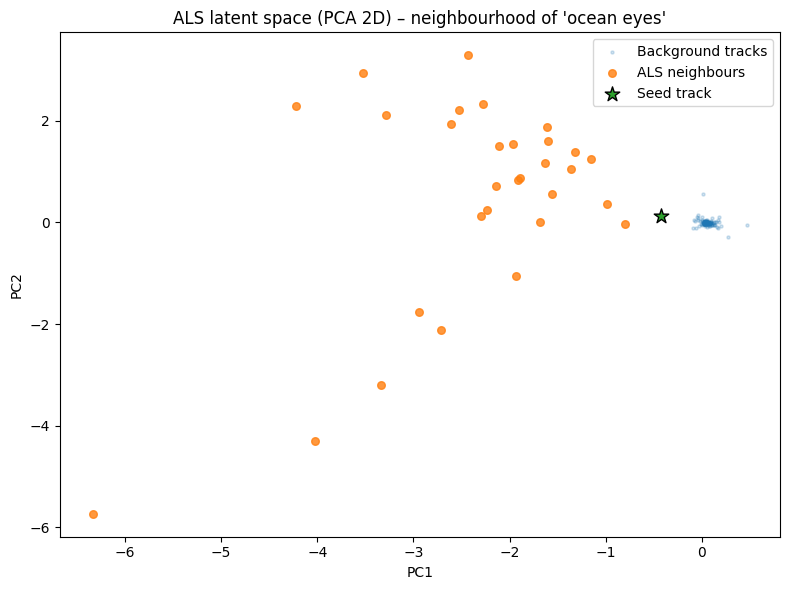

In [21]:
_ = visualise_als_neighbourhood("ocean eyes", candidate_index=2, top_k=30)


In [22]:
def visualise_two_als_neighbourhoods(
    query1, cand_idx1,
    query2, cand_idx2,
    top_k=30,
    n_background=2000,
    random_state=42,
):
    """
    Compare two seeds + their ALS neighbours in the same 2D latent space plot.
    """
    # 1) Resolve both seeds
    cand1 = find_tracks_by_name(query1, n=20)
    cand2 = find_tracks_by_name(query2, n=20)
    
    if cand1.empty or cand2.empty:
        print("One of the queries returned no results.")
        return None
    
    if cand_idx1 >= len(cand1) or cand_idx2 >= len(cand2):
        raise IndexError("candidate_index out of range for one of the queries.")
    
    seed1 = cand1.iloc[cand_idx1]
    seed2 = cand2.iloc[cand_idx2]
    
    seed1_tid = seed1["track_id"]
    seed2_tid = seed2["track_id"]
    
    print("Seed 1:")
    display(seed1.to_frame().T)
    print("\nSeed 2:")
    display(seed2.to_frame().T)
    
    # 2) ALS neighbours for both
    recs1 = recommend_similar_tracks_by_id_als(seed1_tid, top_k=top_k)
    recs2 = recommend_similar_tracks_by_id_als(seed2_tid, top_k=top_k)
    
    # 3) Indices
    n_tracks, n_factors = track_factors.shape
    rng = np.random.default_rng(random_state)
    
    s1_idx = tid_to_idx[seed1_tid]
    s2_idx = tid_to_idx[seed2_tid]
    
    neigh1_idx = np.array([tid_to_idx[t] for t in recs1["track_id"].values])
    neigh2_idx = np.array([tid_to_idx[t] for t in recs2["track_id"].values])
    
    forbidden = set([s1_idx, s2_idx]) | set(neigh1_idx.tolist()) | set(neigh2_idx.tolist())
    all_idx = np.arange(n_tracks)
    bg_candidates = all_idx[[i not in forbidden for i in all_idx]]
    
    n_bg = min(n_background, len(bg_candidates))
    bg_idx = rng.choice(bg_candidates, size=n_bg, replace=False)
    
    # 4) Stack for PCA
    all_plot_idx = np.concatenate([[s1_idx, s2_idx], neigh1_idx, neigh2_idx, bg_idx])
    X = track_factors[all_plot_idx]
    
    pca = PCA(n_components=2, random_state=random_state)
    X_2d = pca.fit_transform(X)
    
    # Split back out
    s1_point = X_2d[0:1]
    s2_point = X_2d[1:2]
    start_n1 = 2
    end_n1   = 2 + len(neigh1_idx)
    neigh1_points = X_2d[start_n1:end_n1]
    
    start_n2 = end_n1
    end_n2   = end_n1 + len(neigh2_idx)
    neigh2_points = X_2d[start_n2:end_n2]
    
    bg_points = X_2d[end_n2:]
    
    # 5) Plot
    plt.figure(figsize=(9, 7))
    
    plt.scatter(
        bg_points[:, 0], bg_points[:, 1],
        s=5, alpha=0.15, label="Background tracks", color="lightgrey"
    )
    
    plt.scatter(
        neigh1_points[:, 0], neigh1_points[:, 1],
        s=30, alpha=0.8, label=f"Neighbours of '{seed1['track_name']}'"
    )
    plt.scatter(
        neigh2_points[:, 0], neigh2_points[:, 1],
        s=30, alpha=0.8, label=f"Neighbours of '{seed2['track_name']}'"
    )
    
    plt.scatter(
        s1_point[:, 0], s1_point[:, 1],
        s=140, marker="*", edgecolor="black", linewidth=1.0,
        label=f"Seed 1: {seed1['track_name']}"
    )
    plt.scatter(
        s2_point[:, 0], s2_point[:, 1],
        s=140, marker="*", edgecolor="black", linewidth=1.0,
        label=f"Seed 2: {seed2['track_name']}"
    )
    
    plt.title("ALS latent space – two neighbourhoods compared (PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        "seed1": seed1,
        "seed2": seed2,
        "recs1": recs1,
        "recs2": recs2,
        "pca": pca,
    }


Seed 1:


track_id          track_name artist_name  \
1  0OPyDgTRuIdCJ9B4bYSths  Hotel Room Service     Pitbull   

                       album_name  
1  Pitbull Starring In Rebelution


Seed 2:


track_id  track_name    artist_name        album_name
2  3OMh7VdOoWgtKhJimQQywz  ocean eyes  Billie Eilish  dont smile at me

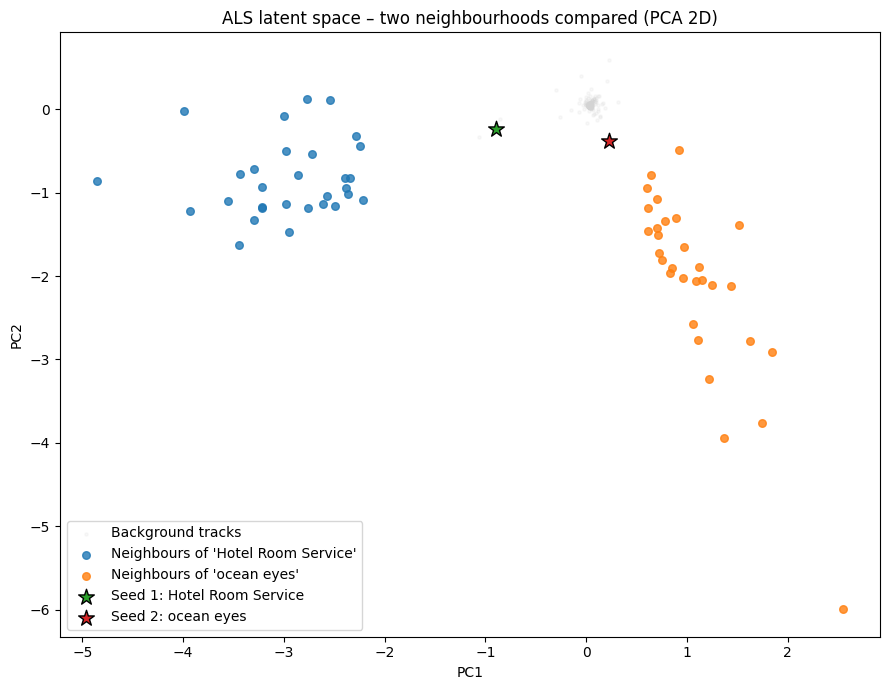

In [23]:
_ = visualise_two_als_neighbourhoods(
    "hotel room service", 1,   # Pitbull
    "ocean eyes",        2,   # Billie Eilish
    top_k=30,
)


In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def visualise_multi_als_neighbourhoods(
    seed_specs,
    top_k=30,
    n_background=3000,
    random_state=42,
):
    """
    Visualise multiple seeds and their ALS neighbours in the same 2D latent space.

    Parameters
    ----------
    seed_specs : list of dicts
        Each dict should have:
          - "query": str               (song name search term)
          - "candidate_index": int     (which search result to pick)
          - "label": optional str      (override label for legend)
    top_k : int
        Number of ALS neighbours per seed.
    n_background : int
        Number of random background tracks for context.
    random_state : int
        RNG seed for reproducible background sampling.
    """
    rng = np.random.default_rng(random_state)

    n_tracks, n_factors = track_factors.shape
    print(f"[INFO] ALS track_factors shape: {track_factors.shape}")

    seed_infos = []      # list of dicts with seed meta & indices
    neighbour_infos = [] # list of dicts with neighbours indices & recs

    # ----- 1. Resolve seeds + ALS neighbours -----
    for i, spec in enumerate(seed_specs):
        query = spec["query"]
        cand_idx = spec.get("candidate_index", 0)
        label = spec.get("label", query)

        print(f"\n[SEED {i}] Query: {query!r}")
        candidates = find_tracks_by_name(query, n=20)
        if candidates.empty:
            print(f"  -> No matches found, skipping this seed.")
            continue

        print("Search results:")
        display(candidates)

        if cand_idx >= len(candidates):
            print(f"  -> candidate_index={cand_idx} out of range "
                  f"(got {len(candidates)} matches), skipping.")
            continue

        seed_row = candidates.iloc[cand_idx]
        seed_tid = seed_row["track_id"]
        seed_idx = tid_to_idx.get(seed_tid)

        if seed_idx is None:
            print(f"  -> seed track_id {seed_tid} not in ALS index, skipping.")
            continue

        print("\nChosen seed track:")
        display(seed_row.to_frame().T)

        # ALS neighbours
        recs = recommend_similar_tracks_by_id_als(seed_tid, top_k=top_k)
        neigh_tids = recs["track_id"].values
        neigh_idx = np.array([tid_to_idx[tid] for tid in neigh_tids])

        seed_infos.append({
            "label": label,
            "query": query,
            "seed_row": seed_row,
            "seed_tid": seed_tid,
            "seed_idx": seed_idx,
        })
        neighbour_infos.append({
            "label": label,
            "indices": neigh_idx,
            "recs": recs,
        })

    if not seed_infos:
        print("No valid seeds found, nothing to plot.")
        return None

    # ----- 2. Build index sets for PCA -----
    seed_indices = np.array([s["seed_idx"] for s in seed_infos], dtype=int)

    neigh_indices_all = []
    for info in neighbour_infos:
        neigh_indices_all.extend(info["indices"].tolist())
    neigh_indices_all = np.array(sorted(set(neigh_indices_all)), dtype=int)

    # Background = tracks not in seeds or neighbours
    forbidden = set(seed_indices.tolist()) | set(neigh_indices_all.tolist())
    all_idx = np.arange(n_tracks, dtype=int)
    mask_bg = np.array([i not in forbidden for i in all_idx])
    bg_candidates = all_idx[mask_bg]

    if len(bg_candidates) == 0:
        print("[WARN] No background candidates available.")
        bg_idx = np.array([], dtype=int)
    else:
        n_bg = min(n_background, len(bg_candidates))
        bg_idx = rng.choice(bg_candidates, size=n_bg, replace=False)

    print(f"\n[INFO] Seeds: {len(seed_indices)}, "
          f"unique neighbours: {len(neigh_indices_all)}, "
          f"background: {len(bg_idx)}")

    # ----- 3. Stack factors & run PCA -> 2D -----
    all_plot_idx = np.concatenate([seed_indices, neigh_indices_all, bg_idx])
    X = track_factors[all_plot_idx]

    pca = PCA(n_components=2, random_state=random_state)
    X_2d = pca.fit_transform(X)

    # Split back into slices
    n_seeds = len(seed_indices)
    n_neigh = len(neigh_indices_all)
    n_bg = len(bg_idx)

    seeds_2d = X_2d[:n_seeds]
    neigh_2d = X_2d[n_seeds:n_seeds + n_neigh]
    bg_2d = X_2d[n_seeds + n_neigh:]

    # Map global neighbour indices back to each seed’s subset
    # for separate colours.
    idx_to_pos_in_neigh_all = {idx: pos for pos, idx in enumerate(neigh_indices_all)}

    # ----- 4. Plot -----
    plt.figure(figsize=(12, 8))

    # Background
    if n_bg > 0:
        plt.scatter(
            bg_2d[:, 0], bg_2d[:, 1],
            s=5, alpha=0.25, color="black", label="Background tracks"
        )

    # Colormap for seeds
    colors = plt.cm.tab10(np.linspace(0, 1, max(10, n_seeds)))

    # Neighbour clouds
    for i, (seed_info, neigh_info) in enumerate(zip(seed_infos, neighbour_infos)):
        label = seed_info["label"]
        c = colors[i]

        local_neigh_idx = neigh_info["indices"]
        local_positions = [idx_to_pos_in_neigh_all[idx] for idx in local_neigh_idx]
        local_points = neigh_2d[local_positions]

        plt.scatter(
            local_points[:, 0], local_points[:, 1],
            s=30, alpha=0.8, color=c,
            label=f"Neighbours of '{label}'"
        )

    # Seed points (stars)
    for i, seed_info in enumerate(seed_infos):
        label = seed_info["label"]
        c = colors[i]
        pt = seeds_2d[i:i+1]

        plt.scatter(
            pt[:, 0], pt[:, 1],
            s=150, marker="*", edgecolor="black", linewidth=1.0,
            color=c, label=f"Seed: {label}"
        )

    plt.title("ALS latent space (PCA 2D) – multiple seed neighbourhoods")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return {
        "seeds": seed_infos,
        "neighbours": neighbour_infos,
        "bg_indices": bg_idx,
        "pca": pca,
    }


[INFO] ALS track_factors shape: (401373, 64)

[SEED 0] Query: 'hotel room service'
Search results:


track_id                                       track_name  \
0  0M8AdXqLJKGGXfYgabEX2C  Hotel Room Service - Dj Dizzy Hotel Motel Remix   
1  0OPyDgTRuIdCJ9B4bYSths                               Hotel Room Service   
2  4lxE7lFNmTmL7SVGAzxDnw                         Hotel Room Service Remix   

  artist_name                           album_name  
0    DJ Dizzy  Club Traxxx Summer Slammin', Vol. 3  
1     Pitbull       Pitbull Starring In Rebelution  
2     Pitbull       Pitbull Starring In Rebelution


Chosen seed track:


track_id          track_name artist_name  \
1  0OPyDgTRuIdCJ9B4bYSths  Hotel Room Service     Pitbull   

                       album_name  
1  Pitbull Starring In Rebelution


[SEED 1] Query: 'ocean eyes'
Search results:


track_id                        track_name  \
0  1JbuC7uZm0P1PyX7N7gDEM      Ocean Eyes - GOLDHOUSE Remix   
1  2olNHiPoHP5SG6w2b84QEd                        Ocean Eyes   
2  3OMh7VdOoWgtKhJimQQywz                        ocean eyes   
3  3bM4b4P6QFDnjdXXI2zufO  Ocean Eyes - Cautious Clay Remix   
4  475HVfoKML70xddRf06X4h                        Ocean Eyes   
5  4BCGi8gpTqqN8RzyykvLoF                        Ocean Eyes   
6  4JuZQeSRYJfLCqBgBIxxrR      Ocean Eyes - Blackbear Remix   
7  6NOq79ynBpBi6BSJMdgReN     Ocean Eyes - Astronomyy Remix   
8  6q2NdteQRnT3FdRMiZm1Pn     Blue Ocean Eyes (feat. Sevar)   

           artist_name                     album_name  
0        Billie Eilish                     Ocean Eyes  
1  The Copper Children                    What We Are  
2        Billie Eilish               dont smile at me  
3        Billie Eilish                     Ocean Eyes  
4           Kool&Klean                       Volume I  
5         Dylan Wright            Ocean Eyes - Single  
6        Billie Eilish                     Ocean Eyes  
7        Billie Eilish                     Ocean Eyes  
8             Vugarixx  Blue Ocean Eyes (feat. Sevar)


Chosen seed track:


track_id  track_name    artist_name        album_name
2  3OMh7VdOoWgtKhJimQQywz  ocean eyes  Billie Eilish  dont smile at me


[SEED 2] Query: 'Paranoid Android'
Search results:


track_id                                   track_name  \
0  1cKDrnUwGE7vejktK58PTI                             Paranoid Android   
1  2nTsKOXIVGDf2iPeVQO2Gm                             Paranoid Android   
2  2o8QYkTODvc2JhZWatfnRG                             Paranoid Android   
3  2sowiwuhxt4nLIWP6vWJOa                             Paranoid Android   
4  2x4FXtLjsOaWRmaHgnaUzl  Paranoid Android (Made Famous by Radiohead)   
5  5DpcCycOihrtlk85DJlBCt                             Paranoid Android   
6  5PkNuAZ2xHnuNHIVvonkNv                             Paranoid Android   

             artist_name                           album_name  
0          El Ten Eleven  These Promises Are Being Videotaped  
1              Radiohead                          OK Computer  
2                    Sia   Exit Music: Songs With Radio Heads  
3           Brad Mehldau                                Largo  
4  Piano Tribute Players               35 Piano Rock Classics  
5         Gareth Pearson                  Urban Echoes Vol. 1  
6    Easy Star All-Stars                           Radiodread


Chosen seed track:


track_id        track_name artist_name   album_name
1  2nTsKOXIVGDf2iPeVQO2Gm  Paranoid Android   Radiohead  OK Computer


[SEED 3] Query: 'All I want for Christmas is You'
Search results:


track_id                                         track_name  \
0   01CAl93919STkcUjhduu9D                    All I Want for Christmas Is You   
1   0EVVUSgiXvwiLY0hHXG7GG                    All I Want For Christmas Is You   
2   0EweH7NNqxwaS4fCJ262WQ  All I Want For Christmas Is You - So So Def Re...   
3   0GeeK6IhQpZnLOoa79oxIU                    All I Want For Christmas Is You   
4   0HRvIqJxpkQOrqDsnslofN                    All I Want for Christmas Is You   
5   0OiJrQ6mW70e2d2iNKoMX5      All I Want for Christmas Is You - House Remix   
6   0bYg9bo50gSsH3LtXe2SQn                    All I Want for Christmas Is You   
7   0lgg2Kwj50tkR72hvcgGCB                    All I Want For Christmas Is You   
8   0u0Yuu2O6rgXLqr7KBMgzK                    All I Want for Christmas Is You   
9   0xPaZrF25ltzvz1a2Pm5DQ                    All I Want For Christmas Is You   
10  1ADBrQVLpNDALKtoEFIeSJ                    All I Want For Christmas Is You   
11  1KbFBaMyO8sPTviynJ3sLV                    All I Want for Christmas Is You   
12  1QaTg1bMMSSqG4WBC8PSZ3                    All I Want For Christmas Is You   
13  1j75fzIDImv5G7NvSW9FNK                    All I Want for Christmas Is You   
14  1tJULFJmqZUh3u1xKwA9q6                    All I Want For Christmas Is You   
15  2M89N3AoPGAIpoT9ysFtl7                    All I Want For Christmas Is You   
16  2VXRuCuXrdiZXFqGacUlWe                    All I Want For Christmas Is You   
17  2g2N78BH9x4iAzeSvjG7dU                    All I Want For Christmas Is You   
18  2iXxafXQ36rXa2w46wdr7I                    All I Want For Christmas Is You   
19  2pFlmxjoQXBHqnax5ZghpR       All I Want For Christmas Is You - Rerecorded   

                             artist_name  \
0                    Jessie James Decker   
1                         Whitney Duncan   
2                           Mariah Carey   
3                    Against The Current   
4                               Batfoot!   
5                          Pierre Cardin   
6                           Mariah Carey   
7                         Celtic Thunder   
8   The Covington Catholic Chamber Choir   
9                          Michael Bublé   
10                           LeAnn Rimes   
11                           Lovers Lane   
12                   Kurt Hugo Schneider   
13                             She & Him   
14                       Lady Antebellum   
15                         Sammy Kershaw   
16                          Will Downing   
17                          Mariah Carey   
18                          Idina Menzel   
19                        Celtic Thunder   

                               album_name  
0                          This Christmas  
1         All I Want For Christmas Is You  
2                           Greatest Hits  
3         All I Want For Christmas Is You  
4                     Punk Rock Christmas  
5                Christmas Remixes Vol. 1  
6                         Merry Christmas  
7                Celtic Thunder Christmas  
8                            I'll Be Home  
9                               Christmas  
10                 What A Wonderful World  
11                     Love Songs Salutes  
12        All I Want For Christmas Is You  
13                        Christmas Party  
14                 On This Winter's Night  
15              Christmas Time's A Comin'  
16                Christmas, Love And You  
17                 Merry Christmas II You  
18                         Holiday Wishes  
19  Christmas With Three Beautiful Voices


Chosen seed track:


track_id                       track_name   artist_name  \
6  0bYg9bo50gSsH3LtXe2SQn  All I Want for Christmas Is You  Mariah Carey   

        album_name  
6  Merry Christmas


[SEED 4] Query: 'gold digger'
Search results:


track_id                                         track_name  \
0   0KYIiOHyUc4Nas7vJdIC8p                                        Gold Digger   
1   0SkkacQkMZRhfslMkogDTf  Gold Digger - (Karaoke Version) [In The Style ...   
2   14RcvIro4H3ZzLMOVUopij                                        Gold Digger   
3   1M1DkiVCJ7KURGMkSXrZKh                                        Gold Digger   
4   2xXvsn8TS0vChWiOYTjykJ                                        Gold Digger   
5   49iK9E5CzpPPfM2KmPGZOU                  Gold Digger (1962 Single Version)   
6   542PDuGAg1nAFCpdTHEstn                          Gold Digger - Power Remix   
7   59zeA8pvzq0ZHFR9asFR6N                                        Gold Digger   
8   5LfqRu6S4CNEQMhBRydbW2                                        Gold Digger   
9   5M1cPBSlmpztMxaTSv1Cdx                           Gold Digger - Mornay Mix   
10  5XJJdNPkwmbUwE79gv0NxK                                        Gold Digger   
11  5aXmteY8mnW2O5aUpwkqMN                                        Gold Digger   
12  6PgLf0yuB11BOysPAbrxPC                                        Gold Digger   
13  6zH0IWzQkDxT8GIbmprgzd                                        Gold Digger   
14  7mZsatQyGJKezH0Nq8Lgi5                                        Gold Digger   
15  7x1cPQLMzaKknLtdAU59dc                    Gold Digger (Glee Cast Version)   

               artist_name                                         album_name  
0   Vitamin String Quartet  Vitamin String Quartet Performs the Music of K...  
1   Karaoke Jukebox Heroes                  Karaoke: #1 Hits 2000-2009 Vol. 4  
2   Vitamin String Quartet  Vitamin String Quartet Performs the Songs from...  
3                     EPMD                                  Business As Usual  
4            Dash of Honey                                     Material World  
5              Jimmy Cliff                        The Ska Singles 1961 - 1962  
6                   Indy Q                    Best of Shape - Walking Workout  
7           Rockabye Baby!                   Lullaby Renditions of Kanye West  
8                   Lefree                                        Gold Digger  
9          Jackie Chandiru                                        Gold Digger  
10              Kanye West                                  Late Registration  
11                   Juice                                        Gold Digger  
12             Xavier Dunn                                             BIMYOU  
13                 MC Jams                                      Songs of 2015  
14              Jody Booth                                      Heaven & Hell  
15               Glee Cast                          Glee: The Music, Volume 1


Chosen seed track:


track_id   track_name artist_name         album_name
10  5XJJdNPkwmbUwE79gv0NxK  Gold Digger  Kanye West  Late Registration


[INFO] Seeds: 5, unique neighbours: 140, background: 300000


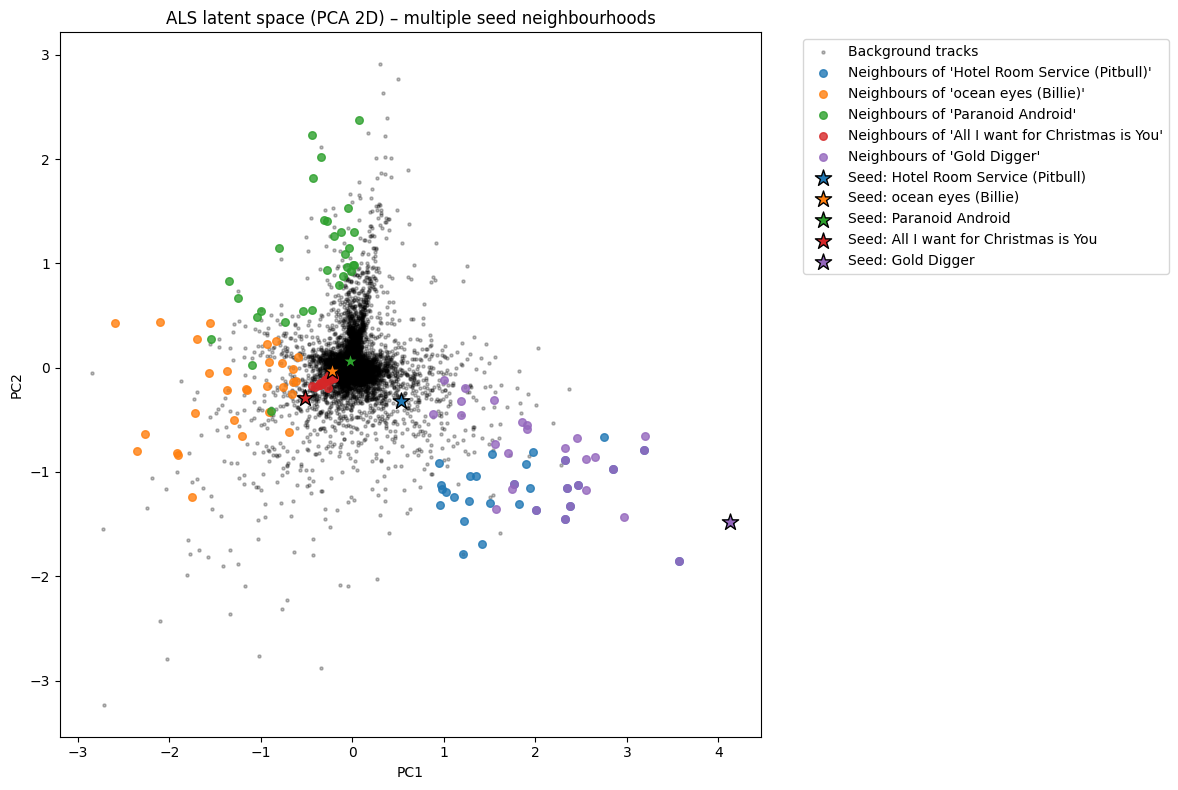

In [25]:
seed_specs = [
    {
        "query": "hotel room service",
        "candidate_index": 1,   # Pitbull
        "label": "Hotel Room Service (Pitbull)",
    },
    {
        "query": "ocean eyes",
        "candidate_index": 2,   # Billie Eilish
        "label": "ocean eyes (Billie)",
    },
    {
        "query": "Paranoid Android",
        "candidate_index": 1,
        "label": "Paranoid Android",
    },
    {
        "query": "All I want for Christmas is You",
        "candidate_index": 6,
        "label": "All I want for Christmas is You",
    },
    {
        "query": "gold digger",
        "candidate_index": 10,
        "label": "Gold Digger",
    },
]

_ = visualise_multi_als_neighbourhoods(
    seed_specs,
    top_k=30,
    n_background=300000,
)


Running t-SNE on track factors...


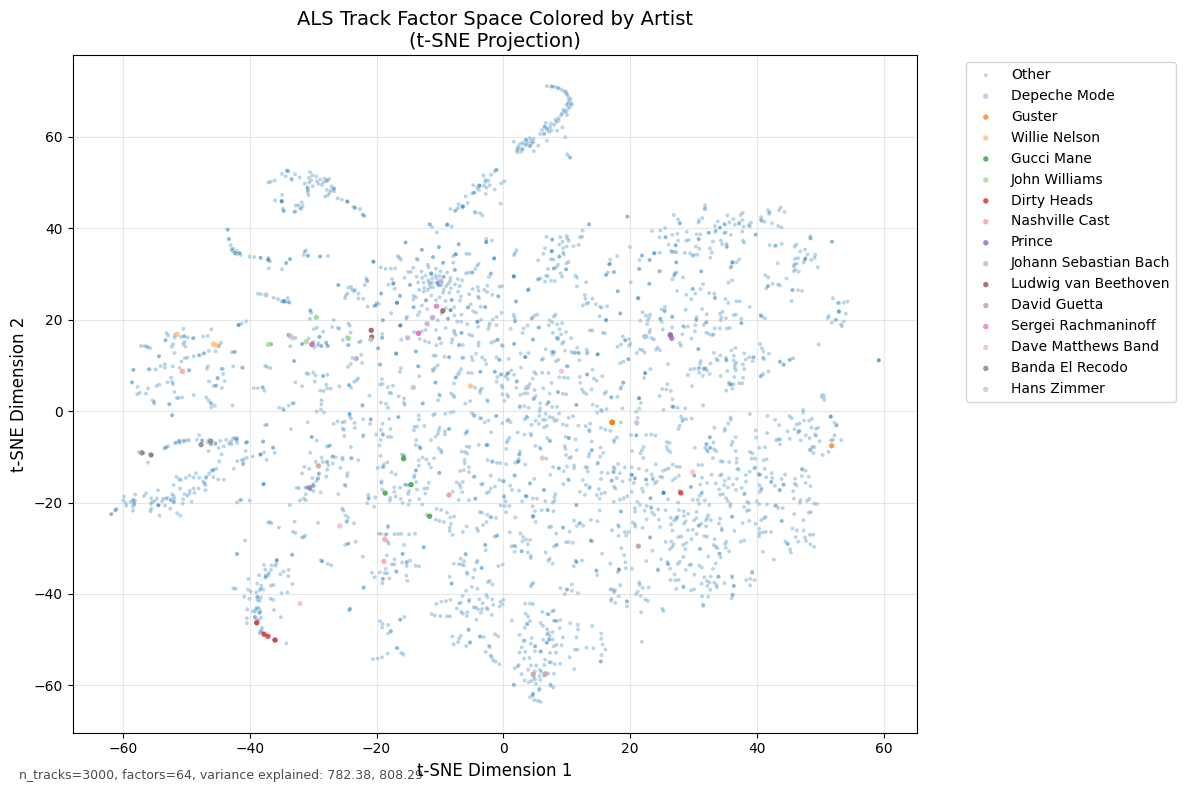

In [26]:
def plot_als_track_factors_by_genre(n_tracks=5000, random_state=42):
    """
    Visualize ALS track factors colored by genre clusters.
    Shows how ALS organizes music in latent space.
    """
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    import seaborn as sns
    
    # Sample tracks for visualization
    rng = np.random.default_rng(random_state)
    n_total = track_factors.shape[0]
    sample_idx = rng.choice(n_total, size=min(n_tracks, n_total), replace=False)
    
    # Get track metadata for sampled tracks
    sampled_tids = idx_to_tid[sample_idx]
    sampled_factors = track_factors[sample_idx]
    
    # Get genre information (simplified - using artist as proxy if genre not available)
    # If you have genre data, use it here instead
    sampled_df = pd.DataFrame({
        'track_id': sampled_tids,
        'track_idx': sample_idx
    })
    sampled_df = sampled_df.merge(
        track_meta[['track_id', 'artist_name']].drop_duplicates(), 
        on='track_id', 
        how='left'
    )
    
    # Top artists for coloring
    top_artists = sampled_df['artist_name'].value_counts().head(15).index.tolist()
    sampled_df['color_group'] = sampled_df['artist_name'].apply(
        lambda x: x if x in top_artists else 'Other'
    )
    
    # t-SNE for visualization
    print("Running t-SNE on track factors...")
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=random_state,
        init='random',
        learning_rate='auto'
    )
    tsne_results = tsne.fit_transform(sampled_factors)
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    # Get color palette
    unique_groups = sampled_df['color_group'].unique()
    palette = sns.color_palette("tab20", len(unique_groups))
    color_map = {group: palette[i] for i, group in enumerate(unique_groups)}
    
    # Plot each group
    for group in unique_groups:
        mask = sampled_df['color_group'] == group
        if group == 'Other':
            alpha = 0.3
            size = 8
        else:
            alpha = 0.8
            size = 15
        
        plt.scatter(
            tsne_results[mask, 0],
            tsne_results[mask, 1],
            s=size,
            alpha=alpha,
            c=[color_map[group]],
            label=group,
            edgecolors='none'
        )
    
    plt.title('ALS Track Factor Space Colored by Artist\n(t-SNE Projection)', fontsize=14)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    
    # Add some statistics
    plt.figtext(0.02, 0.02, 
                f'n_tracks={len(sampled_df)}, factors={track_factors.shape[1]}, '
                f'variance explained: {np.var(tsne_results[:, 0]):.2f}, {np.var(tsne_results[:, 1]):.2f}',
                fontsize=9, alpha=0.7)
    
    return plt.gcf(), sampled_df, tsne_results

# Generate the plot
fig, sampled_df, tsne_results = plot_als_track_factors_by_genre(n_tracks=3000)
plt.show()

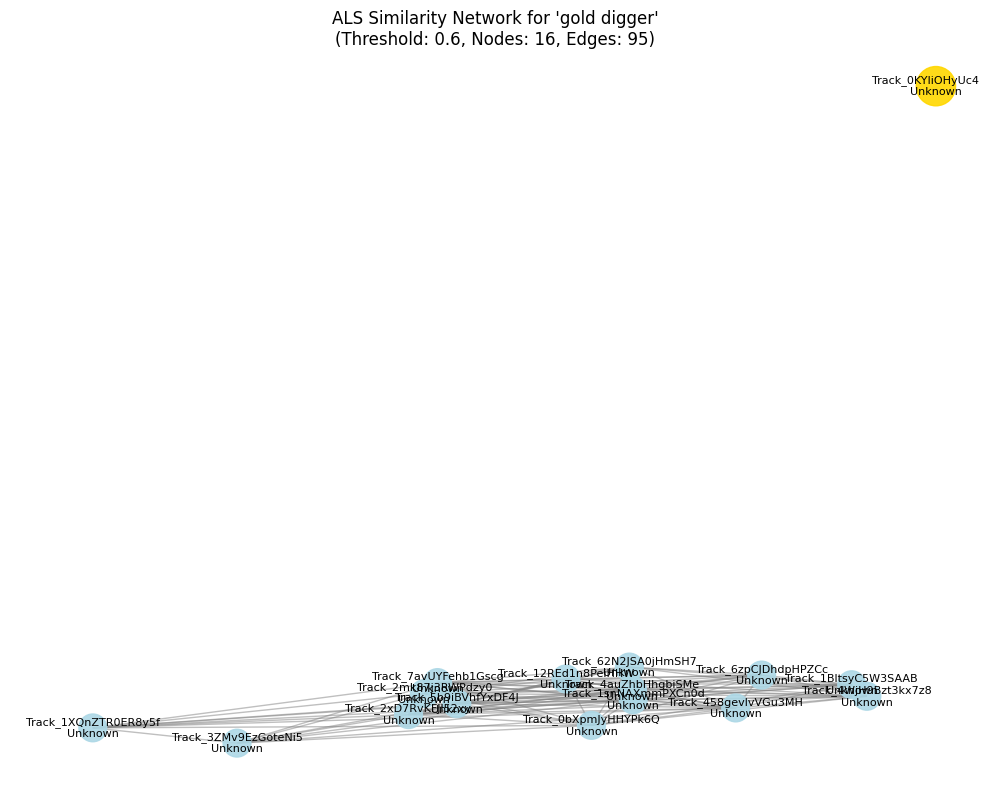

In [27]:
def visualize_als_similarity_network(seed_track_name, n_neighbors=10, threshold=0.7):
    """
    Create a network visualization showing ALS similarity relationships.
    """
    import networkx as nx
    import matplotlib.pyplot as plt
    
    # Find seed track
    candidates = find_tracks_by_name(seed_track_name, n=5)
    if candidates.empty:
        print(f"No track found with name containing '{seed_track_name}'")
        return None
    
    seed_tid = candidates.iloc[0]['track_id']
    seed_idx = tid_to_idx[seed_tid]
    seed_vec = track_factors[seed_idx]
    
    # Calculate similarities
    similarities = track_factors @ seed_vec
    similarities[seed_idx] = -np.inf  # Exclude self
    
    # Get top similar tracks
    top_indices = np.argpartition(-similarities, n_neighbors)[:n_neighbors]
    top_indices = top_indices[np.argsort(-similarities[top_indices])]
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes
    for i, idx in enumerate([seed_idx] + top_indices.tolist()):
        tid = idx_to_tid[idx]
        track_info = meta_simple.loc[tid] if tid in meta_simple.index else {
            'track_name': f'Track_{tid}',
            'artist_name': 'Unknown'
        }
        
        G.add_node(tid, 
                   name=track_info['track_name'][:20],
                   artist=track_info['artist_name'][:15],
                   is_seed=(i == 0),
                   similarity=similarities[idx] if i > 0 else 1.0)
    
    # Add edges based on similarity
    for i in range(len(G.nodes())):
        for j in range(i+1, len(G.nodes())):
            node_i = list(G.nodes())[i]
            node_j = list(G.nodes())[j]
            
            idx_i = tid_to_idx[node_i]
            idx_j = tid_to_idx[node_j]
            
            sim = track_factors[idx_i] @ track_factors[idx_j]
            if sim > threshold:
                G.add_edge(node_i, node_j, weight=sim)
    
    # Draw graph
    plt.figure(figsize=(10, 8))
    
    pos = nx.spring_layout(G, seed=42)
    
    # Node colors and sizes
    node_colors = ['gold' if G.nodes[n]['is_seed'] else 'lightblue' for n in G.nodes()]
    node_sizes = [800 if G.nodes[n]['is_seed'] else 400 for n in G.nodes()]
    
    # Draw
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')
    
    # Labels
    labels = {n: f"{G.nodes[n]['name']}\n{G.nodes[n]['artist']}" for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title(f"ALS Similarity Network for '{seed_track_name}'\n"
              f"(Threshold: {threshold}, Nodes: {len(G.nodes())}, Edges: {len(G.edges())})", 
              fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    
    return G, fig

# Example usage
G, fig = visualize_als_similarity_network("gold digger", n_neighbors=15, threshold=0.6)
plt.show()

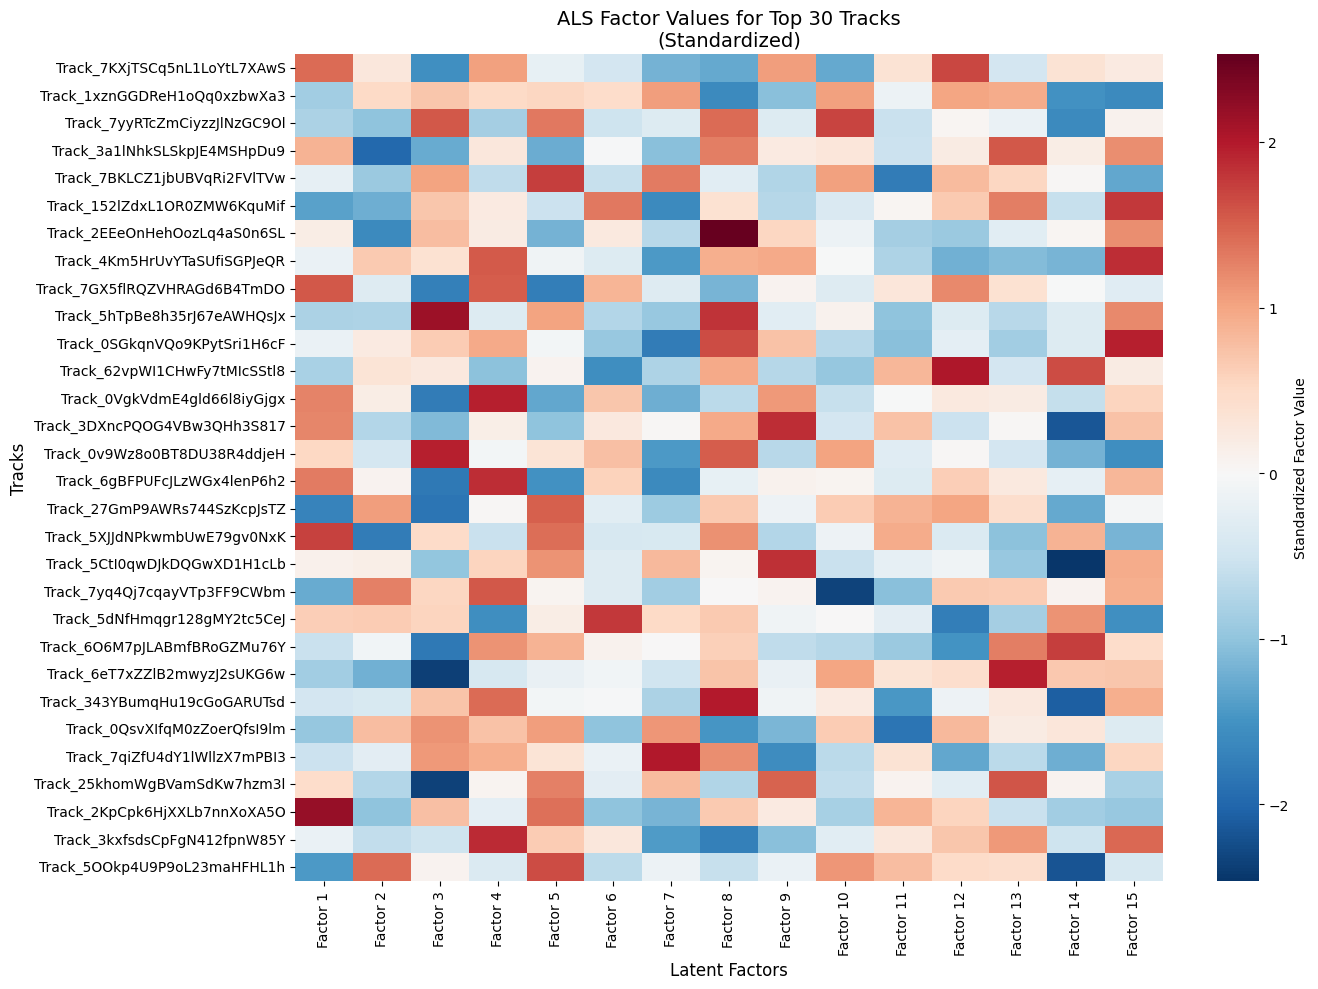

In [28]:
def visualize_als_factor_heatmap(n_tracks=50, n_factors=20):
    """
    Show heatmap of factor values for top tracks.
    Reveals patterns in how factors encode track characteristics.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Get popular tracks (by number of playlists)
    track_counts = train_df['track_id'].value_counts()
    top_tracks = track_counts.head(n_tracks).index.tolist()
    
    # Get factor values for these tracks
    track_indices = [tid_to_idx[tid] for tid in top_tracks if tid in tid_to_idx]
    if not track_indices:
        print("No tracks found in training data")
        return None
    
    factor_matrix = track_factors[track_indices, :n_factors]
    
    # Get track names for labels
    track_names = []
    for tid in top_tracks:
        if tid in meta_simple.index:
            name = meta_simple.loc[tid, 'track_name'][:30]
            artist = meta_simple.loc[tid, 'artist_name'][:15]
            track_names.append(f"{name}\n({artist})")
        else:
            track_names.append(f"Track_{tid}")
    
    # Create heatmap
    plt.figure(figsize=(14, 10))
    
    # Normalize for better visualization
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    normalized_matrix = scaler.fit_transform(factor_matrix.T).T
    
    # Plot
    sns.heatmap(normalized_matrix, 
                cmap='RdBu_r',
                center=0,
                xticklabels=[f"Factor {i+1}" for i in range(n_factors)],
                yticklabels=track_names,
                cbar_kws={'label': 'Standardized Factor Value'},
                square=False)
    
    plt.title(f'ALS Factor Values for Top {n_tracks} Tracks\n(Standardized)', fontsize=14)
    plt.xlabel('Latent Factors', fontsize=12)
    plt.ylabel('Tracks', fontsize=12)
    plt.tight_layout()
    
    return plt.gcf()

# Generate heatmap
fig = visualize_als_factor_heatmap(n_tracks=30, n_factors=15)
plt.show()

Track distribution:
  Other: 29912 tracks
  Johnny Cash: 16 tracks
  Nirvana: 14 tracks
  Daft Punk: 13 tracks
  Eminem: 13 tracks
  Radiohead: 13 tracks
  Coldplay: 11 tracks
  Beyoncé: 8 tracks

Running t-SNE on track factors...


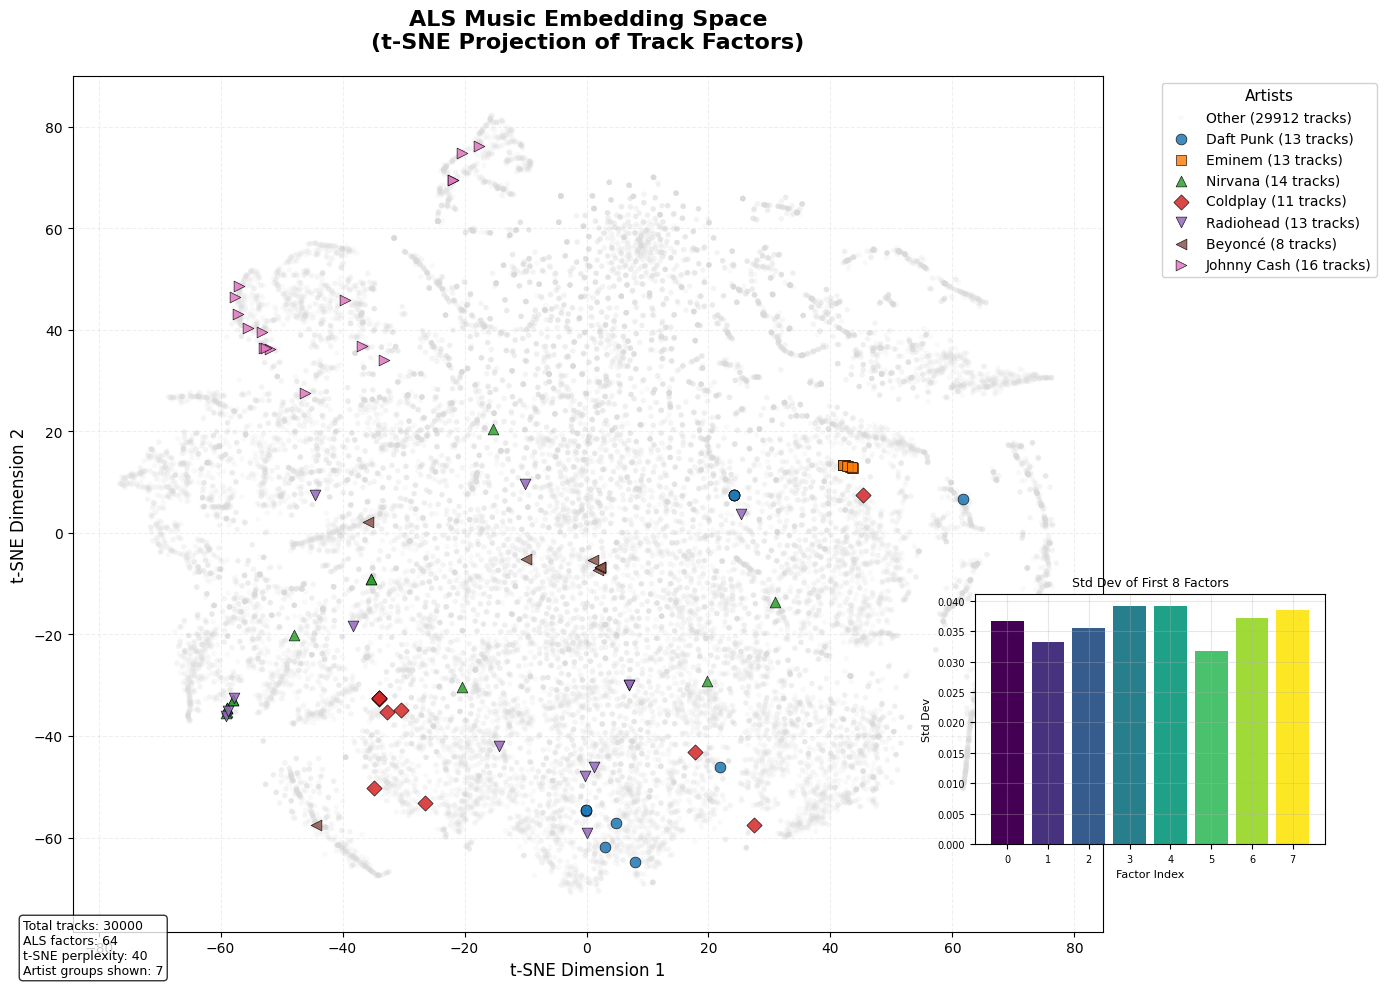

In [29]:
def plot_als_track_factors_by_genre_distinct(n_tracks=3000, n_top_artists=8, random_state=42):
    """
    Visualize ALS track factors with distinct colors for fewer artists.
    Clearer visualization for articles/presentations.
    """
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    import seaborn as sns
    import numpy as np
    
    # Sample tracks for visualization
    rng = np.random.default_rng(random_state)
    n_total = track_factors.shape[0]
    sample_idx = rng.choice(n_total, size=min(n_tracks, n_total), replace=False)
    
    # Get track metadata for sampled tracks
    sampled_tids = idx_to_tid[sample_idx]
    sampled_factors = track_factors[sample_idx]
    
    # Get artist information
    sampled_df = pd.DataFrame({
        'track_id': sampled_tids,
        'track_idx': sample_idx
    })
    sampled_df = sampled_df.merge(
        track_meta[['track_id', 'artist_name', 'track_name']].drop_duplicates(), 
        on='track_id', 
        how='left'
    )
    
    # Fill NaN artist names
    sampled_df['artist_name'] = sampled_df['artist_name'].fillna('Unknown')
    
    # Select distinctive artists across different genres for better visualization
    # Manually curate artists for clear genre representation
    distinctive_artists = [
        'Beyoncé',          # R&B/Pop
        'Radiohead',        # Alternative/Experimental
        'Johnny Cash',      # Country
        'Mozart',           # Classical
        'Eminem',           # Hip-hop/Rap
        'Coldplay',         # Pop Rock
        'Daft Punk',        # Electronic
        'Nirvana',          # Grunge/Rock
    ]
    
    # Check which artists exist in our sample
    available_artists = [a for a in distinctive_artists 
                        if a in sampled_df['artist_name'].values]
    
    if len(available_artists) < 3:
        # Fallback to top artists if our curated list isn't available
        available_artists = sampled_df['artist_name'].value_counts().head(n_top_artists).index.tolist()
    
    # Categorize tracks
    sampled_df['color_group'] = sampled_df['artist_name'].apply(
        lambda x: x if x in available_artists else 'Other'
    )
    
    # Count tracks in each group
    group_counts = sampled_df['color_group'].value_counts()
    print("Track distribution:")
    for group, count in group_counts.items():
        print(f"  {group}: {count} tracks")
    
    # t-SNE for visualization
    print("\nRunning t-SNE on track factors...")
    tsne = TSNE(
        n_components=2,
        perplexity=40,  # Slightly higher for better global structure
        random_state=random_state,
        init='pca',     # Better initialization for distinct clusters
        learning_rate=200,
        max_iter=1000
    )
    tsne_results = tsne.fit_transform(sampled_factors)
    
    # Add t-SNE coordinates to dataframe
    sampled_df['tsne_x'] = tsne_results[:, 0]
    sampled_df['tsne_y'] = tsne_results[:, 1]
    
    # Plot
    plt.figure(figsize=(14, 10))
    
    # Use a high-contrast color palette
    # Distinct colors for main artists, light gray for "Other"
    main_groups = [g for g in sampled_df['color_group'].unique() if g != 'Other']
    
    # Color palette: tab10 for main groups, light gray for "Other"
    if len(main_groups) <= 10:
        main_palette = sns.color_palette("tab10", n_colors=len(main_groups))
    else:
        main_palette = sns.color_palette("husl", n_colors=len(main_groups))
    
    color_map = {}
    for i, group in enumerate(main_groups):
        color_map[group] = main_palette[i]
    color_map['Other'] = (0.85, 0.85, 0.85, 0.3)  # Very light gray with transparency
    
    # Plot "Other" first (background)
    other_mask = sampled_df['color_group'] == 'Other'
    if other_mask.any():
        plt.scatter(
            sampled_df.loc[other_mask, 'tsne_x'],
            sampled_df.loc[other_mask, 'tsne_y'],
            s=15,  # Smaller for background
            alpha=0.15,  # More transparent
            c=[color_map['Other']],
            edgecolors='none',
            label=f'Other ({group_counts.get("Other", 0)} tracks)'
        )
    
    # Plot main artist groups with distinct styles
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'X']
    
    for i, group in enumerate(main_groups):
        mask = sampled_df['color_group'] == group
        
        # Use different markers for even more distinction
        marker = markers[i % len(markers)] if i < len(markers) else 'o'
        
        plt.scatter(
            sampled_df.loc[mask, 'tsne_x'],
            sampled_df.loc[mask, 'tsne_y'],
            s=60,  # Larger for main artists
            alpha=0.85,  # More opaque
            c=[color_map[group]],
            marker=marker,
            edgecolors='black',
            linewidth=0.5,
            label=f'{group} ({group_counts.get(group, 0)} tracks)'
        )
    
    plt.title('ALS Music Embedding Space\n(t-SNE Projection of Track Factors)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Legend with better formatting
    legend = plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=10,
        frameon=True,
        fancybox=True,
        framealpha=0.9,
        title='Artists',
        title_fontsize=11
    )
    
    # Add grid for reference
    plt.grid(True, alpha=0.2, linestyle='--')
    
    # Add informative text box
    plt.figtext(0.02, 0.02, 
                f'Total tracks: {len(sampled_df)}\n'
                f'ALS factors: {track_factors.shape[1]}\n'
                f't-SNE perplexity: {tsne.perplexity}\n'
                f'Artist groups shown: {len(main_groups)}',
                fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Also create an inset showing the original factor space
    fig = plt.gcf()
    ax_inset = fig.add_axes([0.7, 0.15, 0.25, 0.25])  # [left, bottom, width, height]
    
    # Show variance of first few original factors
    n_factors_to_show = min(8, track_factors.shape[1])
    factor_std = np.std(track_factors[sample_idx, :n_factors_to_show], axis=0)
    
    bars = ax_inset.bar(range(n_factors_to_show), factor_std, 
                       color=plt.cm.viridis(np.linspace(0, 1, n_factors_to_show)))
    ax_inset.set_xlabel('Factor Index', fontsize=8)
    ax_inset.set_ylabel('Std Dev', fontsize=8)
    ax_inset.set_title(f'Std Dev of First {n_factors_to_show} Factors', fontsize=9)
    ax_inset.tick_params(labelsize=7)
    ax_inset.grid(True, alpha=0.3)
    
    return plt.gcf(), sampled_df, tsne_results

# Generate the plot
fig, sampled_df, tsne_results = plot_als_track_factors_by_genre_distinct(n_tracks=30000, n_top_artists=8)
plt.show()

Sampling 30,000 tracks from 401,373 total
Running UMAP on 30,000 tracks...
UMAP(n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Fri Dec 12 14:20:03 2025 Construct fuzzy simplicial set
Fri Dec 12 14:20:03 2025 Finding Nearest Neighbors
Fri Dec 12 14:20:03 2025 Building RP forest with 14 trees


c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Fri Dec 12 14:20:08 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Dec 12 14:20:21 2025 Finished Nearest Neighbor Search
Fri Dec 12 14:20:23 2025 Construct embedding


Epochs completed:   3%| ▎          6/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  12%| █▏         24/200 [00:02]

	completed  20  /  200 epochs


Epochs completed:  22%| ██▏        44/200 [00:03]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▏       64/200 [00:05]

	completed  60  /  200 epochs


Epochs completed:  43%| ████▎      86/200 [00:07]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▏     104/200 [00:08]

	completed  100  /  200 epochs


Epochs completed:  63%| ██████▎    126/200 [00:10]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▏   144/200 [00:11]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▏  164/200 [00:13]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▏ 184/200 [00:14]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:15]


Fri Dec 12 14:20:42 2025 Finished embedding
Featured artists: ['Taylor Swift', 'Drake', 'Beyoncé', 'Ed Sheeran', 'The Beatles', 'Ivy Queen', 'Eminem', 'Rihanna']


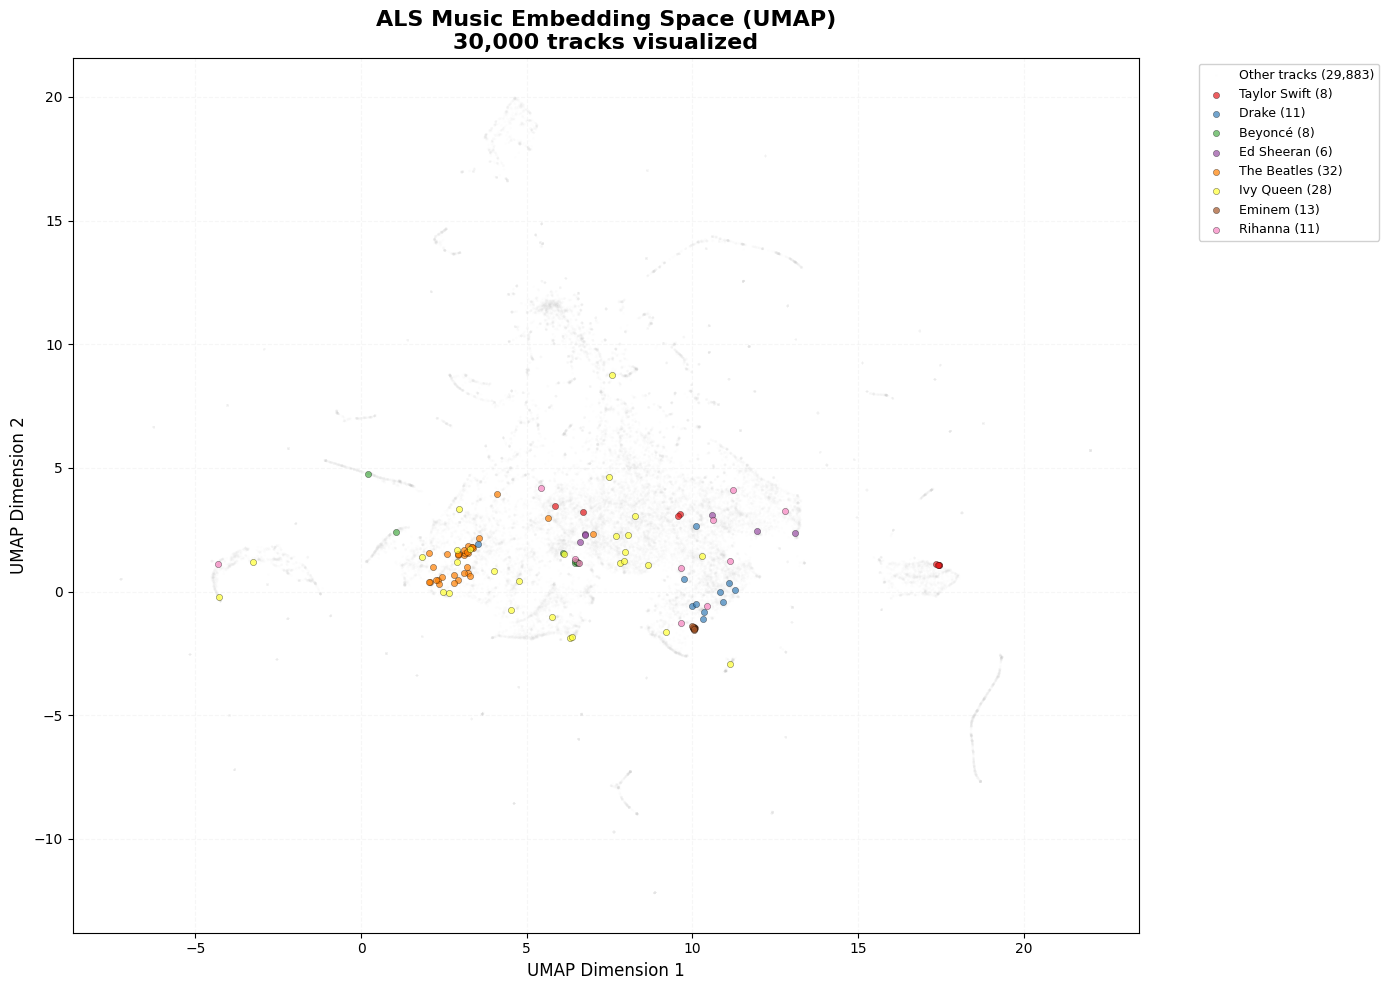

In [30]:
import umap
import matplotlib.pyplot as plt
import numpy as np

def plot_als_tracks_umap(n_tracks=30000, target_artists=None, random_state=42):
    """
    Use UMAP for large-scale visualization (much faster than t-SNE).
    """
    # Sample tracks (you can use all tracks if you have enough RAM)
    n_total = track_factors.shape[0]
    n_sample = min(n_tracks, n_total)
    
    if n_sample == n_total:
        # Use all tracks
        sample_idx = np.arange(n_total)
        print(f"Using ALL {n_total:,} tracks")
    else:
        # Random sample
        rng = np.random.default_rng(random_state)
        sample_idx = rng.choice(n_total, size=n_sample, replace=False)
        print(f"Sampling {n_sample:,} tracks from {n_total:,} total")
    
    sampled_factors = track_factors[sample_idx]
    sampled_tids = idx_to_tid[sample_idx]
    
    # Create dataframe with metadata
    sampled_df = pd.DataFrame({'track_id': sampled_tids})
    sampled_df = sampled_df.merge(
        track_meta[['track_id', 'artist_name', 'track_name']].drop_duplicates(),
        on='track_id',
        how='left'
    )
    sampled_df['artist_name'] = sampled_df['artist_name'].fillna('Unknown')
    
    # Define artist groups (6-8 distinctive ones)
    if target_artists is None:
        # Default to a mix of popular and distinctive artists
        target_artists = [
            'Taylor Swift', 'Drake', 'Beyoncé', 'Ed Sheeran',
            'The Beatles', 'Queen', 'Eminem', 'Rihanna'
        ]
    
    # Find actual artist names in our sample
    available_artists = []
    for artist in target_artists:
        mask = sampled_df['artist_name'].str.contains(artist, case=False, na=False)
        if mask.any():
            actual_name = sampled_df.loc[mask, 'artist_name'].iloc[0]
            available_artists.append(actual_name)
            sampled_df.loc[mask, 'artist_name'] = actual_name
    
    # Add a few more from top artists if needed
    if len(available_artists) < 4:
        top_artists = sampled_df['artist_name'].value_counts().head(10).index.tolist()
        for artist in top_artists:
            if artist not in available_artists:
                available_artists.append(artist)
            if len(available_artists) >= 6:
                break
    
    # Categorize
    sampled_df['group'] = sampled_df['artist_name'].apply(
        lambda x: x if x in available_artists else 'Other'
    )
    
    # Run UMAP (much faster for large datasets)
    print(f"Running UMAP on {len(sampled_factors):,} tracks...")
    
    # Create UMAP reducer with settings optimized for speed
    reducer = umap.UMAP(
        n_neighbors=30,           # Larger for more global structure
        min_dist=0.1,             # Slight separation between clusters
        n_components=2,
        metric='euclidean',
        random_state=random_state,
        n_jobs=-1,                # Use all cores
        low_memory=True,          # Memory efficient
        verbose=True              # Show progress
    )
    
    embedding = reducer.fit_transform(sampled_factors)
    sampled_df['x'] = embedding[:, 0]
    sampled_df['y'] = embedding[:, 1]
    
    # Plot
    plt.figure(figsize=(14, 10))
    
    # Plot "Other" tracks as faint background
    other_mask = sampled_df['group'] == 'Other'
    if other_mask.any():
        plt.scatter(
            sampled_df.loc[other_mask, 'x'],
            sampled_df.loc[other_mask, 'y'],
            s=3,                    # Very small points
            alpha=0.03,             # Very transparent
            color='#CCCCCC',
            edgecolors='none',
            label=f'Other tracks ({other_mask.sum():,})'
        )
    
    # Define distinct colors for main artists
    colors = [
        '#E41A1C', '#377EB8', '#4DAF4A', '#984EA3',
        '#FF7F00', '#FFFF33', '#A65628', '#F781BF',
        '#999999', '#66C2A5', '#FC8D62', '#8DA0CB'
    ]
    
    # Plot each main artist
    for i, artist in enumerate(available_artists):
        if i >= len(colors):
            break
            
        mask = sampled_df['group'] == artist
        count = mask.sum()
        
        if count > 0:
            plt.scatter(
                sampled_df.loc[mask, 'x'],
                sampled_df.loc[mask, 'y'],
                s=20,                    # Slightly larger
                alpha=0.7,               # More opaque
                color=colors[i],
                edgecolors='black',
                linewidth=0.3,
                label=f'{artist} ({count})',
                zorder=10
            )
    
    plt.title(f'ALS Music Embedding Space (UMAP)\n{len(sampled_factors):,} tracks visualized', 
              fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=9,
        framealpha=0.9
    )
    
    plt.grid(True, alpha=0.1, linestyle='--')
    plt.tight_layout()
    
    return plt.gcf(), sampled_df, embedding, available_artists

# Run with 30,000 tracks - should be much faster
fig, sampled_df, embedding, artists = plot_als_tracks_umap(n_tracks=30000)
print(f"Featured artists: {artists}")
plt.show()

C:\Users\Kiera\AppData\Local\Temp\ipykernel_40032\3116383290.py:138: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


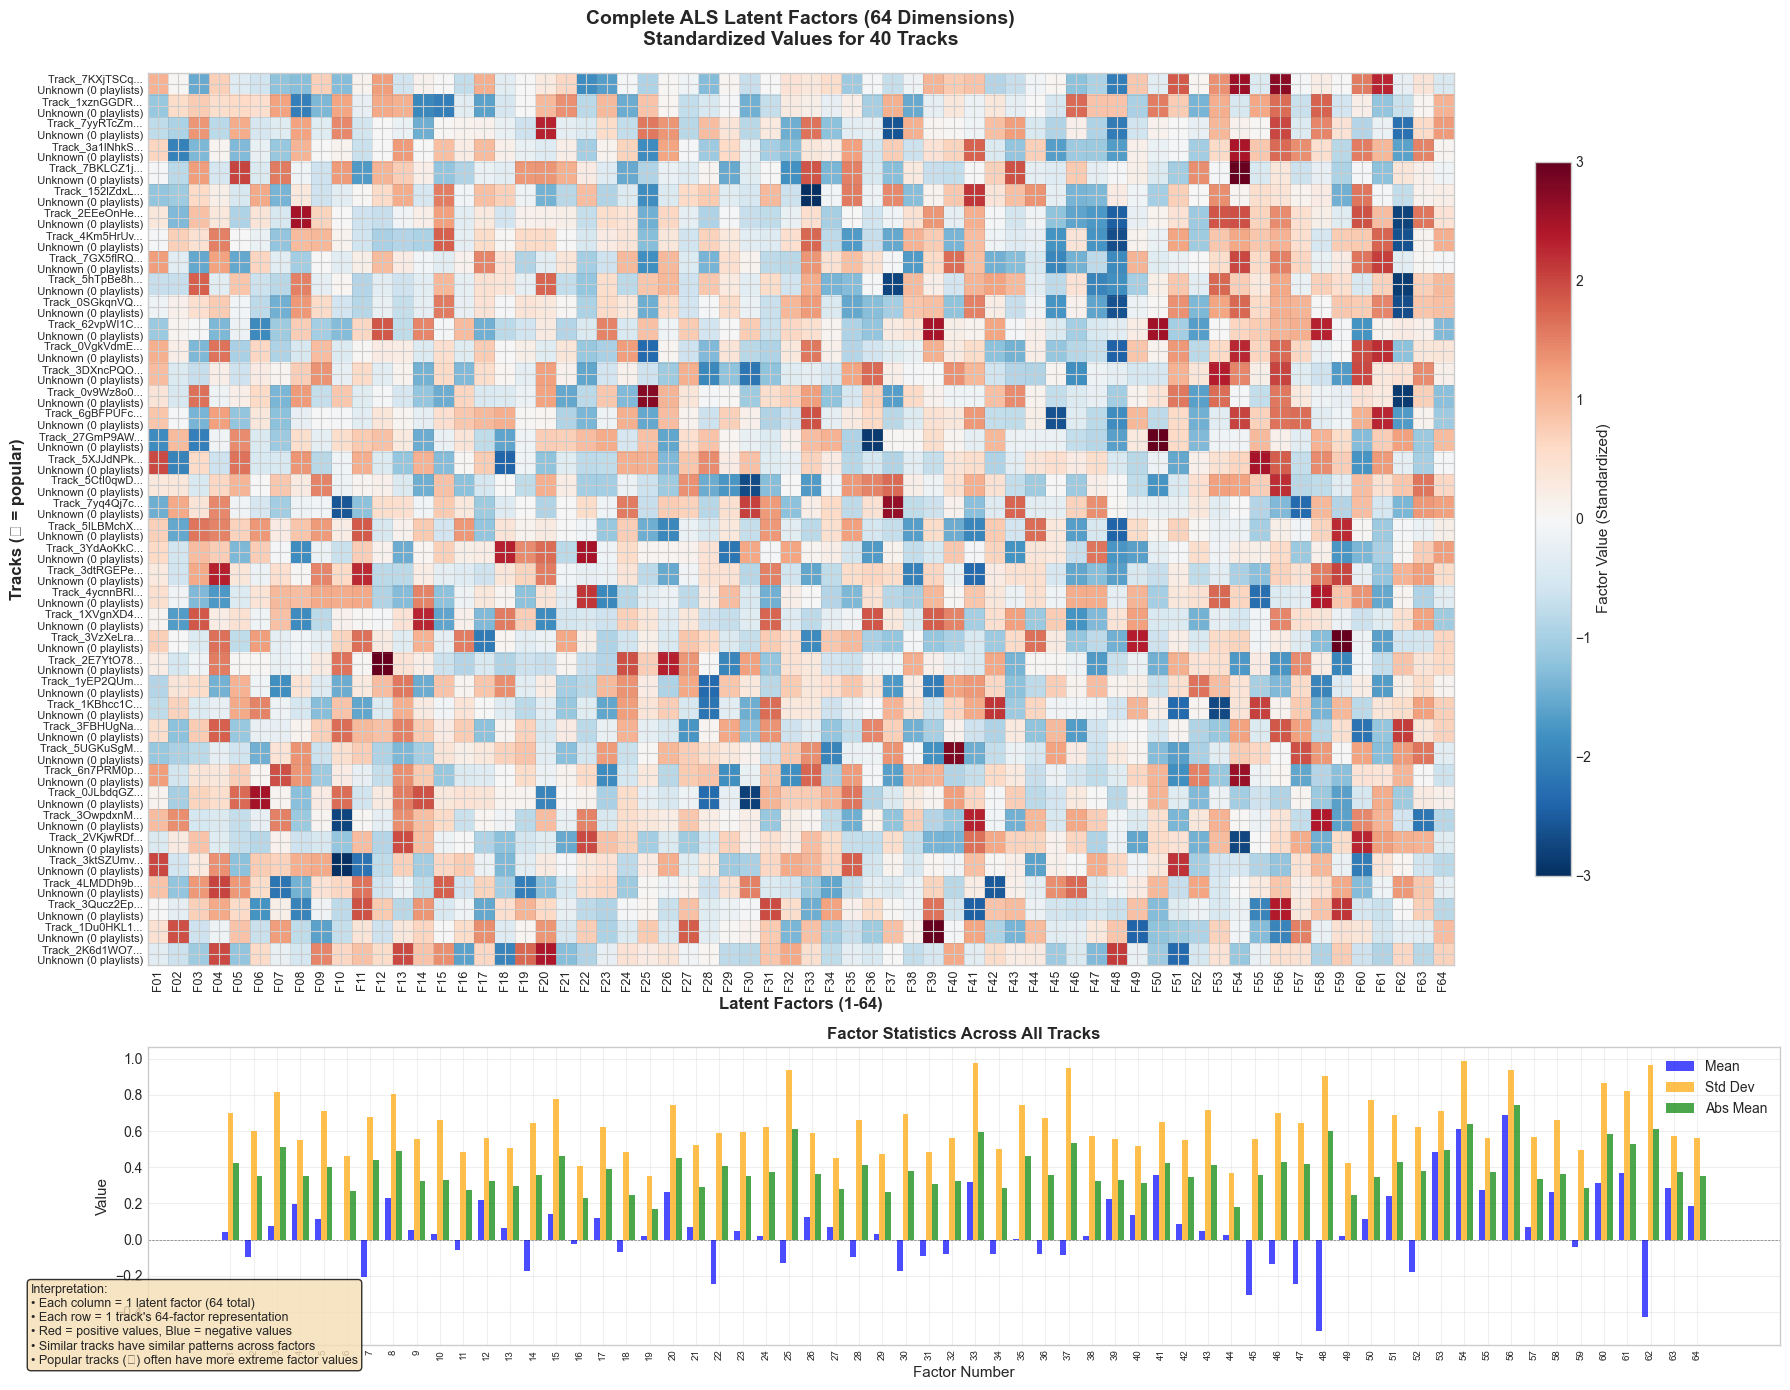


ALS FACTOR ANALYSIS SUMMARY
Total factors: 64
Total tracks in model: 401,373
Factor value range: [-3.885, 3.795]
Average factor magnitude: 0.006

Top 5 most variable factors (most informative):
  Factor 55: variance=0.0015, mean=-0.002
  Factor  1: variance=0.0015, mean=0.000
  Factor 23: variance=0.0014, mean=0.000
  Factor 27: variance=0.0014, mean=0.000
  Factor  4: variance=0.0014, mean=0.002


In [31]:
def visualize_all_64_factors(n_tracks=40, normalize=True, random_state=42):
    """
    Visualize ALL 64 ALS factors for selected tracks.
    Shows the complete latent representation.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Option A: Use top tracks by popularity
    track_counts = train_df['track_id'].value_counts()
    top_tracks = track_counts.head(n_tracks).index.tolist()
    
    # Option B: Or sample diverse tracks for better representation
    # Let's do a mix: 20 popular + 20 random for diversity
    rng = np.random.default_rng(random_state)
    popular_tracks = track_counts.head(20).index.tolist()
    
    # Get random tracks (excluding top 100 to avoid duplicates)
    all_track_ids = train_df['track_id'].unique()
    non_top_tracks = [tid for tid in all_track_ids if tid not in track_counts.head(100).index]
    random_tracks = rng.choice(non_top_tracks, size=min(20, len(non_top_tracks)), replace=False)
    
    selected_tracks = list(popular_tracks) + list(random_tracks)
    
    # Get track indices and factor values
    track_indices = [tid_to_idx[tid] for tid in selected_tracks if tid in tid_to_idx]
    if not track_indices:
        print("No tracks found in training data")
        return None
    
    # Get ALL 64 factors for these tracks
    factor_matrix = track_factors[track_indices, :]  # shape: (n_tracks, 64)
    
    # Get detailed track info for labels
    track_info = []
    for tid in selected_tracks:
        if tid in meta_simple.index:
            name = meta_simple.loc[tid, 'track_name']
            artist = meta_simple.loc[tid, 'artist_name']
            # Count how many playlists this track appears in
            playlist_count = train_df[train_df['track_id'] == tid]['pid'].nunique()
            track_info.append({
                'id': tid,
                'name': name[:40] + '...' if len(name) > 40 else name,
                'artist': artist[:20] + '...' if len(artist) > 20 else artist,
                'playlists': playlist_count,
                'is_popular': tid in popular_tracks
            })
        else:
            track_info.append({
                'id': tid,
                'name': f'Track_{tid[:8]}...',
                'artist': 'Unknown',
                'playlists': 0,
                'is_popular': False
            })
    
    # Create labels with names, artists, and popularity
    y_labels = []
    for info in track_info:
        popularity_star = "★ " if info['is_popular'] else "  "
        y_labels.append(f"{popularity_star}{info['name']}\n  {info['artist']} ({info['playlists']} playlists)")
    
    # Normalize for visualization (column-wise)
    if normalize:
        scaler = StandardScaler()
        display_matrix = scaler.fit_transform(factor_matrix.T).T  # Standardize each factor column
        norm_text = "Standardized"
    else:
        display_matrix = factor_matrix
        norm_text = "Raw"
    
    # Create the figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14), 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # 1. MAIN HEATMAP: All 64 factors
    im = ax1.imshow(display_matrix, aspect='auto', cmap='RdBu_r', 
                   interpolation='nearest', vmin=-3 if normalize else -2, 
                   vmax=3 if normalize else 2)
    
    # Set x-ticks (factors)
    ax1.set_xticks(range(64))
    ax1.set_xticklabels([f'F{i+1:02d}' for i in range(64)], 
                       rotation=90, fontsize=9)
    ax1.set_xlabel('Latent Factors (1-64)', fontsize=12, fontweight='bold')
    
    # Set y-ticks (tracks)
    ax1.set_yticks(range(len(y_labels)))
    ax1.set_yticklabels(y_labels, fontsize=8)
    ax1.set_ylabel('Tracks (★ = popular)', fontsize=12, fontweight='bold')
    
    # Colorbar for heatmap
    cbar = fig.colorbar(im, ax=ax1, shrink=0.8)
    cbar.set_label(f'Factor Value ({norm_text})', fontsize=11)
    
    # Add grid lines between factors
    ax1.set_xticks(np.arange(-0.5, 64, 1), minor=True)
    ax1.set_yticks(np.arange(-0.5, len(y_labels), 1), minor=True)
    ax1.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    
    ax1.set_title(f'Complete ALS Latent Factors (64 Dimensions)\n{norm_text} Values for {len(selected_tracks)} Tracks', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # 2. BOTTOM PLOT: Factor statistics
    # Calculate statistics for each factor
    factor_means = np.mean(factor_matrix, axis=0)
    factor_stds = np.std(factor_matrix, axis=0)
    factor_abs_means = np.mean(np.abs(factor_matrix), axis=0)
    
    x_pos = np.arange(64)
    bar_width = 0.25
    
    # Plot 3 bars for each factor
    ax2.bar(x_pos - bar_width, factor_means, width=bar_width, 
           alpha=0.7, label='Mean', color='blue')
    ax2.bar(x_pos, factor_stds, width=bar_width, 
           alpha=0.7, label='Std Dev', color='orange')
    ax2.bar(x_pos + bar_width, factor_abs_means, width=bar_width, 
           alpha=0.7, label='Abs Mean', color='green')
    
    ax2.set_xlabel('Factor Number', fontsize=11)
    ax2.set_ylabel('Value', fontsize=11)
    ax2.set_title('Factor Statistics Across All Tracks', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(64))
    ax2.set_xticklabels([f'{i+1}' for i in range(64)], rotation=90, fontsize=7)
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Add horizontal line at 0 for reference
    ax2.axhline(y=0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    
    # Add text box with interpretation
    interpretation = (
        "Interpretation:\n"
        "• Each column = 1 latent factor (64 total)\n"
        "• Each row = 1 track's 64-factor representation\n"
        "• Red = positive values, Blue = negative values\n"
        "• Similar tracks have similar patterns across factors\n"
        "• Popular tracks (★) often have more extreme factor values"
    )
    fig.text(0.02, 0.02, interpretation, fontsize=9, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='bottom')
    
    return fig, factor_matrix, track_info

# Generate the visualization
fig, factor_matrix, track_info = visualize_all_64_factors(n_tracks=40, normalize=True)
plt.show()

# Print some statistics
print("\n" + "="*70)
print("ALS FACTOR ANALYSIS SUMMARY")
print("="*70)
print(f"Total factors: {track_factors.shape[1]}")
print(f"Total tracks in model: {track_factors.shape[0]:,}")
print(f"Factor value range: [{track_factors.min():.3f}, {track_factors.max():.3f}]")
print(f"Average factor magnitude: {np.mean(np.abs(track_factors)):.3f}")

# Show factor ranges
print("\nTop 5 most variable factors (most informative):")
factor_variances = np.var(track_factors, axis=0)
top_factors = np.argsort(-factor_variances)[:5]
for i, factor_idx in enumerate(top_factors):
    var = factor_variances[factor_idx]
    mean = np.mean(track_factors[:, factor_idx])
    print(f"  Factor {factor_idx+1:2d}: variance={var:.4f}, mean={mean:.3f}")

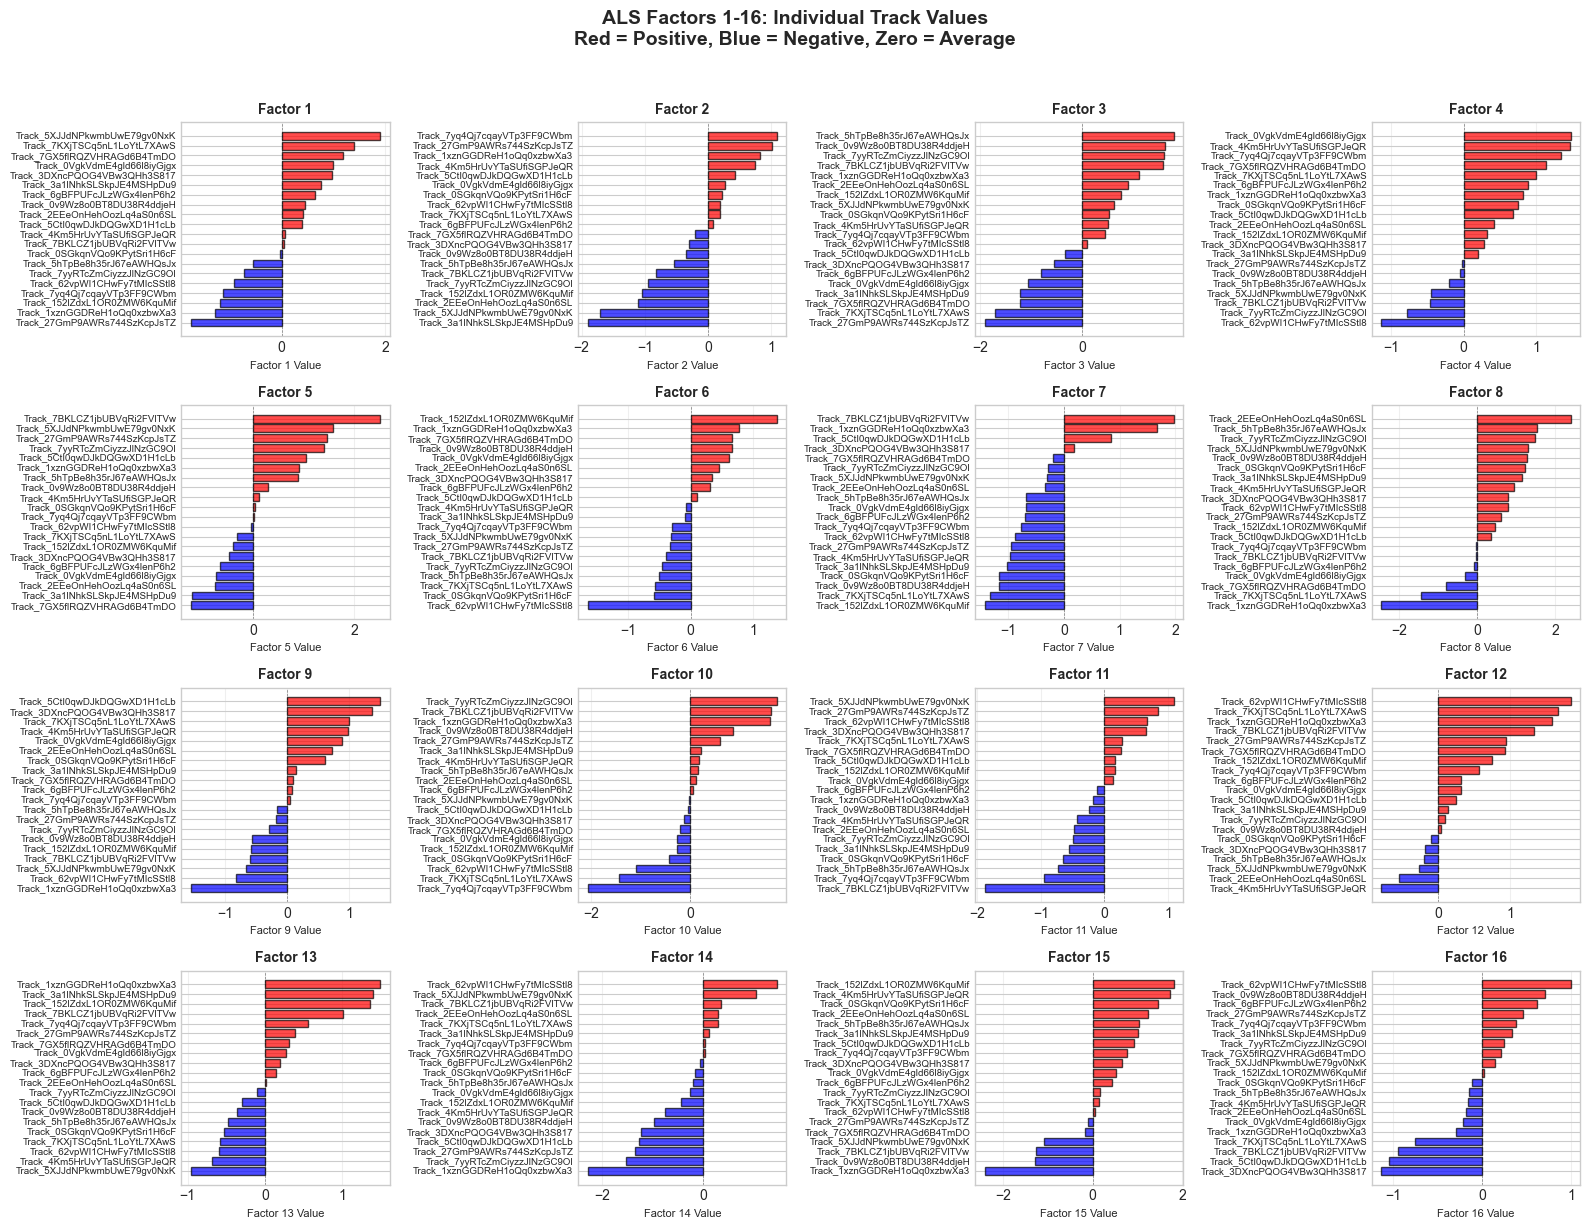

In [32]:
def visualize_factors_individually(n_tracks=25, factors_to_show=16):
    """
    Show selected factors individually for easier interpretation.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get top tracks
    track_counts = train_df['track_id'].value_counts()
    top_tracks = track_counts.head(n_tracks).index.tolist()
    track_indices = [tid_to_idx[tid] for tid in top_tracks if tid in tid_to_idx]
    
    # Get factor matrix
    factor_matrix = track_factors[track_indices, :factors_to_show]
    
    # Get track names
    track_names = []
    for tid in top_tracks:
        if tid in meta_simple.index:
            name = meta_simple.loc[tid, 'track_name'][:25]
            artist = meta_simple.loc[tid, 'artist_name'][:15]
            track_names.append(f"{name}\n({artist})")
        else:
            track_names.append(f"Track_{tid}")
    
    # Create subplot grid
    n_cols = 4
    n_rows = (factors_to_show + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.flatten()
    
    # Plot each factor separately
    for factor_idx in range(factors_to_show):
        ax = axes[factor_idx]
        
        # Get values for this factor
        values = factor_matrix[:, factor_idx]
        
        # Sort tracks by this factor's value
        sort_idx = np.argsort(values)
        sorted_values = values[sort_idx]
        sorted_names = [track_names[i] for i in sort_idx]
        
        # Create bar plot
        bars = ax.barh(range(len(sorted_values)), sorted_values, 
                      color=np.where(sorted_values >= 0, 'red', 'blue'),
                      alpha=0.7, edgecolor='black')
        
        # Labels and formatting
        ax.set_yticks(range(len(sorted_names)))
        ax.set_yticklabels(sorted_names, fontsize=7)
        ax.set_xlabel(f'Factor {factor_idx+1} Value', fontsize=8)
        ax.set_title(f'Factor {factor_idx+1}', fontsize=10, fontweight='bold')
        ax.axvline(x=0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3, axis='x')
    
    # Hide unused subplots
    for i in range(factors_to_show, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'ALS Factors 1-{factors_to_show}: Individual Track Values\n'
                f'Red = Positive, Blue = Negative, Zero = Average', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    return fig

# Show first 16 factors
fig = visualize_factors_individually(n_tracks=20, factors_to_show=16)
plt.show()

C:\Users\Kiera\AppData\Local\Temp\ipykernel_40032\447369295.py:158: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()



TRACKS VISUALIZED (with actual names):
 1. ★ HUMBLE.                                  - Kendrick Lamar                 (in 1818 playlists)
 2. ★ One Dance                                - Drake                          (in 1668 playlists)
 3. ★ Broccoli (feat. Lil Yachty)              - DRAM                           (in 1638 playlists)
 4. ★ Congratulations                          - Post Malone                    (in 1595 playlists)
 5. ★ Closer                                   - The Chainsmokers               (in 1564 playlists)
 6. ★ Location                                 - Khalid                         (in 1405 playlists)
 7. ★ iSpy (feat. Lil Yachty)                  - KYLE                           (in 1402 playlists)
 8. ★ Bad and Boujee (feat. Lil Uzi Vert)      - Migos                          (in 1357 playlists)
 9. ★ XO TOUR Llif3                            - Lil Uzi Vert                   (in 1336 playlists)
10. ★ Caroline                                 - Aminé      

c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


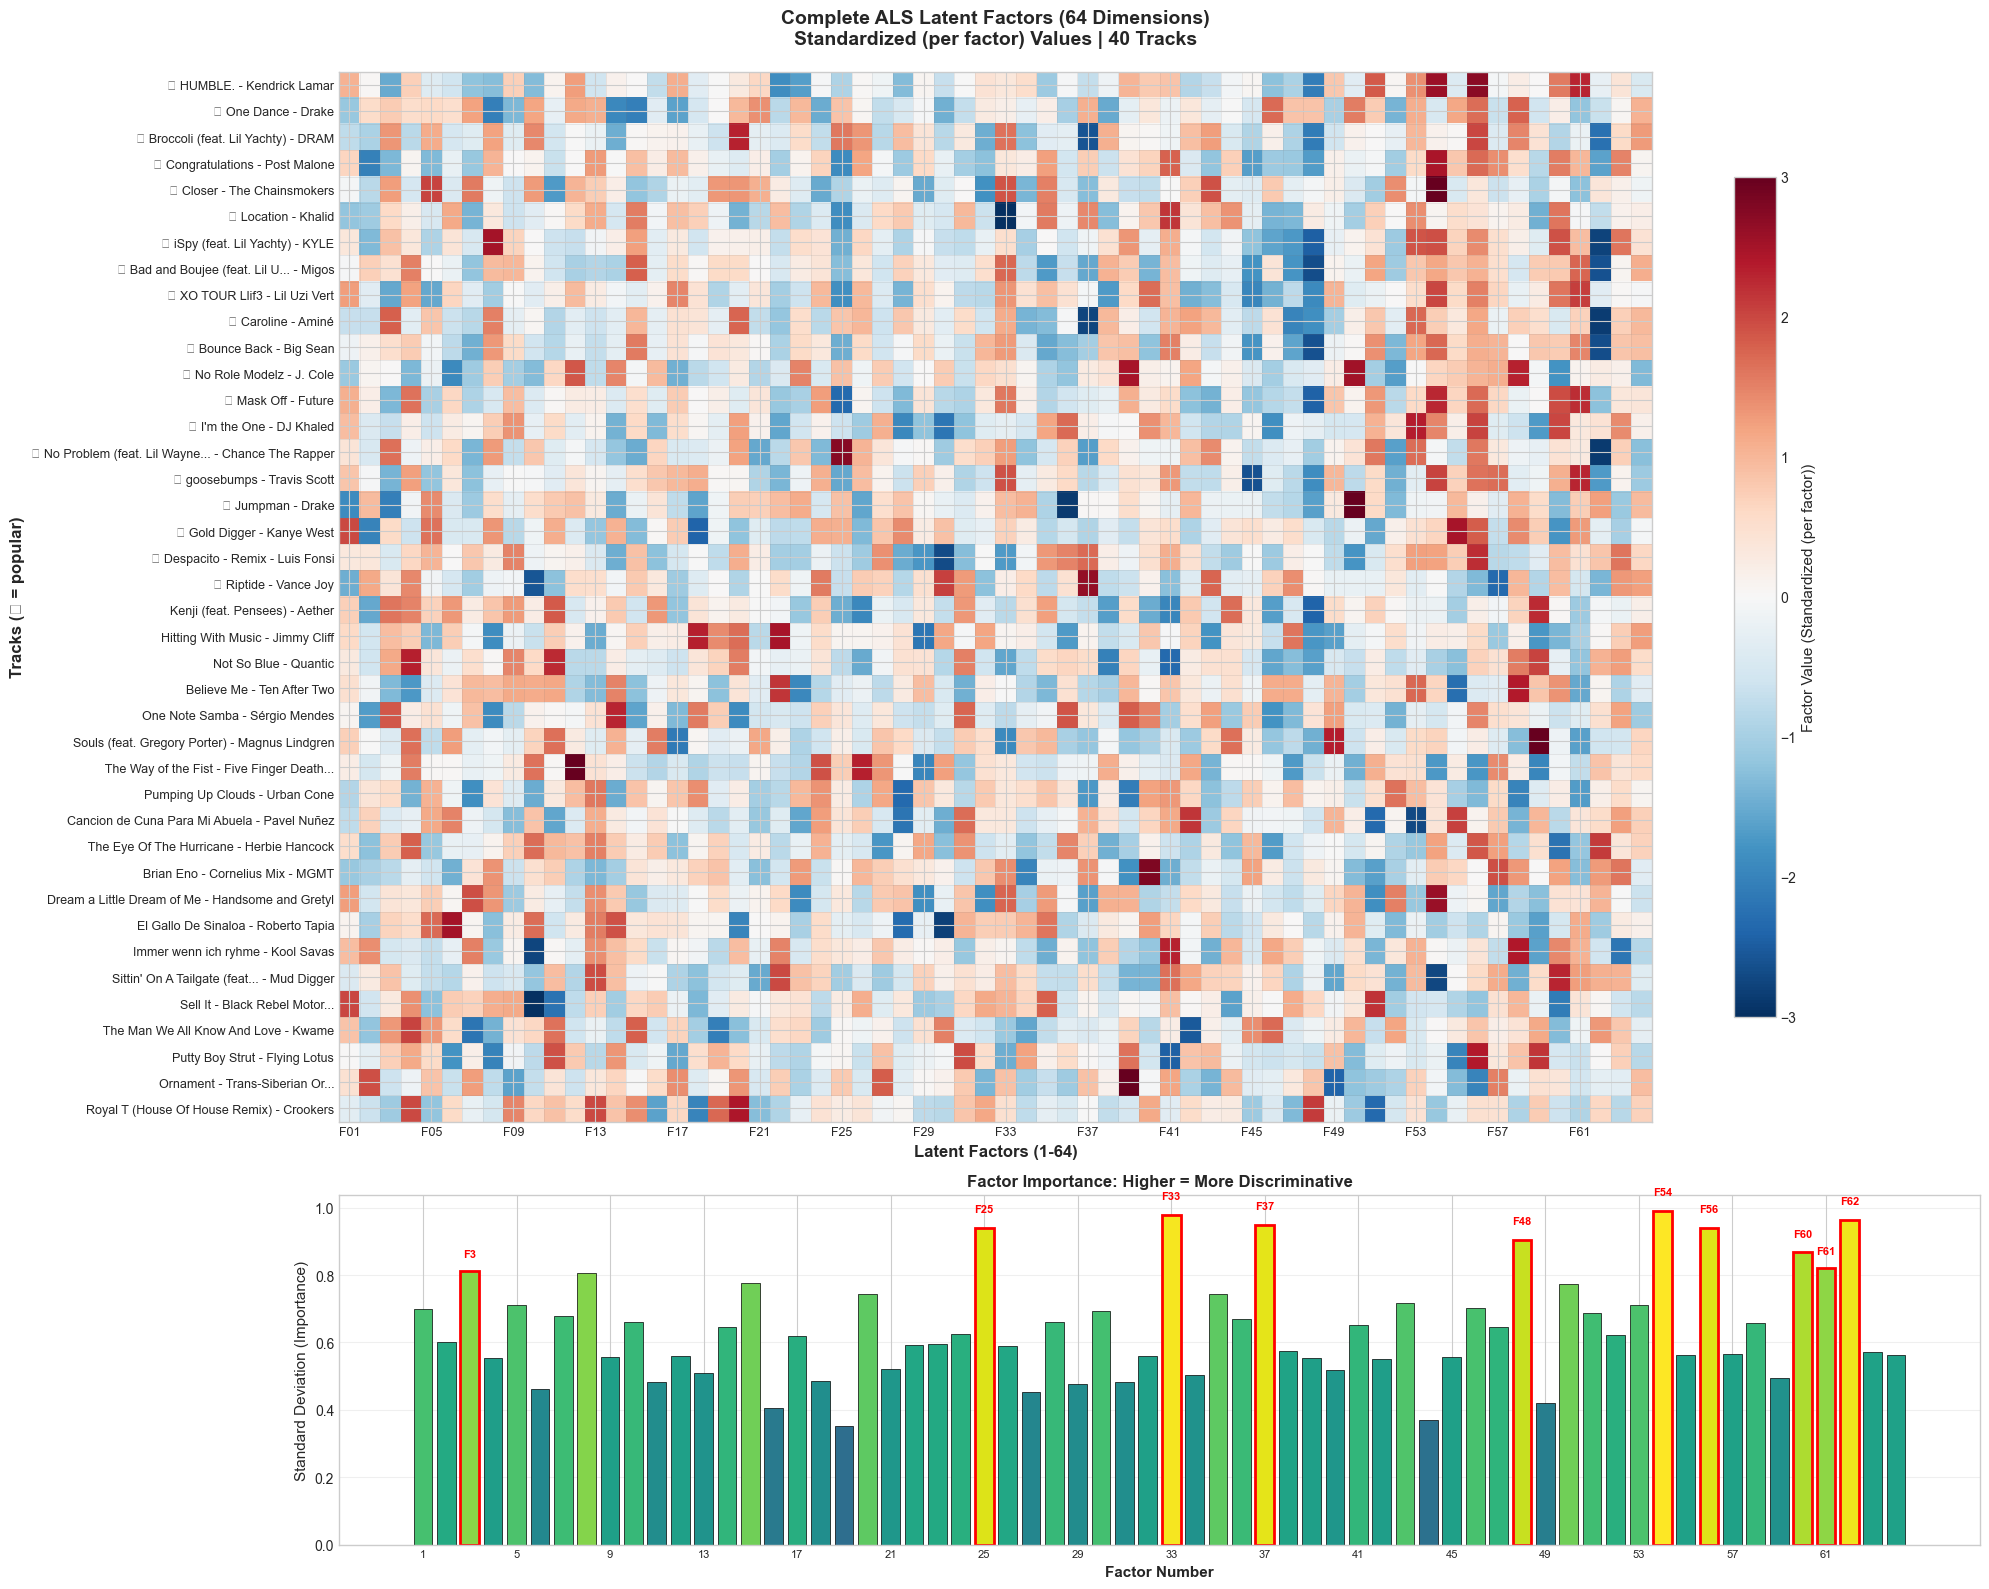

In [33]:
def visualize_all_64_factors_with_names(n_tracks=40, normalize=True, random_state=42):
    """
    Visualize ALL 64 ALS factors with proper track names and artists.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Get a mix of popular and diverse tracks
    track_counts = train_df['track_id'].value_counts()
    
    # Option 1: Take top 20 most popular tracks
    popular_tracks = track_counts.head(20).index.tolist()
    
    # Option 2: Get 20 diverse random tracks (excluding top 100)
    all_track_ids = train_df['track_id'].unique()
    non_top_tracks = [tid for tid in all_track_ids if tid not in track_counts.head(100).index]
    
    if len(non_top_tracks) >= 20:
        rng = np.random.default_rng(random_state)
        random_tracks = rng.choice(non_top_tracks, size=20, replace=False)
    else:
        random_tracks = non_top_tracks
    
    selected_tracks = list(popular_tracks) + list(random_tracks)
    
    # Get track indices
    track_indices = []
    valid_tracks = []
    for tid in selected_tracks:
        if tid in tid_to_idx:
            track_indices.append(tid_to_idx[tid])
            valid_tracks.append(tid)
    
    if not track_indices:
        print("No tracks found in training data")
        return None
    
    # Get ALL 64 factors for these tracks
    factor_matrix = track_factors[track_indices, :]  # shape: (n_tracks, 64)
    
    # Get track metadata with proper names
    track_info = []
    for i, tid in enumerate(valid_tracks):
        # Try to get from meta_simple (your metadata DataFrame)
        if tid in meta_simple.index:
            name = meta_simple.loc[tid, 'track_name']
            artist = meta_simple.loc[tid, 'artist_name']
        else:
            # Fallback: try to get from track_meta (original CSV)
            matches = track_meta[track_meta['track_id'] == tid]
            if not matches.empty:
                name = matches.iloc[0]['track_name']
                artist = matches.iloc[0]['artist_name']
            else:
                name = f"Unknown Track"
                artist = "Unknown Artist"
        
        # Clean up the names
        name = str(name).strip()
        artist = str(artist).strip()
        
        # Count how many playlists this track appears in
        playlist_count = train_df[train_df['track_id'] == tid]['pid'].nunique()
        
        track_info.append({
            'id': tid,
            'name': name,
            'artist': artist,
            'playlists': playlist_count,
            'is_popular': tid in popular_tracks
        })
    
    # Create clean labels: "Song Name - Artist (popularity)"
    y_labels = []
    for info in track_info:
        popularity_star = "★ " if info['is_popular'] else "  "
        
        # Shorten if too long
        name_display = info['name']
        if len(name_display) > 30:
            name_display = name_display[:27] + "..."
        
        artist_display = info['artist']
        if len(artist_display) > 20:
            artist_display = artist_display[:17] + "..."
        
        y_labels.append(f"{popularity_star}{name_display} - {artist_display}")
    
    # Normalize for visualization
    if normalize:
        scaler = StandardScaler()
        # Standardize each factor (column) separately
        display_matrix = scaler.fit_transform(factor_matrix.T).T
        norm_text = "Standardized (per factor)"
    else:
        display_matrix = factor_matrix
        norm_text = "Raw Values"
    
    # Create the figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16), 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # 1. MAIN HEATMAP: All 64 factors
    im = ax1.imshow(display_matrix, aspect='auto', cmap='RdBu_r', 
                   interpolation='nearest', vmin=-3 if normalize else -2, 
                   vmax=3 if normalize else 2)
    
    # Set x-ticks (factors) - every 4th factor for readability
    ax1.set_xticks(range(0, 64, 4))
    ax1.set_xticklabels([f'F{i+1:02d}' for i in range(0, 64, 4)], 
                       rotation=0, fontsize=9)
    ax1.set_xlabel('Latent Factors (1-64)', fontsize=12, fontweight='bold')
    
    # Set y-ticks (tracks)
    ax1.set_yticks(range(len(y_labels)))
    ax1.set_yticklabels(y_labels, fontsize=9)
    ax1.set_ylabel('Tracks (★ = popular)', fontsize=12, fontweight='bold')
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax1, shrink=0.8)
    cbar.set_label(f'Factor Value ({norm_text})', fontsize=11)
    
    # Add grid
    ax1.set_xticks(np.arange(-0.5, 64, 1), minor=True)
    ax1.set_yticks(np.arange(-0.5, len(y_labels), 1), minor=True)
    ax1.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    
    ax1.set_title(f'Complete ALS Latent Factors (64 Dimensions)\n{norm_text} Values | {len(valid_tracks)} Tracks', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # 2. BOTTOM PLOT: Factor importance
    factor_importance = np.std(factor_matrix, axis=0)  # Standard deviation = importance
    
    colors = plt.cm.viridis(factor_importance / factor_importance.max())
    bars = ax2.bar(range(64), factor_importance, color=colors, edgecolor='black', linewidth=0.5)
    
    # Highlight top 10 most important factors
    top_10_idx = np.argsort(factor_importance)[-10:]
    for idx in top_10_idx:
        bars[idx].set_edgecolor('red')
        bars[idx].set_linewidth(2)
        ax2.text(idx, factor_importance[idx] * 1.05, f'F{idx+1}', 
                ha='center', fontsize=8, fontweight='bold', color='red')
    
    ax2.set_xlabel('Factor Number', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Standard Deviation (Importance)', fontsize=11)
    ax2.set_title('Factor Importance: Higher = More Discriminative', 
                 fontsize=12, fontweight='bold')
    ax2.set_xticks(range(0, 64, 4))
    ax2.set_xticklabels([f'{i+1}' for i in range(0, 64, 4)], fontsize=8)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Add a summary table
    print("\n" + "="*80)
    print("TRACKS VISUALIZED (with actual names):")
    print("="*80)
    for i, info in enumerate(track_info[:15]):  # Show first 15
        star = "★" if info['is_popular'] else " "
        print(f"{i+1:2d}. {star} {info['name'][:40]:40} - {info['artist'][:30]:30} "
              f"(in {info['playlists']:3d} playlists)")
    
    if len(track_info) > 15:
        print(f"... and {len(track_info)-15} more tracks")
    
    return fig, factor_matrix, track_info

# Generate the visualization
fig, factor_matrix, track_info = visualize_all_64_factors_with_names(
    n_tracks=40, 
    normalize=True
)
plt.show()

C:\Users\Kiera\AppData\Local\Temp\ipykernel_40032\672609827.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



RANK   TRACK NAME                                    ARTIST                         PLAYLISTS
#1     HUMBLE.                                       Kendrick Lamar                    1,818
#2     One Dance                                     Drake                             1,668
#3     Broccoli (feat. Lil Yachty)                   DRAM                              1,638
#4     Congratulations                               Post Malone                       1,595
#5     Closer                                        The Chainsmokers                  1,564
#6     Location                                      Khalid                            1,405
#7     iSpy (feat. Lil Yachty)                       KYLE                              1,402
#8     Bad and Boujee (feat. Lil Uzi Vert)           Migos                             1,357
#9     XO TOUR Llif3                                 Lil Uzi Vert                      1,336
#10    Caroline                                      Aminé          

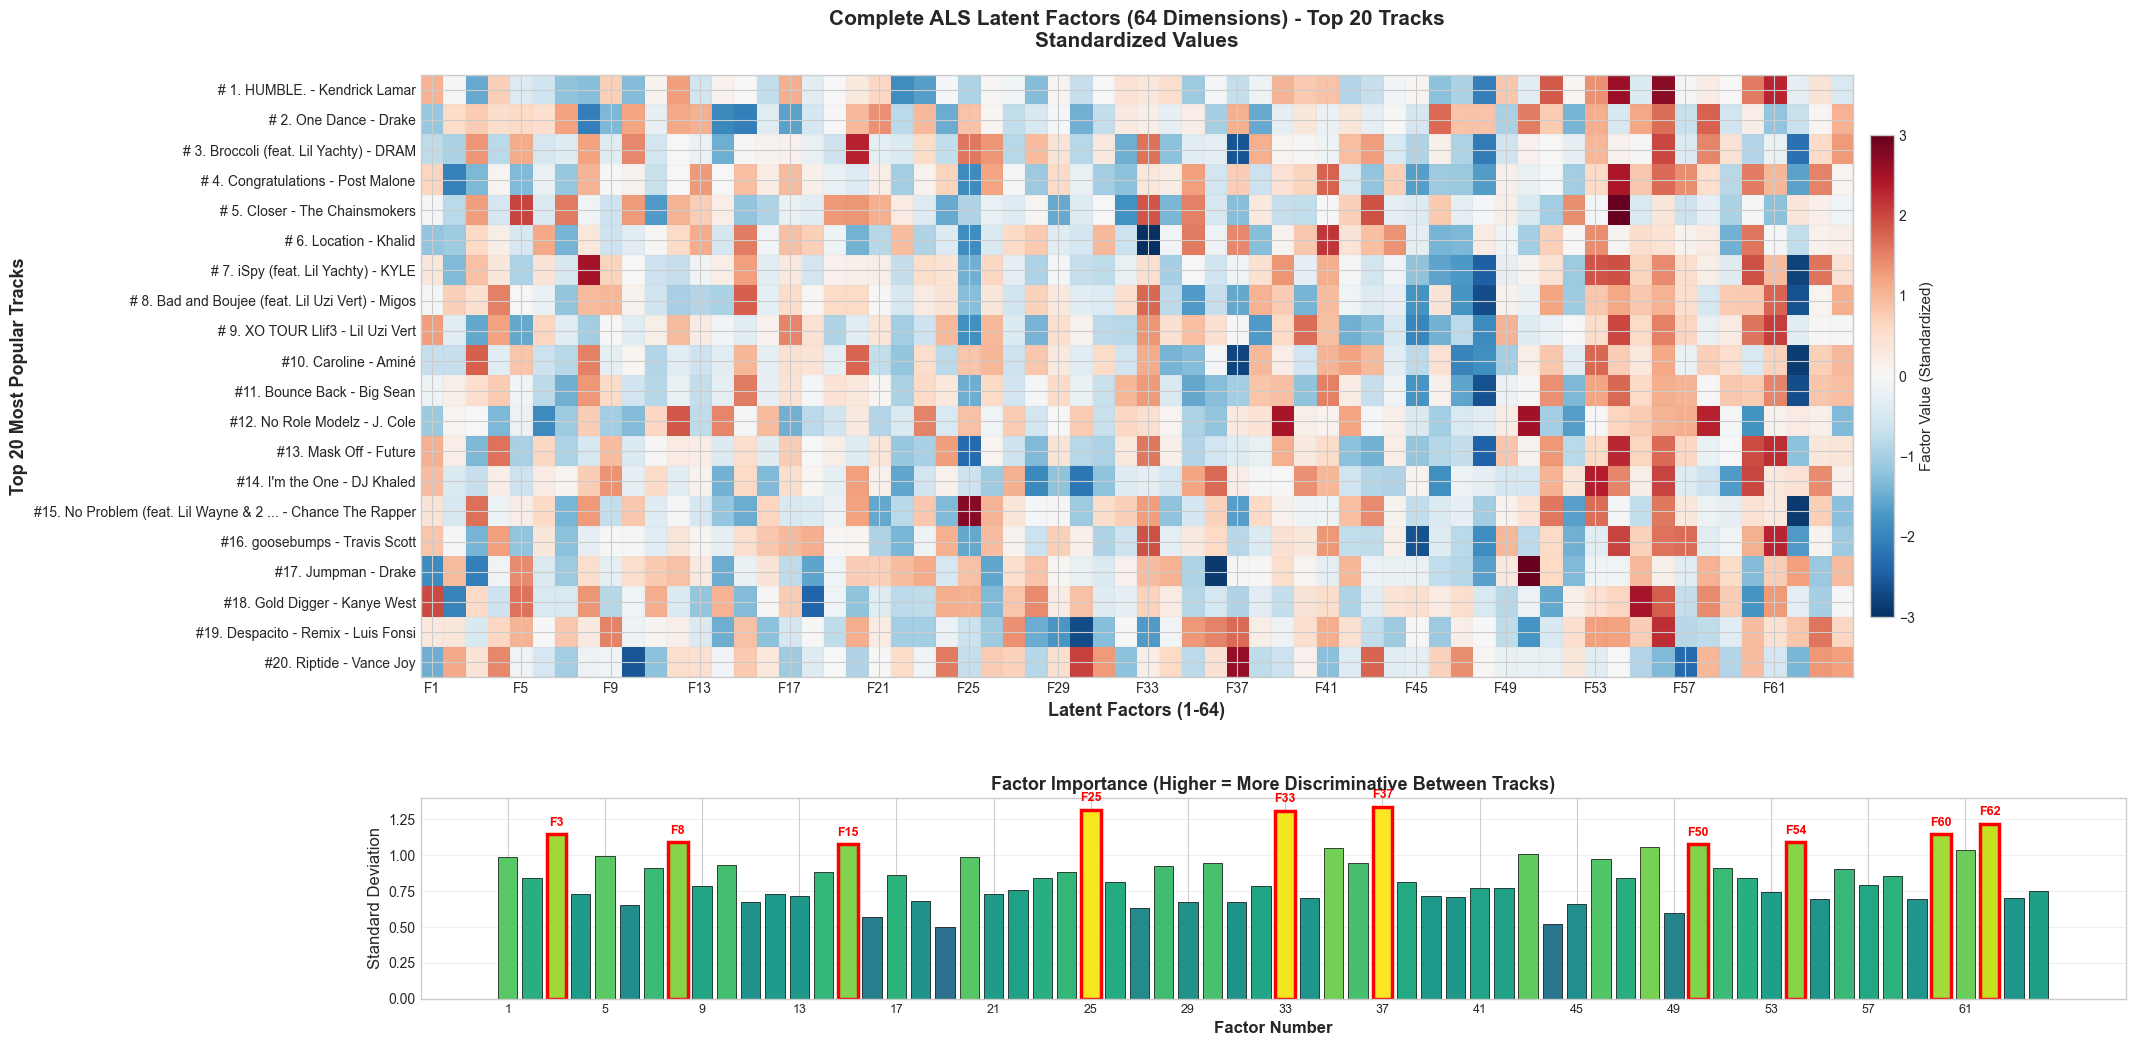

In [34]:
def visualize_top_20_tracks_factors(normalize=True):
    """
    Visualize ALL 64 ALS factors for the top 20 most popular tracks.
    Clean, focused visualization with proper track names and artists.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Get top 20 most popular tracks
    track_counts = train_df['track_id'].value_counts()
    popular_tracks = track_counts.head(20).index.tolist()
    
    # Get track indices
    track_indices = []
    valid_tracks = []
    for tid in popular_tracks:
        if tid in tid_to_idx:
            track_indices.append(tid_to_idx[tid])
            valid_tracks.append(tid)
    
    if not track_indices:
        print("No tracks found in training data")
        return None
    
    # Get ALL 64 factors for these tracks
    factor_matrix = track_factors[track_indices, :]  # shape: (n_tracks, 64)
    
    # Get track metadata with proper names
    track_info = []
    for i, tid in enumerate(valid_tracks):
        # Try to get from meta_simple (your metadata DataFrame)
        if tid in meta_simple.index:
            name = meta_simple.loc[tid, 'track_name']
            artist = meta_simple.loc[tid, 'artist_name']
        else:
            # Fallback: try to get from track_meta (original CSV)
            matches = track_meta[track_meta['track_id'] == tid]
            if not matches.empty:
                name = matches.iloc[0]['track_name']
                artist = matches.iloc[0]['artist_name']
            else:
                name = f"Unknown Track"
                artist = "Unknown Artist"
        
        # Clean up the names
        name = str(name).strip()
        artist = str(artist).strip()
        
        # Count how many playlists this track appears in
        playlist_count = train_df[train_df['track_id'] == tid]['pid'].nunique()
        
        track_info.append({
            'id': tid,
            'name': name,
            'artist': artist,
            'playlists': playlist_count,
            'rank': i + 1
        })
    
    # Create clean labels: "#Rank. Song Name - Artist"
    y_labels = []
    for info in track_info:
        # Shorten if too long
        name_display = info['name']
        if len(name_display) > 35:
            name_display = name_display[:32] + "..."
        
        artist_display = info['artist']
        if len(artist_display) > 25:
            artist_display = artist_display[:22] + "..."
        
        y_labels.append(f"#{info['rank']:2d}. {name_display} - {artist_display}")
    
    # Normalize for visualization
    if normalize:
        scaler = StandardScaler()
        # Standardize each factor (column) separately
        display_matrix = scaler.fit_transform(factor_matrix.T).T
        norm_text = "Standardized"
    else:
        display_matrix = factor_matrix
        norm_text = "Raw Values"
    
    # Create the figure
    fig = plt.figure(figsize=(22, 12))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.3)
    
    # 1. MAIN HEATMAP: All 64 factors
    ax1 = fig.add_subplot(gs[0])
    im = ax1.imshow(display_matrix, aspect='auto', cmap='RdBu_r', 
                   interpolation='nearest', vmin=-3 if normalize else -2, 
                   vmax=3 if normalize else 2)
    
    # Set x-ticks (factors) - every 4th factor for readability
    ax1.set_xticks(range(0, 64, 4))
    ax1.set_xticklabels([f'F{i+1}' for i in range(0, 64, 4)], 
                       rotation=0, fontsize=10)
    ax1.set_xlabel('Latent Factors (1-64)', fontsize=13, fontweight='bold')
    
    # Set y-ticks (tracks)
    ax1.set_yticks(range(len(y_labels)))
    ax1.set_yticklabels(y_labels, fontsize=10)
    ax1.set_ylabel('Top 20 Most Popular Tracks', fontsize=13, fontweight='bold')
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax1, shrink=0.8, pad=0.01)
    cbar.set_label(f'Factor Value ({norm_text})', fontsize=11)
    
    # Add subtle grid
    ax1.set_xticks(np.arange(-0.5, 64, 1), minor=True)
    ax1.set_yticks(np.arange(-0.5, len(y_labels), 1), minor=True)
    ax1.grid(which='minor', color='gray', linestyle='-', linewidth=0.3, alpha=0.15)
    
    ax1.set_title(f'Complete ALS Latent Factors (64 Dimensions) - Top 20 Tracks\n{norm_text} Values', 
                 fontsize=15, fontweight='bold', pad=20)
    
    # 2. BOTTOM PLOT: Factor importance
    ax2 = fig.add_subplot(gs[1])
    factor_importance = np.std(factor_matrix, axis=0)  # Standard deviation = importance
    
    colors = plt.cm.viridis(factor_importance / factor_importance.max())
    bars = ax2.bar(range(64), factor_importance, color=colors, edgecolor='black', linewidth=0.5)
    
    # Highlight top 10 most important factors
    top_10_idx = np.argsort(factor_importance)[-10:]
    for idx in top_10_idx:
        bars[idx].set_edgecolor('red')
        bars[idx].set_linewidth(2.5)
        ax2.text(idx, factor_importance[idx] * 1.05, f'F{idx+1}', 
                ha='center', fontsize=9, fontweight='bold', color='red')
    
    ax2.set_xlabel('Factor Number', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Standard Deviation', fontsize=12)
    ax2.set_title('Factor Importance (Higher = More Discriminative Between Tracks)', 
                 fontsize=13, fontweight='bold')
    ax2.set_xticks(range(0, 64, 4))
    ax2.set_xticklabels([f'{i+1}' for i in range(0, 64, 4)], fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Print summary table
    print("\n" + "="*90)
    print(f"{'RANK':<6} {'TRACK NAME':<45} {'ARTIST':<30} {'PLAYLISTS':>8}")
    print("="*90)
    for info in track_info:
        print(f"#{info['rank']:<5} {info['name'][:44]:<45} {info['artist'][:29]:<30} {info['playlists']:>8,}")
    print("="*90)
    print(f"\nTotal tracks visualized: {len(track_info)}")
    print(f"Total factors shown: 64")
    
    return fig, factor_matrix, track_info

# Generate the visualization
fig, factor_matrix, track_info = visualize_top_20_tracks_factors(normalize=True)
plt.show()

C:\Users\Kiera\AppData\Local\Temp\ipykernel_40032\1435708080.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



RANK   TRACK NAME                                    ARTIST                         PLAYLISTS
#1     HUMBLE.                                       Kendrick Lamar                    1,818
#2     One Dance                                     Drake                             1,668
#3     Broccoli (feat. Lil Yachty)                   DRAM                              1,638
#4     Congratulations                               Post Malone                       1,595
#5     Closer                                        The Chainsmokers                  1,564
#6     Location                                      Khalid                            1,405
#7     iSpy (feat. Lil Yachty)                       KYLE                              1,402
#8     Bad and Boujee (feat. Lil Uzi Vert)           Migos                             1,357
#9     XO TOUR Llif3                                 Lil Uzi Vert                      1,336
#10    Caroline                                      Aminé          

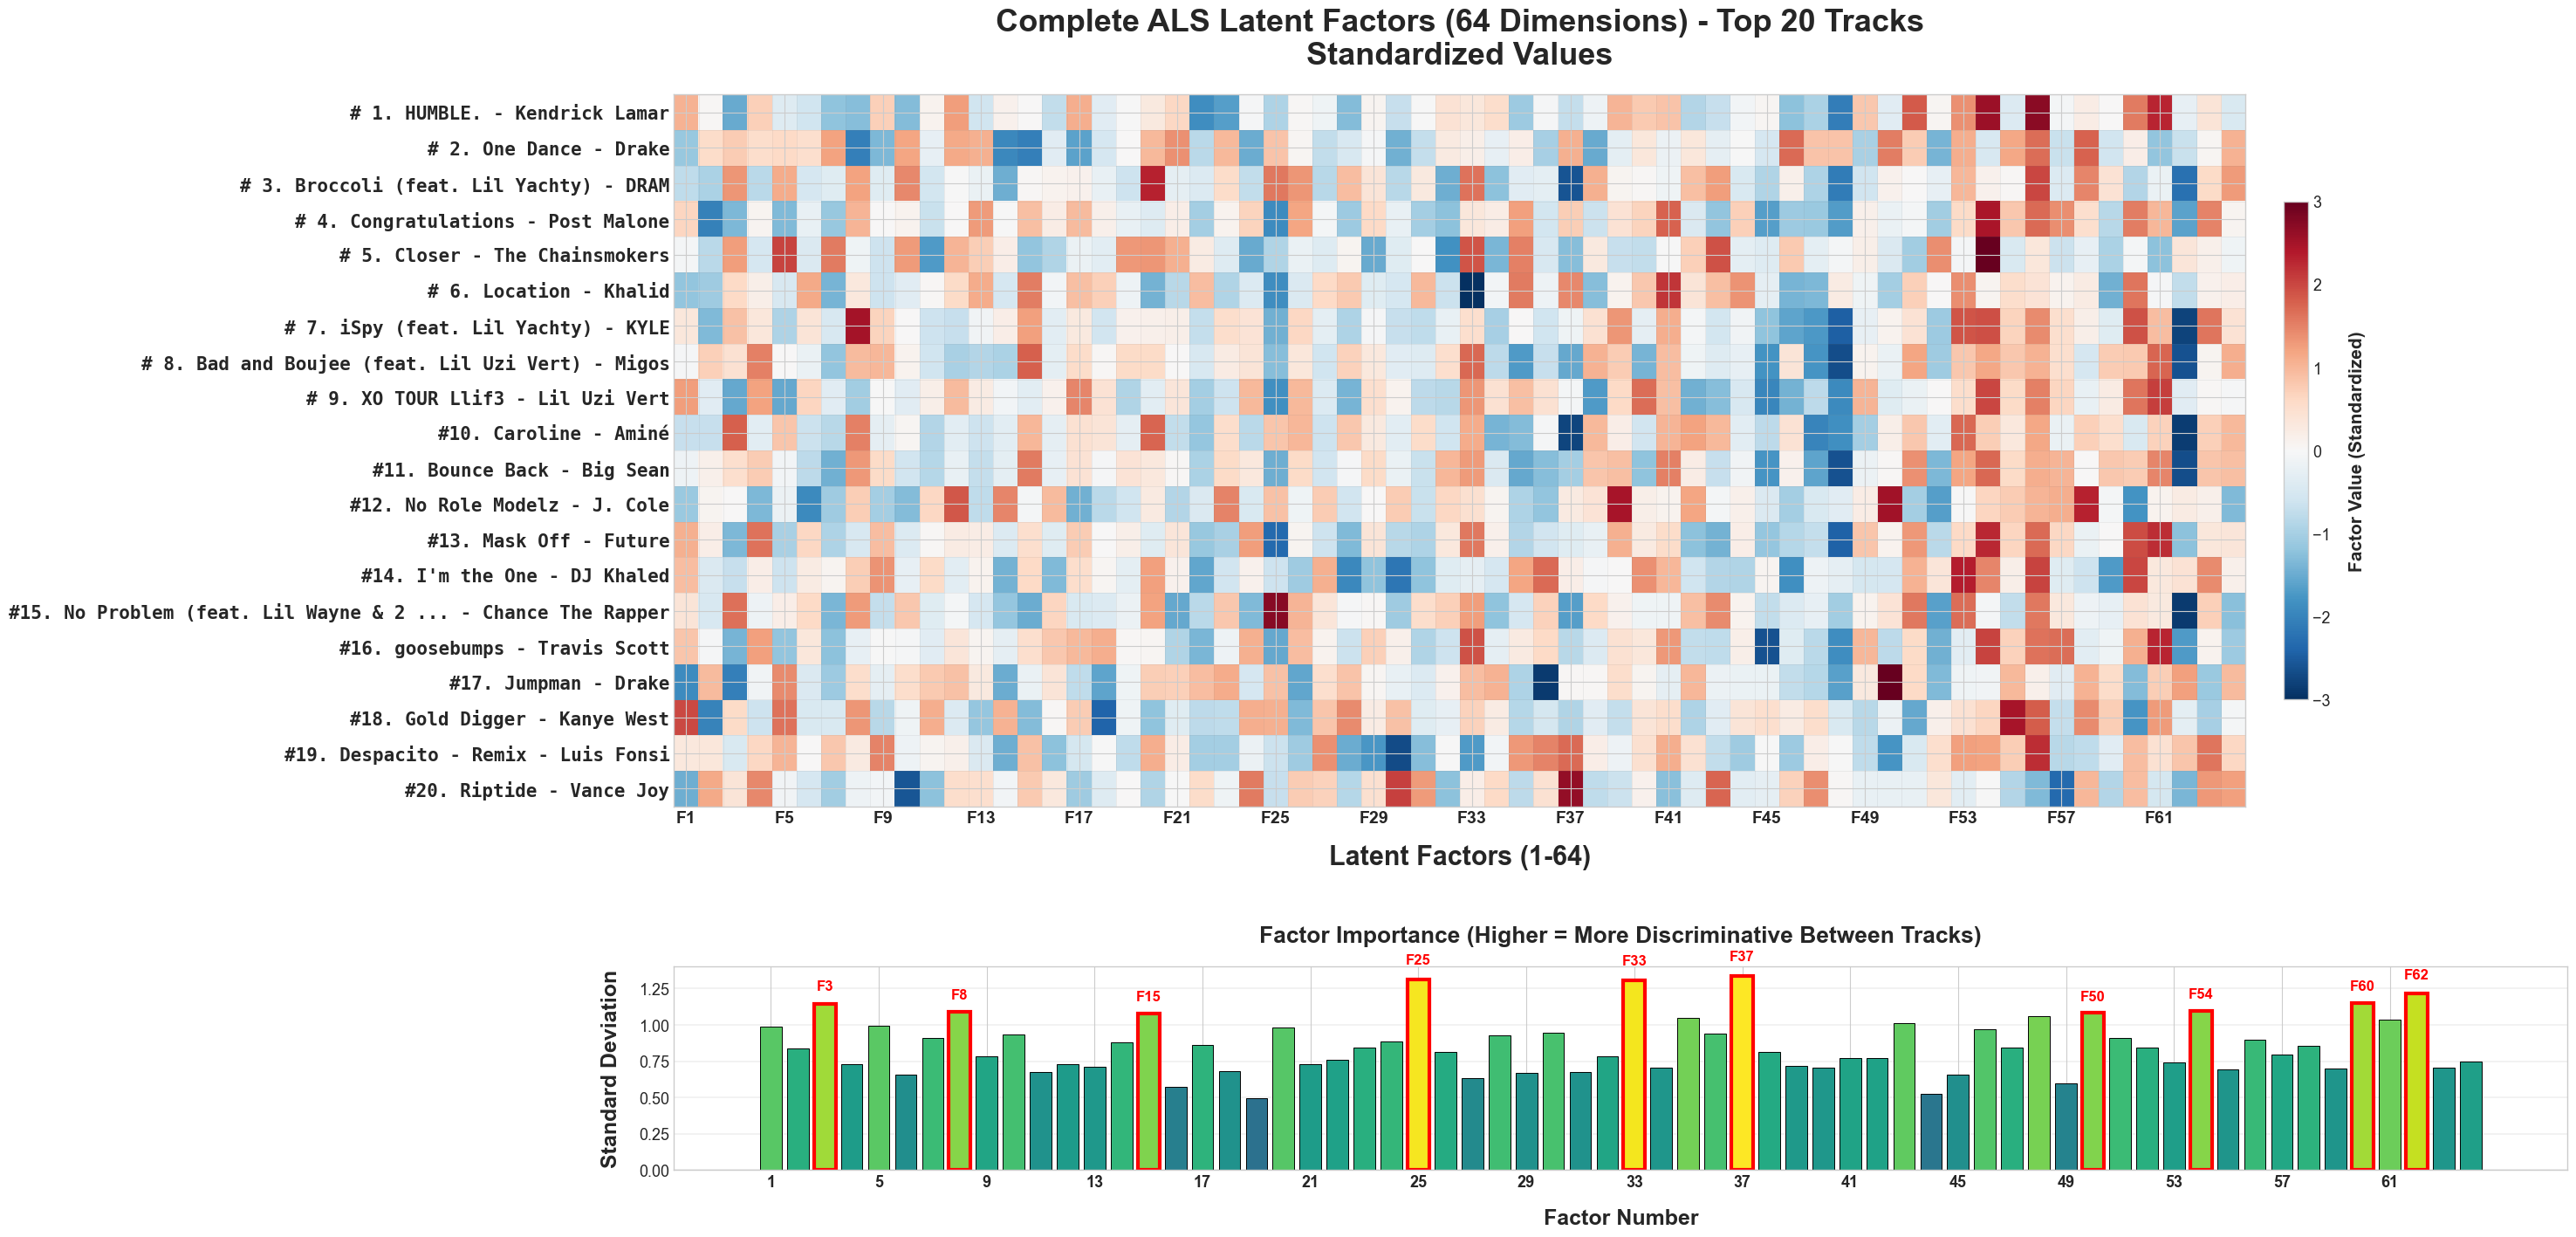

In [35]:
def visualize_top_20_tracks_factors(normalize=True):
    """
    Visualize ALL 64 ALS factors for the top 20 most popular tracks.
    Clean, focused visualization with proper track names and artists.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Get top 20 most popular tracks
    track_counts = train_df['track_id'].value_counts()
    popular_tracks = track_counts.head(20).index.tolist()
    
    # Get track indices
    track_indices = []
    valid_tracks = []
    for tid in popular_tracks:
        if tid in tid_to_idx:
            track_indices.append(tid_to_idx[tid])
            valid_tracks.append(tid)
    
    if not track_indices:
        print("No tracks found in training data")
        return None
    
    # Get ALL 64 factors for these tracks
    factor_matrix = track_factors[track_indices, :]  # shape: (n_tracks, 64)
    
    # Get track metadata with proper names
    track_info = []
    for i, tid in enumerate(valid_tracks):
        # Try to get from meta_simple (your metadata DataFrame)
        if tid in meta_simple.index:
            name = meta_simple.loc[tid, 'track_name']
            artist = meta_simple.loc[tid, 'artist_name']
        else:
            # Fallback: try to get from track_meta (original CSV)
            matches = track_meta[track_meta['track_id'] == tid]
            if not matches.empty:
                name = matches.iloc[0]['track_name']
                artist = matches.iloc[0]['artist_name']
            else:
                name = f"Unknown Track"
                artist = "Unknown Artist"
        
        # Clean up the names
        name = str(name).strip()
        artist = str(artist).strip()
        
        # Count how many playlists this track appears in
        playlist_count = train_df[train_df['track_id'] == tid]['pid'].nunique()
        
        track_info.append({
            'id': tid,
            'name': name,
            'artist': artist,
            'playlists': playlist_count,
            'rank': i + 1
        })
    
    # Create clean labels: "#Rank. Song Name - Artist"
    y_labels = []
    for info in track_info:
        # Shorten if too long
        name_display = info['name']
        if len(name_display) > 35:
            name_display = name_display[:32] + "..."
        
        artist_display = info['artist']
        if len(artist_display) > 25:
            artist_display = artist_display[:22] + "..."
        
        y_labels.append(f"#{info['rank']:2d}. {name_display} - {artist_display}")
    
    # Normalize for visualization
    if normalize:
        scaler = StandardScaler()
        # Standardize each factor (column) separately
        display_matrix = scaler.fit_transform(factor_matrix.T).T
        norm_text = "Standardized"
    else:
        display_matrix = factor_matrix
        norm_text = "Raw Values"
    
    # Create the figure - MUCH LARGER for readability
    fig = plt.figure(figsize=(28, 16))
    gs = fig.add_gridspec(2, 1, height_ratios=[3.5, 1], hspace=0.35)
    
    # 1. MAIN HEATMAP: All 64 factors
    ax1 = fig.add_subplot(gs[0])
    im = ax1.imshow(display_matrix, aspect='auto', cmap='RdBu_r', 
                   interpolation='nearest', vmin=-3 if normalize else -2, 
                   vmax=3 if normalize else 2)
    
    # Set x-ticks (factors) - every 4th factor for readability
    ax1.set_xticks(range(0, 64, 4))
    ax1.set_xticklabels([f'F{i+1}' for i in range(0, 64, 4)], 
                       rotation=0, fontsize=14, fontweight='bold')
    ax1.set_xlabel('Latent Factors (1-64)', fontsize=22, fontweight='bold', labelpad=15)
    
    # Set y-ticks (tracks) - LARGER text
    ax1.set_yticks(range(len(y_labels)))
    ax1.set_yticklabels(y_labels, fontsize=15, family='monospace', fontweight='bold')
    #ax1.set_ylabel('Top 20 Most Popular Tracks', fontsize=24, fontweight='bold', labelpad=15)
    
    # Colorbar - LARGER
    cbar = fig.colorbar(im, ax=ax1, shrink=0.7, pad=0.02)
    cbar.set_label(f'Factor Value ({norm_text})', fontsize=15, fontweight='bold', labelpad=15)
    cbar.ax.tick_params(labelsize=13)
    
    # Add subtle grid
    ax1.set_xticks(np.arange(-0.5, 64, 1), minor=True)
    ax1.set_yticks(np.arange(-0.5, len(y_labels), 1), minor=True)
    ax1.grid(which='minor', color='gray', linestyle='-', linewidth=0.4, alpha=0.2)
    
    ax1.set_title(f'Complete ALS Latent Factors (64 Dimensions) - Top 20 Tracks\n{norm_text} Values', 
                 fontsize=26, fontweight='bold', pad=25)
    
    # 2. BOTTOM PLOT: Factor importance - LARGER text
    ax2 = fig.add_subplot(gs[1])
    factor_importance = np.std(factor_matrix, axis=0)  # Standard deviation = importance
    
    colors = plt.cm.viridis(factor_importance / factor_importance.max())
    bars = ax2.bar(range(64), factor_importance, color=colors, edgecolor='black', linewidth=0.7)
    
    # Highlight top 10 most important factors - MORE VISIBLE
    top_10_idx = np.argsort(factor_importance)[-10:]
    for idx in top_10_idx:
        bars[idx].set_edgecolor('red')
        bars[idx].set_linewidth(3)
        ax2.text(idx, factor_importance[idx] * 1.08, f'F{idx+1}', 
                ha='center', fontsize=12, fontweight='bold', color='red')
    
    ax2.set_xlabel('Factor Number', fontsize=18, fontweight='bold', labelpad=15)
    ax2.set_ylabel('Standard Deviation', fontsize=18, fontweight='bold', labelpad=15)
    ax2.set_title('Factor Importance (Higher = More Discriminative Between Tracks)', 
                 fontsize=19, fontweight='bold', pad=20)
    ax2.set_xticks(range(0, 64, 4))
    ax2.set_xticklabels([f'{i+1}' for i in range(0, 64, 4)], fontsize=13, fontweight='bold')
    ax2.tick_params(axis='y', labelsize=13)
    ax2.grid(True, alpha=0.3, axis='y', linewidth=1.2)
    
    plt.tight_layout()
    
    # Print summary table
    print("\n" + "="*90)
    print(f"{'RANK':<6} {'TRACK NAME':<45} {'ARTIST':<30} {'PLAYLISTS':>8}")
    print("="*90)
    for info in track_info:
        print(f"#{info['rank']:<5} {info['name'][:44]:<45} {info['artist'][:29]:<30} {info['playlists']:>8,}")
    print("="*90)
    print(f"\nTotal tracks visualized: {len(track_info)}")
    print(f"Total factors shown: 64")
    
    return fig, factor_matrix, track_info

# Generate the visualization
fig, factor_matrix, track_info = visualize_top_20_tracks_factors(normalize=True)
plt.show()

In [36]:
def visualize_top_20_tracks_heatmap(normalize=True):
    """
    Visualize ALL 64 ALS factors for the top 20 most popular tracks - HEATMAP ONLY.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Get top 20 most popular tracks
    track_counts = train_df['track_id'].value_counts()
    popular_tracks = track_counts.head(20).index.tolist()
    
    # Get track indices
    track_indices = []
    valid_tracks = []
    for tid in popular_tracks:
        if tid in tid_to_idx:
            track_indices.append(tid_to_idx[tid])
            valid_tracks.append(tid)
    
    if not track_indices:
        print("No tracks found in training data")
        return None
    
    # Get ALL 64 factors for these tracks
    factor_matrix = track_factors[track_indices, :]  # shape: (n_tracks, 64)
    
    # Get track metadata with proper names
    track_info = []
    for i, tid in enumerate(valid_tracks):
        # Try to get from meta_simple (your metadata DataFrame)
        if tid in meta_simple.index:
            name = meta_simple.loc[tid, 'track_name']
            artist = meta_simple.loc[tid, 'artist_name']
        else:
            # Fallback: try to get from track_meta (original CSV)
            matches = track_meta[track_meta['track_id'] == tid]
            if not matches.empty:
                name = matches.iloc[0]['track_name']
                artist = matches.iloc[0]['artist_name']
            else:
                name = f"Unknown Track"
                artist = "Unknown Artist"
        
        # Clean up the names
        name = str(name).strip()
        artist = str(artist).strip()
        
        # Count how many playlists this track appears in
        playlist_count = train_df[train_df['track_id'] == tid]['pid'].nunique()
        
        track_info.append({
            'id': tid,
            'name': name,
            'artist': artist,
            'playlists': playlist_count,
            'rank': i + 1
        })
    
    # Create clean labels: "#Rank. Song Name - Artist"
    y_labels = []
    for info in track_info:
        # Shorten if too long
        name_display = info['name']
        if len(name_display) > 35:
            name_display = name_display[:32] + "..."
        
        artist_display = info['artist']
        if len(artist_display) > 25:
            artist_display = artist_display[:22] + "..."
        
        y_labels.append(f"#{info['rank']:2d}. {name_display} - {artist_display}")
    
    # Normalize for visualization
    if normalize:
        scaler = StandardScaler()
        # Standardize each factor (column) separately
        display_matrix = scaler.fit_transform(factor_matrix.T).T
        norm_text = "Standardized"
    else:
        display_matrix = factor_matrix
        norm_text = "Raw Values"
    
    # Create the heatmap figure
    fig, ax1 = plt.subplots(figsize=(28, 14))
    
    # MAIN HEATMAP: All 64 factors
    im = ax1.imshow(display_matrix, aspect='auto', cmap='RdBu_r', 
                   interpolation='nearest', vmin=-3 if normalize else -2, 
                   vmax=3 if normalize else 2)
    
    # Set x-ticks (factors) - every 3rd factor for readability
    ax1.set_xticks(range(0, 64, 3))
    ax1.set_xticklabels([f'F{i+1}' for i in range(0, 64, 3)], 
                       rotation=0, fontsize=14, fontweight='bold')
    ax1.set_xlabel('Latent Factors (1-64)', fontsize=22, fontweight='bold', labelpad=15)
    
    # Set y-ticks (tracks) - LARGER text
    ax1.set_yticks(range(len(y_labels)))
    ax1.set_yticklabels(y_labels, fontsize=15, family='monospace', fontweight='bold')
    
    # Colorbar - LARGER
    cbar = fig.colorbar(im, ax=ax1, shrink=0.7, pad=0.02)
    cbar.set_label(f'Factor Value ({norm_text})', fontsize=22, fontweight='bold', labelpad=18)
    cbar.ax.tick_params(labelsize=16)
    
    # Add subtle grid
    ax1.set_xticks(np.arange(-0.5, 64, 1), minor=True)
    ax1.set_yticks(np.arange(-0.5, len(y_labels), 1), minor=True)
    ax1.grid(which='minor', color='gray', linestyle='-', linewidth=0.4, alpha=0.2)
    
    ax1.set_title(f'Complete ALS Latent Factors (64 Dimensions) - Top 20 Tracks\n{norm_text} Values', 
                 fontsize=26, fontweight='bold', pad=25)
    
    plt.tight_layout()
    
    # Print summary table
    print("\n" + "="*90)
    print(f"{'RANK':<6} {'TRACK NAME':<45} {'ARTIST':<30} {'PLAYLISTS':>8}")
    print("="*90)
    for info in track_info:
        print(f"#{info['rank']:<5} {info['name'][:44]:<45} {info['artist'][:29]:<30} {info['playlists']:>8,}")
    print("="*90)
    print(f"\nTotal tracks visualized: {len(track_info)}")
    print(f"Total factors shown: 64")
    
    return fig, factor_matrix, track_info


def visualize_factor_importance(factor_matrix):
    """
    Visualize factor importance based on standard deviation - SEPARATE PLOT.
    
    Args:
        factor_matrix: The factor matrix returned from visualize_top_20_tracks_heatmap()
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create the importance figure
    fig, ax = plt.subplots(figsize=(28, 6))
    
    factor_importance = np.std(factor_matrix, axis=0)  # Standard deviation = importance
    
    colors = plt.cm.viridis(factor_importance / factor_importance.max())
    bars = ax.bar(range(64), factor_importance, color=colors, edgecolor='black', linewidth=0.7)
    
    # Highlight top 10 most important factors - MORE VISIBLE
    top_10_idx = np.argsort(factor_importance)[-10:]
    for idx in top_10_idx:
        bars[idx].set_edgecolor('red')
        bars[idx].set_linewidth(3)
        ax.text(idx, factor_importance[idx] * 1.08, f'F{idx+1}', 
                ha='center', fontsize=12, fontweight='bold', color='red')
    
    ax.set_xlabel('Factor Number', fontsize=18, fontweight='bold', labelpad=15)
    ax.set_ylabel('Standard Deviation', fontsize=18, fontweight='bold', labelpad=15)
    ax.set_title('Factor Importance (Higher = More Discriminative Between Tracks)', 
                 fontsize=19, fontweight='bold', pad=20)
    ax.set_xticks(range(0, 64, 3))
    ax.set_xticklabels([f'{i+1}' for i in range(0, 64, 3)], fontsize=13, fontweight='bold')
    ax.tick_params(axis='y', labelsize=13)
    ax.grid(True, alpha=0.3, axis='y', linewidth=1.2)
    
    # Center the plot by setting proper x-axis limits
    ax.set_xlim(-2, 65)
    
    plt.tight_layout()
    
    return fig




RANK   TRACK NAME                                    ARTIST                         PLAYLISTS
#1     HUMBLE.                                       Kendrick Lamar                    1,818
#2     One Dance                                     Drake                             1,668
#3     Broccoli (feat. Lil Yachty)                   DRAM                              1,638
#4     Congratulations                               Post Malone                       1,595
#5     Closer                                        The Chainsmokers                  1,564
#6     Location                                      Khalid                            1,405
#7     iSpy (feat. Lil Yachty)                       KYLE                              1,402
#8     Bad and Boujee (feat. Lil Uzi Vert)           Migos                             1,357
#9     XO TOUR Llif3                                 Lil Uzi Vert                      1,336
#10    Caroline                                      Aminé          

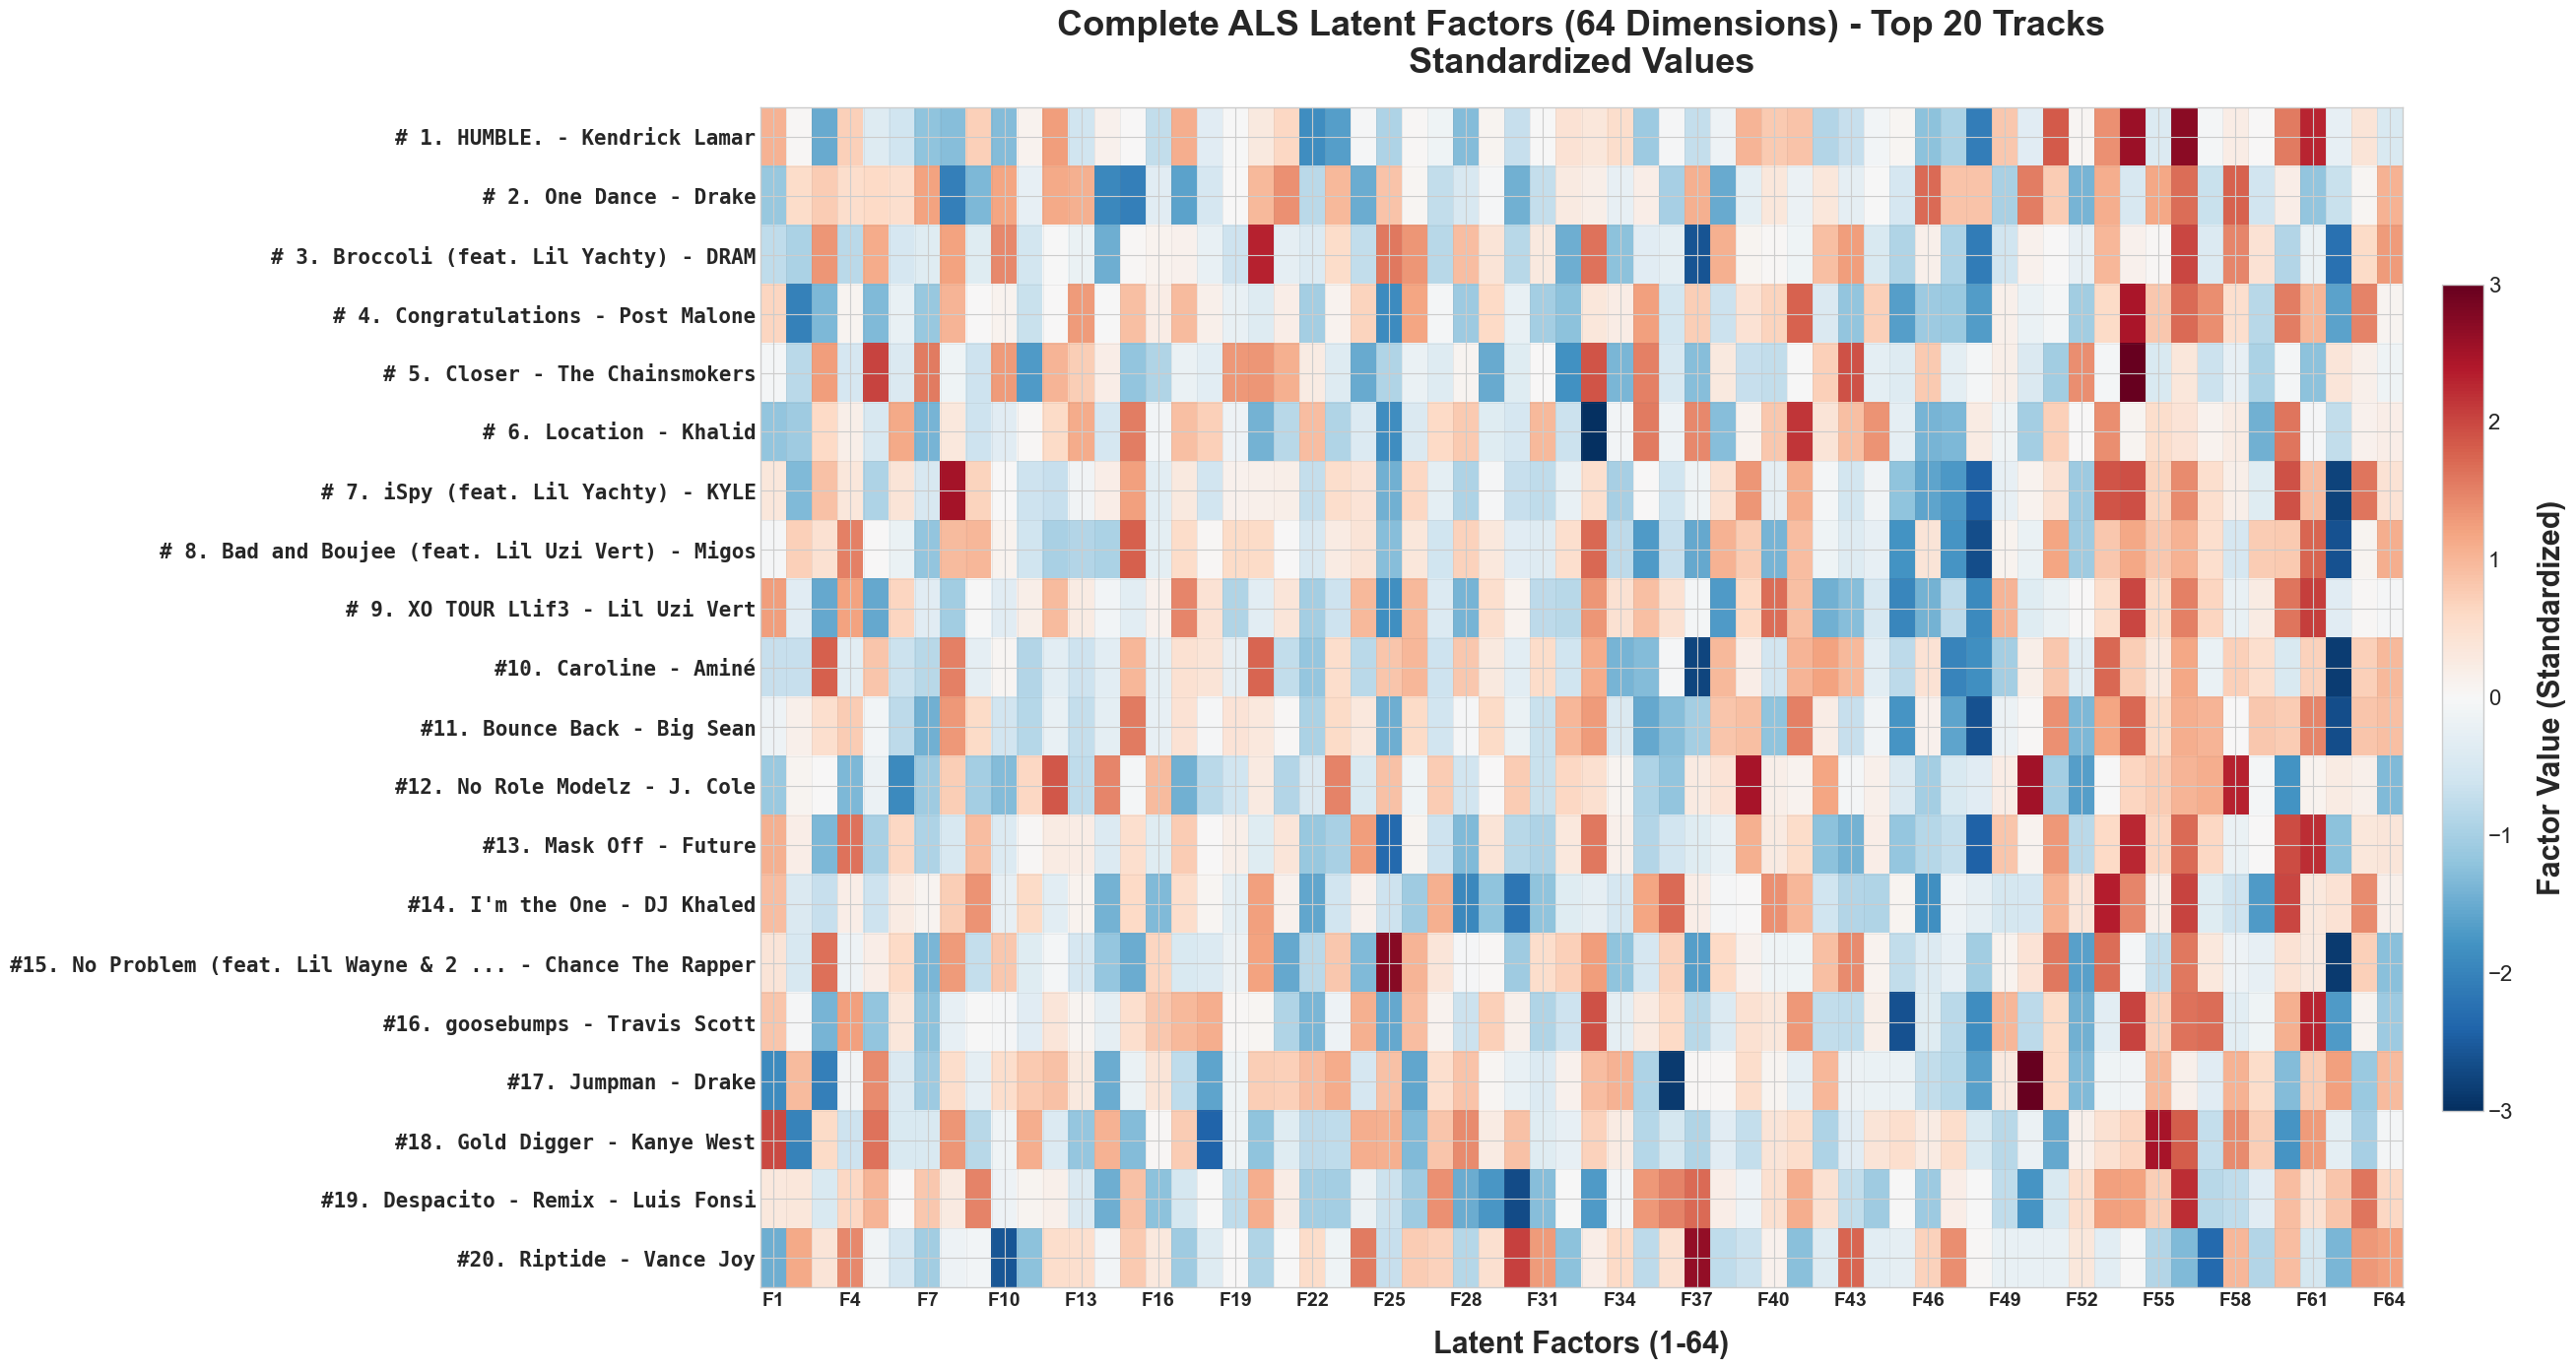

In [37]:
# ==========================================
# CELL 1: Generate the heatmap
# ==========================================
fig1, factor_matrix, track_info = visualize_top_20_tracks_heatmap(normalize=True)
plt.show()


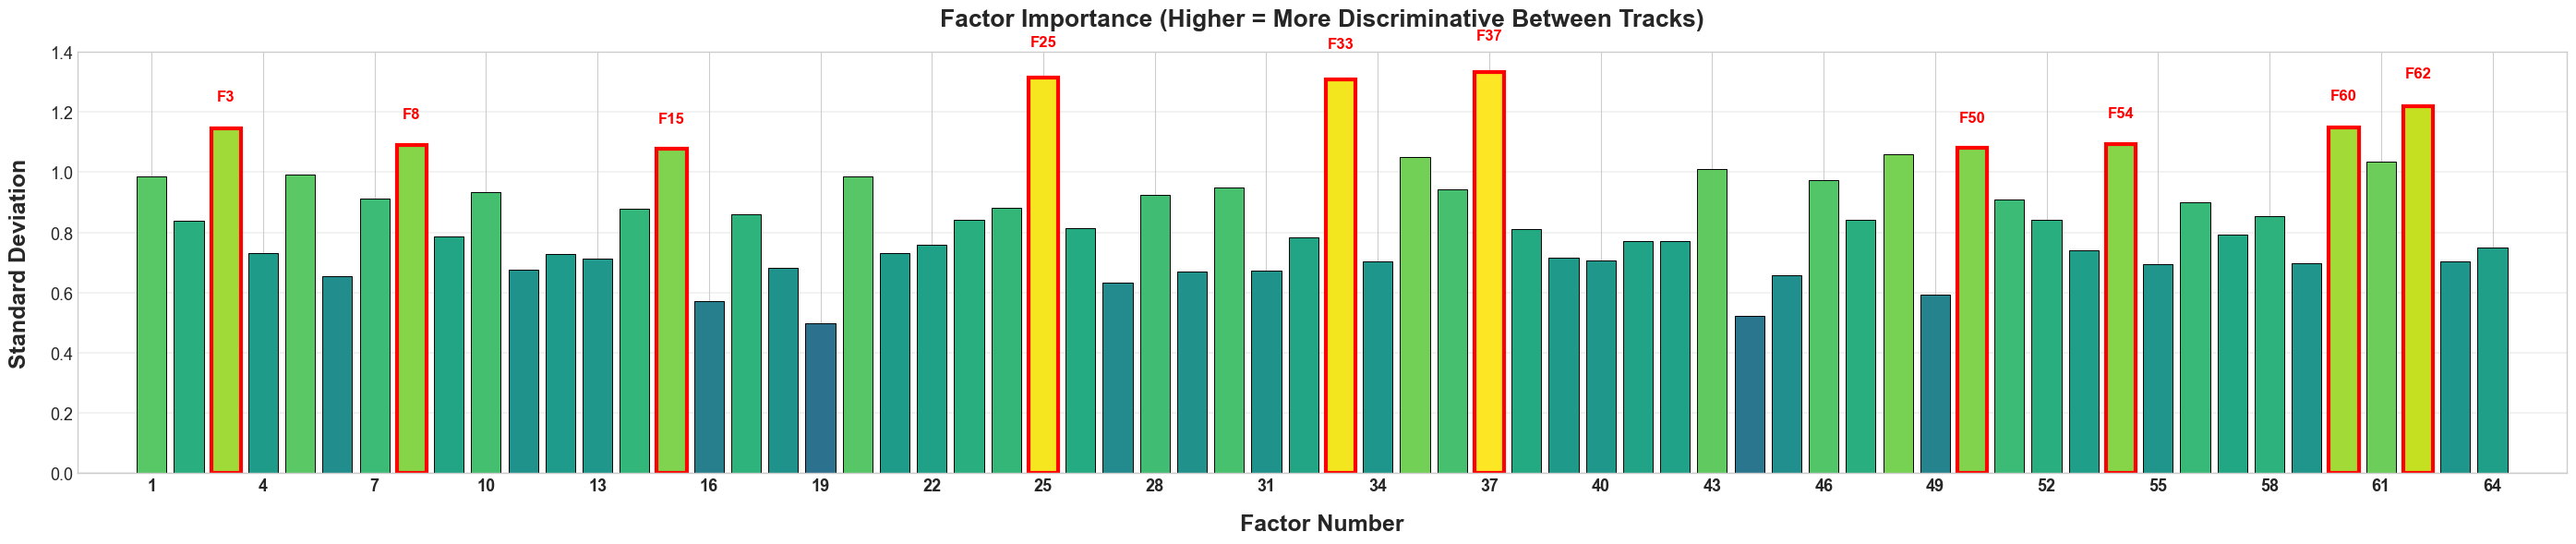

In [38]:
# ==========================================
# CELL 2: Generate the factor importance plot
# ==========================================
fig2 = visualize_factor_importance(factor_matrix)
plt.show()

In [39]:
# ============================================================
# ALS EVALUATION METRICS (playlist-based, item–item ALS)
# ============================================================

import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


# --- Helpers: AP@K and NDCG@K (binary relevance) ---

def average_precision_at_k(ranked_ids, relevant_ids, k):
    """
    Average Precision@K for a single ranked list.

    ranked_ids : list of recommended track_ids (ordered)
    relevant_ids : set of ground-truth relevant track_ids
    k : cutoff
    """
    if not relevant_ids:
        return 0.0

    hits = 0
    sum_precisions = 0.0
    for i, tid in enumerate(ranked_ids[:k], start=1):
        if tid in relevant_ids:
            hits += 1
            sum_precisions += hits / i

    denom = min(len(relevant_ids), k)
    if denom == 0:
        return 0.0
    return sum_precisions / denom


def ndcg_at_k(ranked_ids, relevant_ids, k):
    """
    NDCG@K for binary relevance.
    """
    dcg = 0.0
    for i, tid in enumerate(ranked_ids[:k], start=1):
        rel = 1.0 if tid in relevant_ids else 0.0
        if rel > 0:
            dcg += rel / math.log2(i + 1)

    max_rels = min(len(relevant_ids), k)
    if max_rels == 0:
        return 0.0

    idcg = 0.0
    for i in range(1, max_rels + 1):
        idcg += 1.0 / math.log2(i + 1)

    if idcg == 0:
        return 0.0

    return dcg / idcg


# --- Build playlist -> track list from interactions used for ALS ---

playlist_to_tracks = defaultdict(list)
for row in interactions.itertuples(index=False):
    playlist_to_tracks[row.pid].append(row.track_id)

# Keep playlists with at least 2 tracks that are in the ALS universe
playlist_ids_eval = []
for pid, tids in playlist_to_tracks.items():
    valid_tracks = [t for t in tids if t in tid_to_idx]
    if len(valid_tracks) >= 2:
        playlist_ids_eval.append(pid)

print("Playlists available for ALS evaluation:", len(playlist_ids_eval))


def evaluate_als_item_item_multi_k(
    Ks=(5, 10, 20, 50),
    num_playlists=500,
    seed=42,
):
    """
    Evaluate ALS track–track recommendations using playlist structure
    as ground truth (similar to the kNN evaluation in the other notebook).

    For each sampled playlist:
      - pick 1 seed track from that playlist
      - relevant tracks = all other tracks in that playlist
      - recommendations = ALS similar tracks to the seed
      - compute metrics at each K in Ks:
          Recall@K, HitRate@K, Precision@K, MAP@K, NDCG@K

    Returns:
        metrics_df: DataFrame (rows = metrics, columns = @K),
        n_eval:     number of playlists actually used
    """
    rng = random.Random(seed)
    Ks = sorted(list(Ks))
    max_k = Ks[-1]

    sampled_pids = rng.sample(
        playlist_ids_eval,
        min(num_playlists, len(playlist_ids_eval))
    )

    stats = {
        "Recall":   {k: [] for k in Ks},
        "HitRate":  {k: [] for k in Ks},
        "Precision":{k: [] for k in Ks},
        "MAP":      {k: [] for k in Ks},
        "NDCG":     {k: [] for k in Ks},
    }

    n_eval = 0

    for pid in sampled_pids:
        tracks = [t for t in playlist_to_tracks[pid] if t in tid_to_idx]
        if len(tracks) < 2:
            continue

        seed_track = rng.choice(tracks)
        relevant = set(tracks) - {seed_track}
        if not relevant:
            continue

        try:
            rec_df = recommend_similar_tracks_by_id_als(seed_track, top_k=max_k)
        except ValueError:
            # Seed track not in ALS index
            continue

        ranked_ids = list(rec_df["track_id"])
        if not ranked_ids:
            continue

        n_eval += 1

        for k in Ks:
            topk = ranked_ids[:k]
            topk_set = set(topk)

            n_hits = len(relevant & topk_set)
            recall_k = n_hits / len(relevant)
            hit_k = 1.0 if n_hits > 0 else 0.0
            precision_k = n_hits / len(topk) if topk else 0.0
            ap_k = average_precision_at_k(ranked_ids, relevant, k)
            ndcg_k = ndcg_at_k(ranked_ids, relevant, k)

            stats["Recall"][k].append(recall_k)
            stats["HitRate"][k].append(hit_k)
            stats["Precision"][k].append(precision_k)
            stats["MAP"][k].append(ap_k)
            stats["NDCG"][k].append(ndcg_k)

    data = {}
    for metric_name, per_k in stats.items():
        data[metric_name] = {
            k: float(np.mean(vals)) if len(vals) > 0 else 0.0
            for k, vals in per_k.items()
        }

    metrics_df = pd.DataFrame(data).T
    metrics_df.columns = [f"@{k}" for k in Ks]
    metrics_df.index.name = "ALS item–item metrics"

    return metrics_df, n_eval


# Run evaluation
ALS_K_LIST = [5, 10, 20, 50]

als_metrics_df, n_eval_playlists = evaluate_als_item_item_multi_k(
    Ks=ALS_K_LIST,
    num_playlists=500,
    seed=42,
)

print(f"\nEvaluated ALS item–item recommendations on {n_eval_playlists} playlists.\n")
display(als_metrics_df.style.format("{:.4f}"))


Playlists available for ALS evaluation: 49970

Evaluated ALS item–item recommendations on 500 playlists.



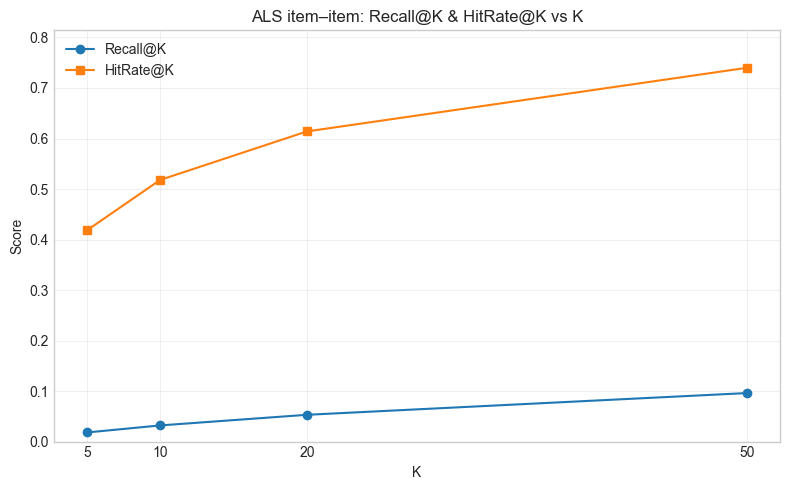

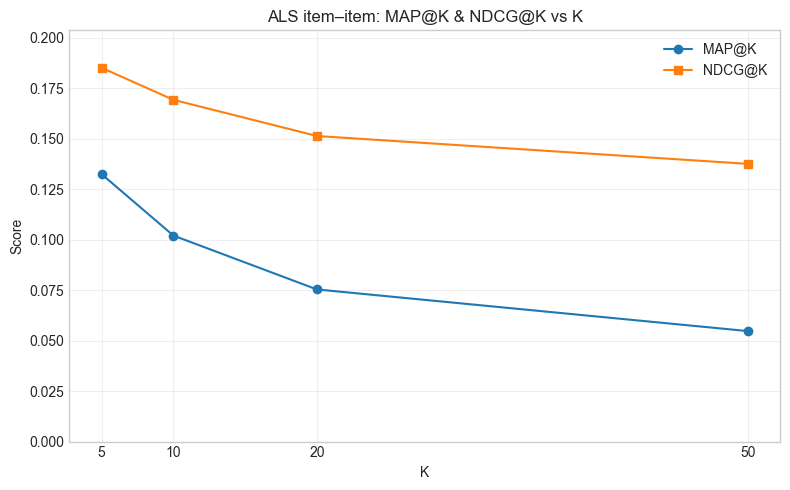

In [40]:
# ============================================================
# Plots: ALS Recall@K, HitRate@K, NDCG@K, MAP@K vs K
# ============================================================

ks = [int(col.strip("@")) for col in als_metrics_df.columns]

plt.figure(figsize=(8, 5))
plt.plot(ks, als_metrics_df.loc["Recall"].values,   marker="o", label="Recall@K")
plt.plot(ks, als_metrics_df.loc["HitRate"].values,  marker="s", label="HitRate@K")
plt.xlabel("K")
plt.ylabel("Score")
plt.title("ALS item–item: Recall@K & HitRate@K vs K")
plt.xticks(ks)
plt.ylim(0, max(als_metrics_df.loc[["Recall", "HitRate"]].values.flatten()) * 1.1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(ks, als_metrics_df.loc["MAP"].values,   marker="o", label="MAP@K")
plt.plot(ks, als_metrics_df.loc["NDCG"].values, marker="s", label="NDCG@K")
plt.xlabel("K")
plt.ylabel("Score")
plt.title("ALS item–item: MAP@K & NDCG@K vs K")
plt.xticks(ks)
plt.ylim(0, max(als_metrics_df.loc[["MAP", "NDCG"]].values.flatten()) * 1.1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Playlists available for ALS evaluation: 49970

Evaluated ALS item–item recommendations on 500 playlists.



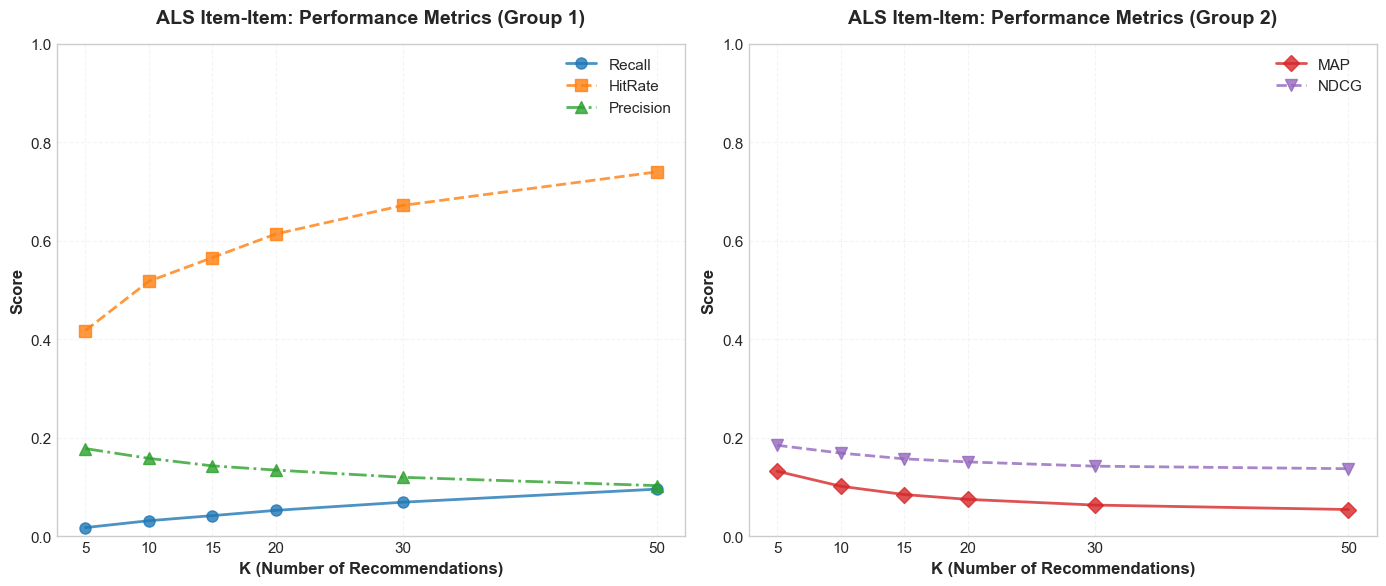

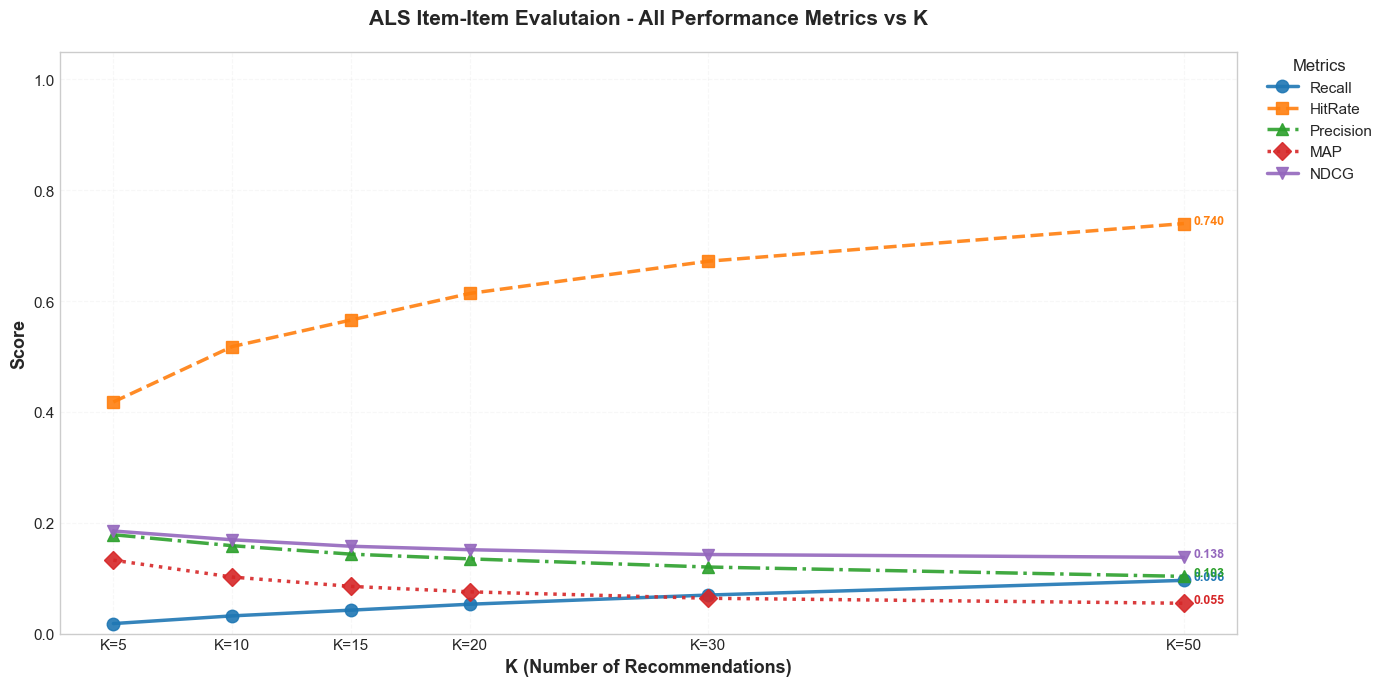

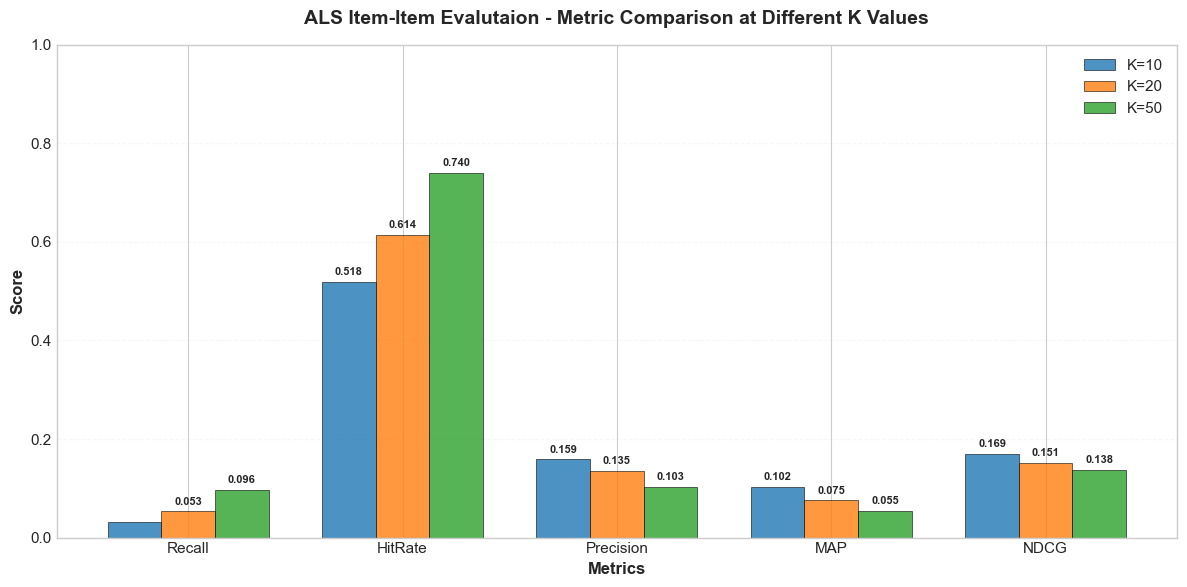

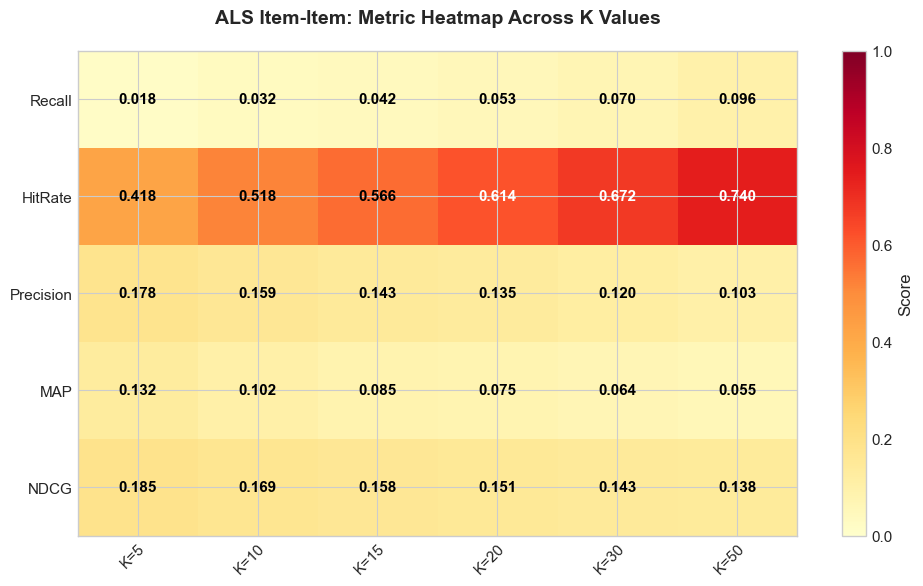

In [42]:
# ============================================================
# ALS EVALUATION METRICS (playlist-based, item–item ALS)
# ============================================================

import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Helpers: AP@K and NDCG@K (binary relevance) ---
def average_precision_at_k(ranked_ids, relevant_ids, k):
    """
    Average Precision@K for a single ranked list.
    ranked_ids : list of recommended track_ids (ordered)
    relevant_ids : set of ground-truth relevant track_ids
    k : cutoff
    """
    if not relevant_ids:
        return 0.0

    hits = 0
    sum_precisions = 0.0
    for i, tid in enumerate(ranked_ids[:k], start=1):
        if tid in relevant_ids:
            hits += 1
            sum_precisions += hits / i

    denom = min(len(relevant_ids), k)
    if denom == 0:
        return 0.0
    return sum_precisions / denom


def ndcg_at_k(ranked_ids, relevant_ids, k):
    """
    NDCG@K for binary relevance.
    """
    dcg = 0.0
    for i, tid in enumerate(ranked_ids[:k], start=1):
        rel = 1.0 if tid in relevant_ids else 0.0
        if rel > 0:
            dcg += rel / math.log2(i + 1)

    max_rels = min(len(relevant_ids), k)
    if max_rels == 0:
        return 0.0

    idcg = 0.0
    for i in range(1, max_rels + 1):
        idcg += 1.0 / math.log2(i + 1)

    if idcg == 0:
        return 0.0

    return dcg / idcg


# --- Build playlist -> track list from interactions used for ALS ---
playlist_to_tracks = defaultdict(list)
for row in interactions.itertuples(index=False):
    playlist_to_tracks[row.pid].append(row.track_id)

# Keep playlists with at least 2 tracks that are in the ALS universe
playlist_ids_eval = []
for pid, tids in playlist_to_tracks.items():
    valid_tracks = [t for t in tids if t in tid_to_idx]
    if len(valid_tracks) >= 2:
        playlist_ids_eval.append(pid)

print("Playlists available for ALS evaluation:", len(playlist_ids_eval))


def evaluate_als_item_item_multi_k(
    Ks=(5, 10, 15, 20, 30, 50),
    num_playlists=500,
    seed=42,
):
    """
    Evaluate ALS track–track recommendations using playlist structure
    as ground truth (similar to the kNN evaluation in the other notebook).

    For each sampled playlist:
      - pick 1 seed track from that playlist
      - relevant tracks = all other tracks in that playlist
      - recommendations = ALS similar tracks to the seed
      - compute metrics at each K in Ks:
          Recall@K, HitRate@K, Precision@K, MAP@K, NDCG@K

    Returns:
        metrics_df: DataFrame (rows = metrics, columns = @K),
        n_eval:     number of playlists actually used
    """
    rng = random.Random(seed)
    Ks = sorted(list(Ks))
    max_k = Ks[-1]

    sampled_pids = rng.sample(
        playlist_ids_eval,
        min(num_playlists, len(playlist_ids_eval))
    )

    stats = {
        "Recall":   {k: [] for k in Ks},
        "HitRate":  {k: [] for k in Ks},
        "Precision":{k: [] for k in Ks},
        "MAP":      {k: [] for k in Ks},
        "NDCG":     {k: [] for k in Ks},
    }

    n_eval = 0

    for pid in sampled_pids:
        tracks = [t for t in playlist_to_tracks[pid] if t in tid_to_idx]
        if len(tracks) < 2:
            continue

        seed_track = rng.choice(tracks)
        relevant = set(tracks) - {seed_track}
        if not relevant:
            continue

        try:
            rec_df = recommend_similar_tracks_by_id_als(seed_track, top_k=max_k)
        except ValueError:
            # Seed track not in ALS index
            continue

        ranked_ids = list(rec_df["track_id"])
        if not ranked_ids:
            continue

        n_eval += 1

        for k in Ks:
            topk = ranked_ids[:k]
            topk_set = set(topk)

            n_hits = len(relevant & topk_set)
            recall_k = n_hits / len(relevant)
            hit_k = 1.0 if n_hits > 0 else 0.0
            precision_k = n_hits / len(topk) if topk else 0.0
            ap_k = average_precision_at_k(ranked_ids, relevant, k)
            ndcg_k = ndcg_at_k(ranked_ids, relevant, k)

            stats["Recall"][k].append(recall_k)
            stats["HitRate"][k].append(hit_k)
            stats["Precision"][k].append(precision_k)
            stats["MAP"][k].append(ap_k)
            stats["NDCG"][k].append(ndcg_k)

    data = {}
    for metric_name, per_k in stats.items():
        data[metric_name] = {
            k: float(np.mean(vals)) if len(vals) > 0 else 0.0
            for k, vals in per_k.items()
        }

    metrics_df = pd.DataFrame(data).T
    metrics_df.columns = [f"@{k}" for k in Ks]
    metrics_df.index.name = "ALS item–item metrics"

    return metrics_df, n_eval


# Run evaluation with additional K values
ALS_K_LIST = [5, 10, 15, 20, 30, 50]

als_metrics_df, n_eval_playlists = evaluate_als_item_item_multi_k(
    Ks=ALS_K_LIST,
    num_playlists=500,
    seed=42,
)

print(f"\nEvaluated ALS item–item recommendations on {n_eval_playlists} playlists.\n")
display(als_metrics_df.style.format("{:.4f}"))

# ============================================================
# Enhanced Plots
# ============================================================

ks = ALS_K_LIST
metric_names = als_metrics_df.index.tolist()

# Custom styling
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11

# Color palette for better distinction
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', '^', 'D', 'v']
line_styles = ['-', '--', '-.', ':', '-']

# Plot 1: All metrics together
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Recall, HitRate, Precision
for idx, metric in enumerate(['Recall', 'HitRate', 'Precision']):
    ax[0].plot(ks, als_metrics_df.loc[metric].values, 
              color=colors[idx], marker=markers[idx], 
              linestyle=line_styles[idx], linewidth=2,
              markersize=8, label=metric, alpha=0.8)

ax[0].set_xlabel('K (Number of Recommendations)', fontweight='bold')
ax[0].set_ylabel('Score', fontweight='bold')
ax[0].set_title('ALS Item-Item: Performance Metrics (Group 1)', fontweight='bold', pad=15)
ax[0].set_xticks(ks)
ax[0].set_xticklabels(ks)
ax[0].grid(True, alpha=0.2, linestyle='--')
ax[0].legend(loc='best', framealpha=0.9)
ax[0].set_ylim(0, 1)

# Right subplot: MAP and NDCG
for idx, metric in enumerate(['MAP', 'NDCG']):
    ax[1].plot(ks, als_metrics_df.loc[metric].values, 
              color=colors[idx+3], marker=markers[idx+3], 
              linestyle=line_styles[idx], linewidth=2,
              markersize=8, label=metric, alpha=0.8)

ax[1].set_xlabel('K (Number of Recommendations)', fontweight='bold')
ax[1].set_ylabel('Score', fontweight='bold')
ax[1].set_title('ALS Item-Item: Performance Metrics (Group 2)', fontweight='bold', pad=15)
ax[1].set_xticks(ks)
ax[1].set_xticklabels(ks)
ax[1].grid(True, alpha=0.2, linestyle='--')
ax[1].legend(loc='best', framealpha=0.9)
ax[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Plot 2: All metrics on one plot with better distinction
fig, ax = plt.subplots(figsize=(14, 7))

for idx, metric in enumerate(metric_names):
    ax.plot(ks, als_metrics_df.loc[metric].values,
           color=colors[idx % len(colors)], 
           marker=markers[idx % len(markers)],
           linestyle=line_styles[idx % len(line_styles)],
           linewidth=2.5, markersize=9,
           label=f'{metric}', alpha=0.9)

ax.set_xlabel('K (Number of Recommendations)', fontweight='bold', fontsize=13)
ax.set_ylabel('Score', fontweight='bold', fontsize=13)
ax.set_title('ALS Item-Item Evalutaion - All Performance Metrics vs K', fontweight='bold', fontsize=15, pad=20)
ax.set_xticks(ks)
ax.set_xticklabels([f'K={k}' for k in ks], rotation=0, fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.15, linestyle='--', linewidth=0.8)

# Add value annotations for the last point (K=50)
for metric in metric_names:
    last_value = als_metrics_df.loc[metric].values[-1]
    ax.annotate(f'{last_value:.3f}', 
               xy=(ks[-1], last_value),
               xytext=(7, 0), textcoords='offset points',
               fontsize=9, fontweight='bold',
               color=colors[metric_names.index(metric) % len(colors)])

ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), 
          borderaxespad=0., framealpha=0.95, 
          title='Metrics', title_fontsize=12)

plt.tight_layout()
plt.show()

# Plot 3: Bar chart comparison at specific K values
selected_ks = [10, 20, 50]  # Focus on these K values for bar chart
x_pos = np.arange(len(metric_names))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

for idx, k_val in enumerate(selected_ks):
    values = als_metrics_df[f'@{k_val}'].values
    offset = (idx - 1) * width
    ax.bar(x_pos + offset, values, width,
          label=f'K={k_val}', 
          color=colors[idx],
          alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('ALS Item-Item Evalutaion - Metric Comparison at Different K Values', fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(metric_names, rotation=0, fontsize=11)
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.15, axis='y', linestyle='--')

# Add value labels on bars
for i, k_val in enumerate(selected_ks):
    values = als_metrics_df[f'@{k_val}'].values
    offset = (i - 1) * width
    for j, value in enumerate(values):
        if value > 0.05:  # Only annotate if value is significant
            ax.text(j + offset, value + 0.01, f'{value:.3f}', 
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 4: Heatmap-style visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Create heatmap data
heatmap_data = als_metrics_df.values

im = ax.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(ks)))
ax.set_yticks(np.arange(len(metric_names)))
ax.set_xticklabels([f'K={k}' for k in ks])
ax.set_yticklabels(metric_names)

# Rotate x labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(len(metric_names)):
    for j in range(len(ks)):
        text = ax.text(j, i, f'{heatmap_data[i, j]:.3f}',
                      ha="center", va="center", 
                      color="black" if heatmap_data[i, j] < 0.6 else "white",
                      fontweight='bold')

ax.set_title('ALS Item-Item: Metric Heatmap Across K Values', fontweight='bold', pad=20)
plt.colorbar(im, ax=ax, label='Score')
plt.tight_layout()
plt.show()